# Modeling


In [12]:
import pandas as pd
import time
import base64
import re
import pickle
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
from datetime import datetime
import geopandas as gpd
import pydeck as pdk
from shapely import wkt
from tqdm import tqdm
from mip import *
from typing import Any
import os 
os.chdir('/home/jihwanyoon/Data_Science_Festival_2022')
from utils.util import *

# 지도에 표시할 AED 아이콘 불러와서 저장하기
# https://www.flaticon.com/kr/authors/kanyanee-watanajitkasem
AED_ICON = 'assets/free-icon-aed-6417086.png'
icon = image_to_data_url(AED_ICON)
icon_data = {
    "url": icon,
    "width": 128,
    "height": 128,
    "anchorY": 128,
}

# 동대문구 행동별 경계면 폴리곤 데이터 
with open('data/seoul_boundary.pickle', 'rb') as f:
    boundary = pickle.load(f)

boundary = boundary[boundary['구'] == '동대문구']

aed_24_100 = pd.read_csv('./data/aed_24_100.csv')
aed_24_200 = pd.read_csv('./data/aed_24_200.csv')
df_dobo_100 = pd.read_csv('./data/df_dobo_100.csv')
df_dobo_200 = pd.read_csv('./data/df_dobo_200.csv')
total = pd.read_csv('./data/total.csv')

## 1. MCLP 알고리즘을 통한 최적 후보지 선정
- 최종 후보지 데이터 df_dobo_200

- 제약조건1 을 위한 cond_list 생성(집합 N)
- Mixed-Integer Linear programs(MIP) 라이브러리를 통한 최적화

In [ ]:
# 수요지점으로부터 유효거리 내에 있는 후보지 집합 생성(제약조건 1)
cond_list = []
for i in tqdm(df_dobo_200.index):
    buffer = df_dobo_200.loc[i, "buffer_200"]
    lst = []
    for j in df_dobo_200.index:
        point = df_dobo_200.loc[j, "geometry"] 
        if point.within(buffer):                        # 200m 반경 기준으로 존재하는 주변 후보지 노드 ID 구하기
            lst.append(df_dobo_200.loc[j, "노드 ID"])   
    cond_list.append(lst)                               # 해당 후보지를 커버할 수 있는 수요 point의 list, 집합 N

# 재사용을 위한 저장
# with open("data/cond_list.pkl","wb") as f:
#     pickle.dump(cond_list, f)

# with open("data/cond_list.pkl","rb") as f:
#     cond_list = pickle.load(f)

100%|██████████| 7733/7733 [15:18<00:00,  8.42it/s]


In [8]:
temp = df_dobo_200.copy()

temp['노드 ID'] = pd.to_numeric(temp['노드 ID'])
temp['w'].index = temp['노드 ID']
w = temp['w']
model = Model()
model.max_gap = 0.0
x = [model.add_var(name = "x%d" % i, var_type = BINARY) for i in temp['노드 ID']]           # 제약 조건 3 : 포인트에 설치되는가
y = [model.add_var(name = "y%d" % i, var_type = BINARY) for i in temp['노드 ID']]           # 제약 조건 4 : 포인트가 커버되는가
model.objective = maximize(xsum(w[i] * model.vars['y%d' %i] for i in temp['노드 ID']))      # 목적함수
model += xsum(model.vars['x%d' %j] for j in temp['노드 ID']) == 40                          # 제약 조건 2 : 설치할 AED 개수

for num, idx in enumerate(temp['노드 ID']):
    model += xsum(model.vars['x%d' %j] for j in cond_list[num]) >= model.vars['y%d' %idx]   # 제약 조건 1 : cond_list(집합 N)에 속한 후보지 중 적어도 한 곳에 AED가 입지하면 i는 커버됨 

start = time.time()

model.optimize()
solution = []
for j in temp['노드 ID']:
    if model.vars['x%d' %j].x == 0:
        solution.append(0)
    else:
        solution.append(1)
print(f"Time :{round(time.time() - start, 2)} s")

temp['sol'] = solution
sol = temp[temp['sol'] == 1]

sol['icon_data'] = None
for i in sol.index:
    sol["icon_data"][i] = icon_data

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 7734 (0) rows, 15371 (-95) columns and 723738 (-5695) elements
Clp0030I 5 infeas 15.752894, obj 4080.9818 - mu 0.044697817, its 105, 4588 interior
Clp0030I 10 infeas 25.56614, obj 4107.2775 - mu 0.0049654309, its 105, 5936 interior
Clp0030I 15 infeas 1.0888082, obj 4068.2788 - mu 0.0016549781, its 105, 5796 interior
Clp0030I 20 infeas 0.083532882, obj 4066.9513 - mu 0.00018384968, its 105, 7902 interior
Clp0030I 25 infeas 0.11953766, obj 4067.1882 - mu 2.0423657e-05, its 105, 9278 interior
Clp0030I 30 infeas 0.0047176018, obj 4067.0126 - mu 6.8072049e-06, its 105, 9311 interior
Clp0030I 35 infeas 0.0011423432, obj 4067.0118 - mu 7.5620484e-07, its 105, 9413 interior
Clp0030I 40 infeas 0.00058104946, obj 4067.0103 - mu 8.4005956e-08, its 105, 9418 interior
Clp0030I 45 infeas 4.6957959e-05, obj 4067.0081 - mu 2.79

/tmp/ipykernel_10100/1246041442.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sol['icon_data'] = None
/tmp/ipykernel_10100/1246041442.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sol["icon_data"][i] = icon_data


## 2. 최종적인 수요 커버리지 계산 후 전과 비교
- 기존 24시간 AED와 추가 설치한 AED 위치정보를 concat
- 최종적인 커버리지 계산 후 기존 대비 증가율 계산
- 추가 AED 개수 별 커버리지 변화를 보려면 15~50을 모두 돌려야하나 최종 선택한 40만 표현하였음
- 바로 위 코드의 11번째 줄의 숫자만 바꾸면 바뀐 추가 AED 개수에 따른 모델링 결과 출력 가능

In [ ]:
temp2 = df_dobo_100.copy()
temp2['b'] = total['intersects_num_scaled'].values
temp2 = temp2[temp2['b'] >= 0.75]                                                        # 기존과 두개 이하로 겹치는 경우만 후보지로

temp2['sol'] = solution
final_sol = temp2[temp2['sol'] == 1]
final_df = pd.concat([aed_24_100, final_sol], axis=0).iloc[:,2:7].reset_index(drop=True) # 기존 AED + 추가된 AED 통합 

final_total = pd.DataFrame()
for i in tqdm(temp2.index):
    db = temp2.loc[i, 'buffer_100']
    num = []
    for j in final_df.index:
        aed = final_df.loc[j, "buffer_100"]
        num.append(db.intersects(aed))
    info = {"intersects_num" : sum(num)}                                                 # 최종 설치된 AED의 유효거리 200m 내에 후보-수요지점이 들어가있는지 확인 
    final_total = final_total.append(info, ignore_index=True)                            # 0 이면 최종 AED 위치가 커버하지 못하고 있음을 의미. 

temp['intersects_num'] = final_total['intersects_num'].values  
temp.loc[temp['intersects_num'] >= 1, "intersects_num"] = 1                              # 유효 거리 내에 설치된 경우 1, 아니면 0
temp['demand'] = temp['w'] * temp['intersects_num']                                      # AED가 유효거리 내에 설치되어 만족된 수요량을 계산 
final_coverage = 100 * round(temp['demand'].sum() / temp['w'].sum(), 4)

# 기존 24시간 AED 커버리지
before_df = pd.concat([dobo_full, total], axis=1)
before_df.loc[before_df['intersects_num'] >= 1, "intersects_num"] = 1
before_df['demand'] = before_df['w'] * before_df['intersects_num']
before_coverage = 100 * round(before_df['demand'].sum() / before_df['w'].sum(), 4)

print("\n--------------------------")
print(f"기존 24시간 AED 커버리지 : {round(before_coverage,2)} %")
print(f"새로 설치한 후 커버리지 : {round(final_coverage,2)} %")
print(f"증가율 : {round(final_coverage - before_coverage, 2)} %")

## 3. 추가 AED 설치 개수에 따른 커버리지 변화 도표
- 추가 AED 개수를 15에서 50까지 늘려가며 모델링 후 커버리지 및 변화율 확인
- 개수가 늘어날수록 커버리지는 늘어나지만 전 단계 대비 커버리지 증가율은 체감됨
- 40개에서 커버리지 증가율이 추세와 반대로 늘고 그 후엔 다시 줄어드는 경향을 보임
- 현실의 재정적인 문제와 커버리지 비율을 고려할 때 추가 AED는 40개가 적절하다고 판단하였음

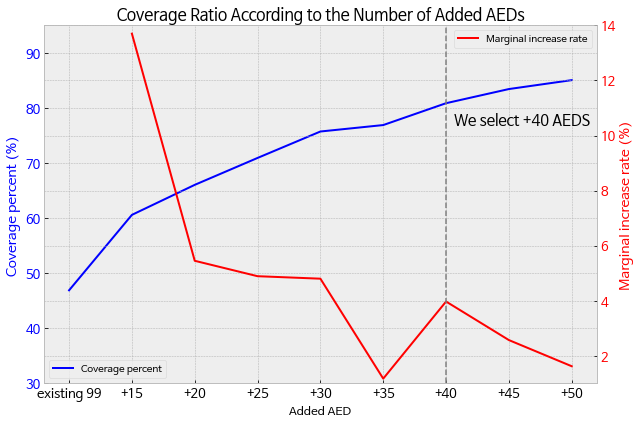

In [36]:
num = ['existing 99', '+15', '+20', '+25', '+30', '+35', '+40', '+45', '+50']
a = [46.89, 60.59, 66.04, 70.93, 75.73, 76.9, 80.87, 83.44, 85.06]
b = [None, 13.7, 19.15, 24.04, 28.84, 30.01, 33.98, 36.55, 38.17]
c = [None, 13.7, 5.45, 4.89, 4.8, 1.17, 3.97, 2.57, 1.62]

coverage = pd.DataFrame([num,a,b,c]).transpose()
coverage.columns = ['Added AED', 'Coverage percent', 'Coverage growth rate', 'Marginal increase rate']

plt.style.use('bmh')

fig, ax1 = plt.subplots(figsize=(9,6))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax1.set_title('Coverage Ratio According to the Number of Added AEDs', fontsize=16)
ax1.set_xlabel('Added AED')
ax1.set_ylabel('Coverage percent (%)', fontsize=14, color='b')
ax1.plot(coverage['Added AED'], coverage['Coverage percent'], color='b', label='Coverage percent')
plt.ylim(30,95)
ax1.tick_params(axis='y', labelcolor='b')
plt.text(6.12,77,'We select +40 AEDS',size=15)

ax2 = ax1.twinx()
ax2.set_ylim(1,14)
ax2.set_ylabel('Marginal increase rate (%)', fontsize=14, color='r')
ax2.plot(coverage['Added AED'], coverage['Marginal increase rate'], color='r', label='Marginal increase rate')
ax2.tick_params(axis='y', labelcolor='r', labelsize=13)
plt.axvline(x='+40', color='gray', linestyle='--', linewidth=1.5)
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')
fig.tight_layout()

## 4. 최종 24시간 가동 AED 시각화
- 추가 AED 위치를 추가한 최종적인 24시간 가동 AED
- 보라색은 기존 AED, 노란색이 추가된 AED
- 기존 130 여개가 커버하고 있던 32% 정도를 40개 만으로 커버 가능
- AED가 필요한 곳에 적절히 배치됨을 확인


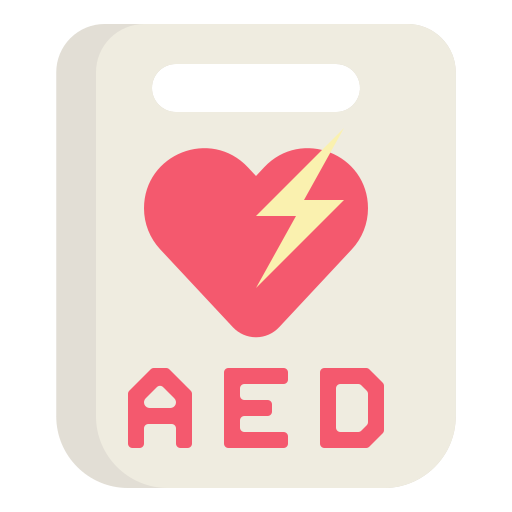
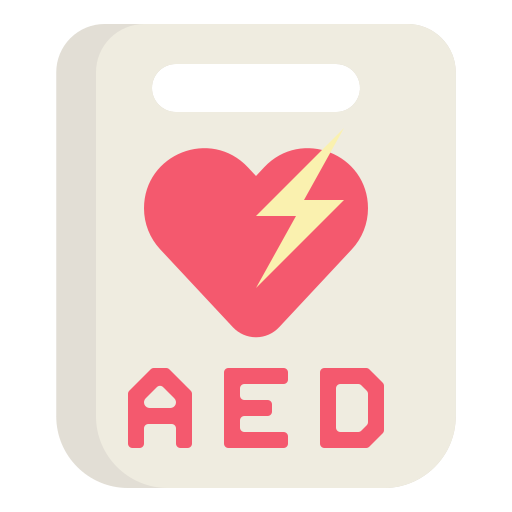
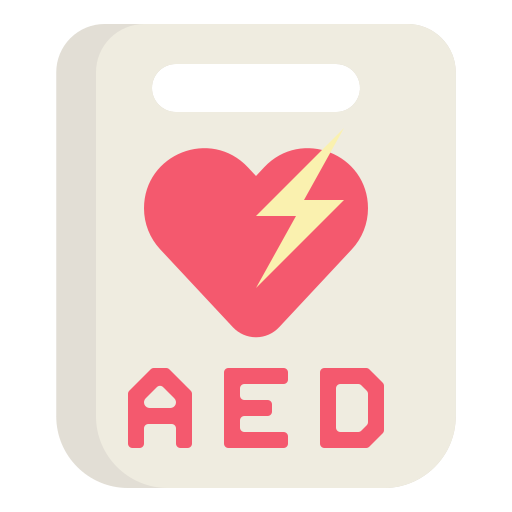
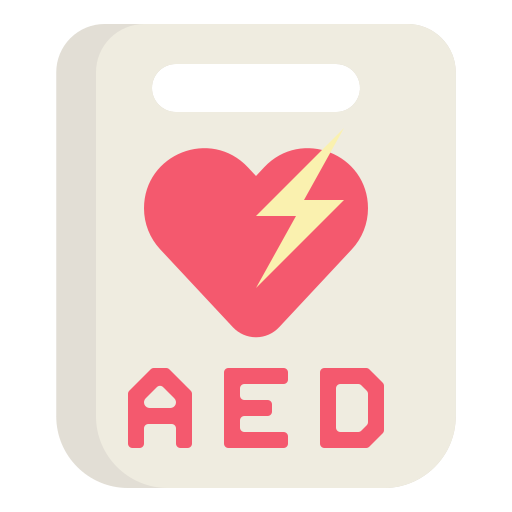
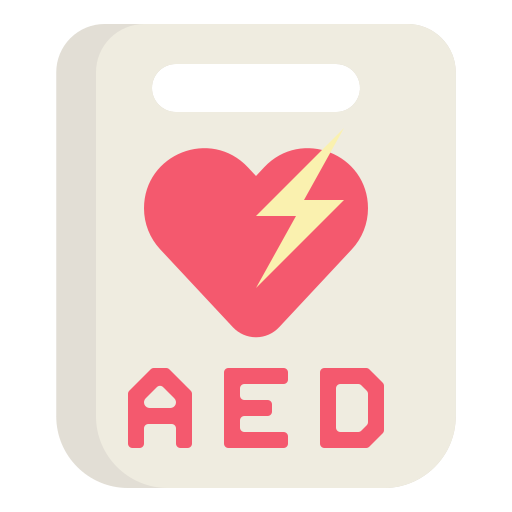
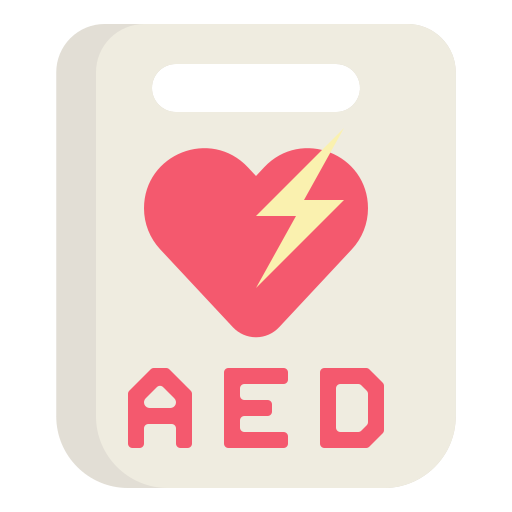
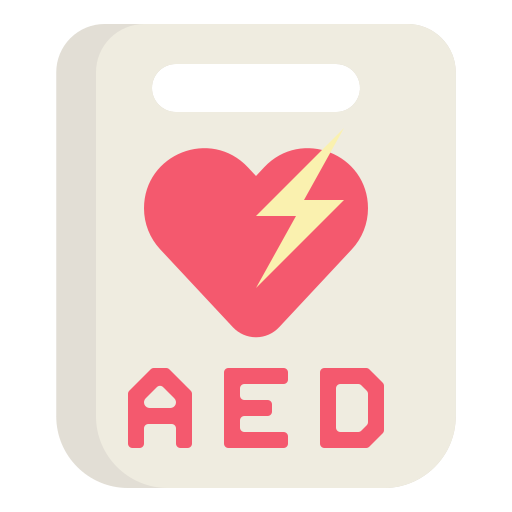
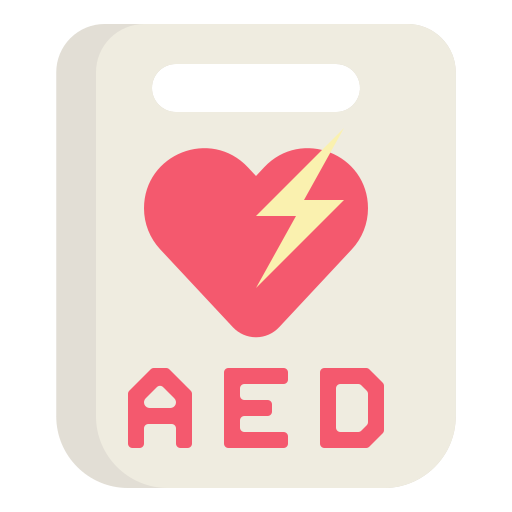
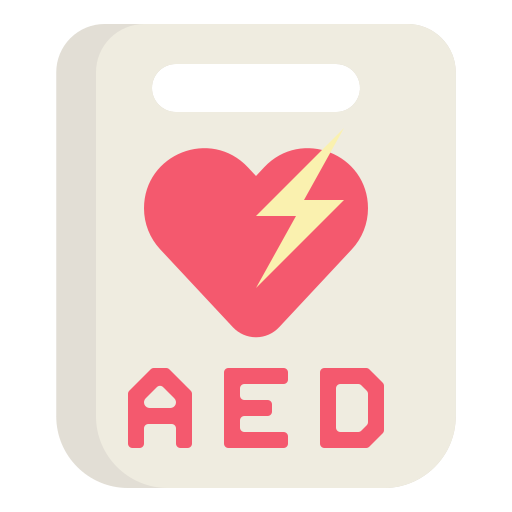
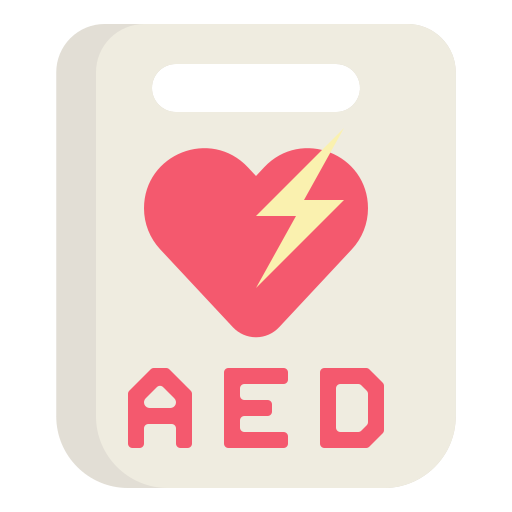
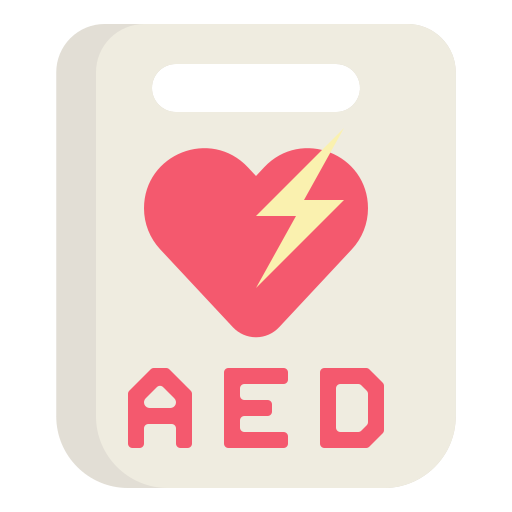
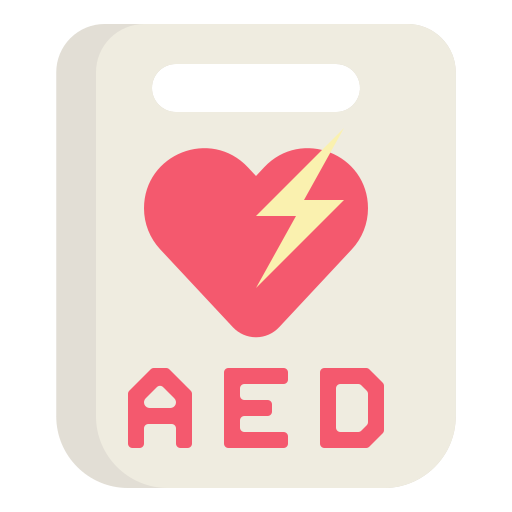
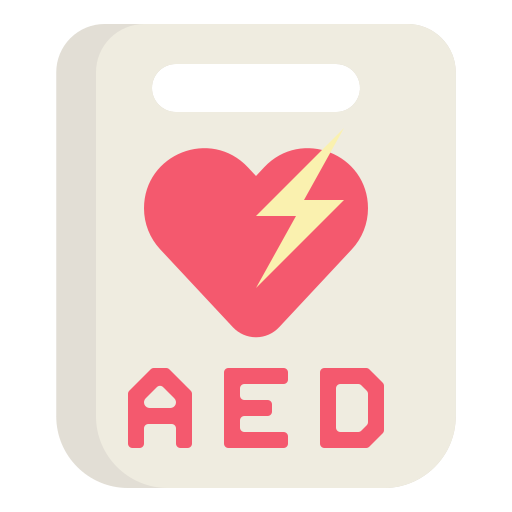
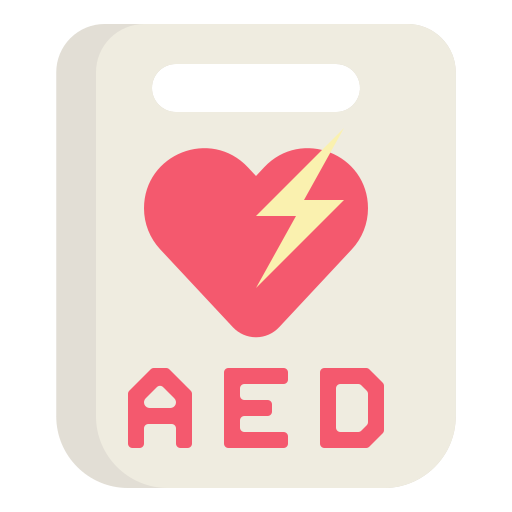
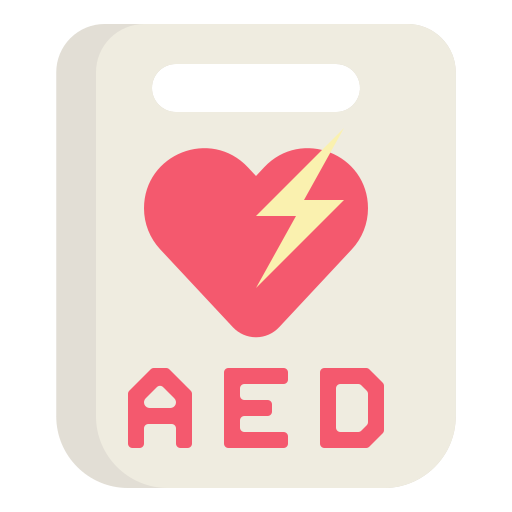
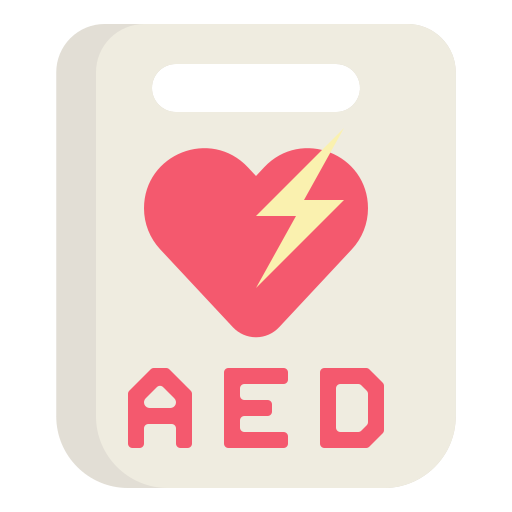
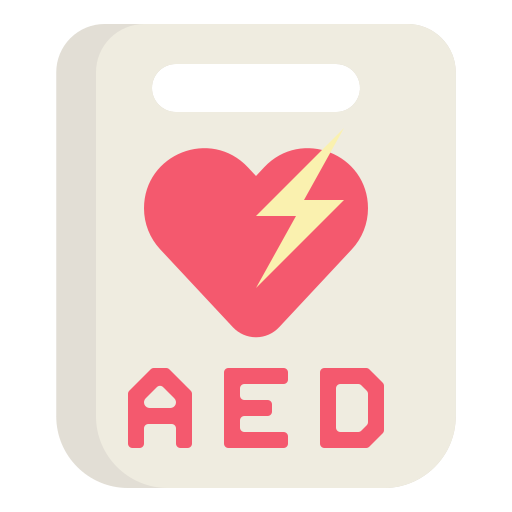
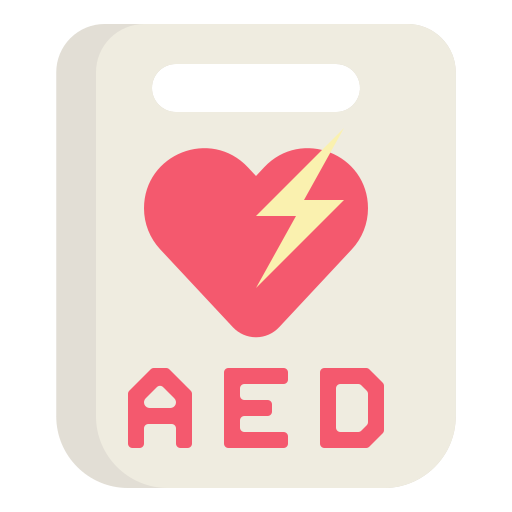
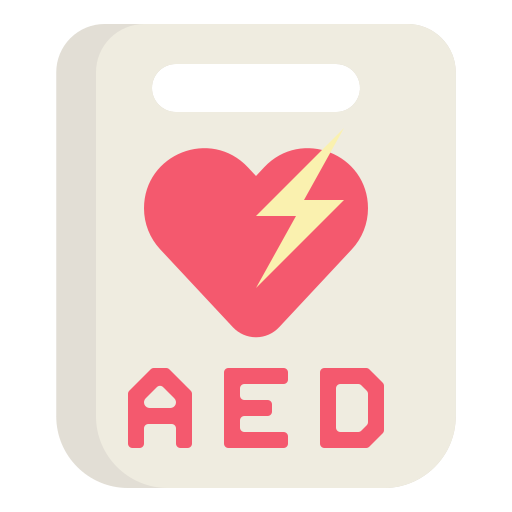
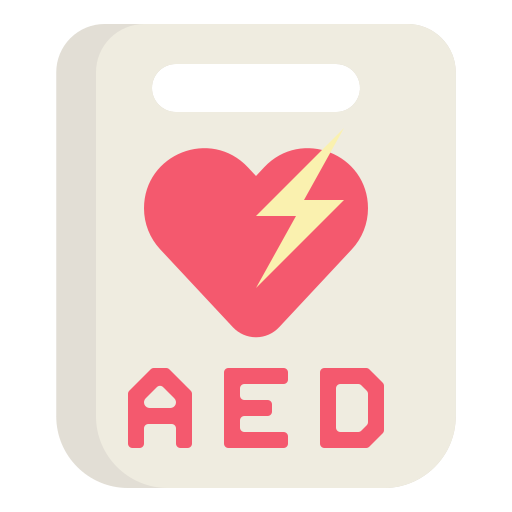
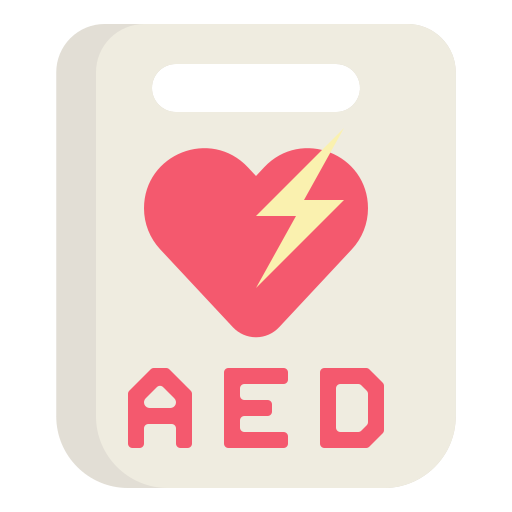
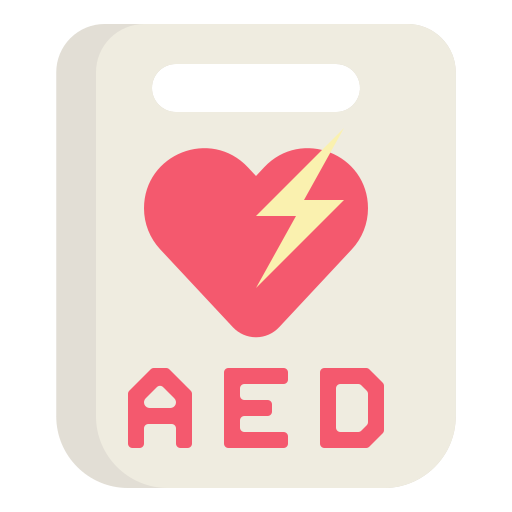
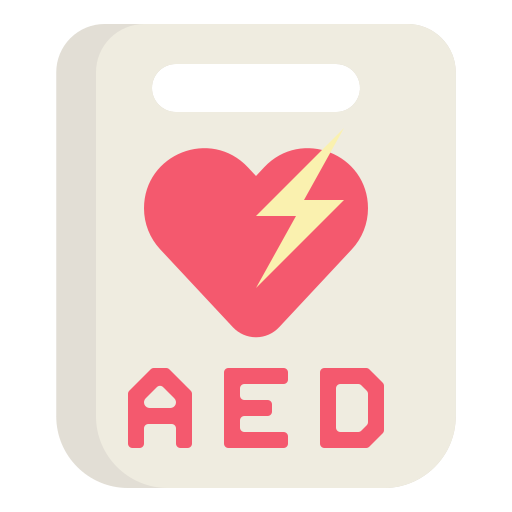
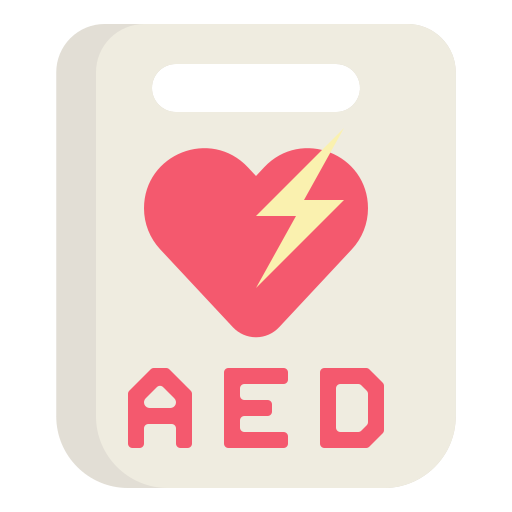
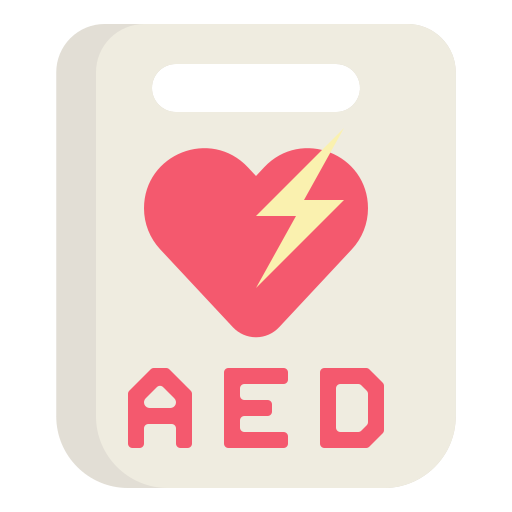
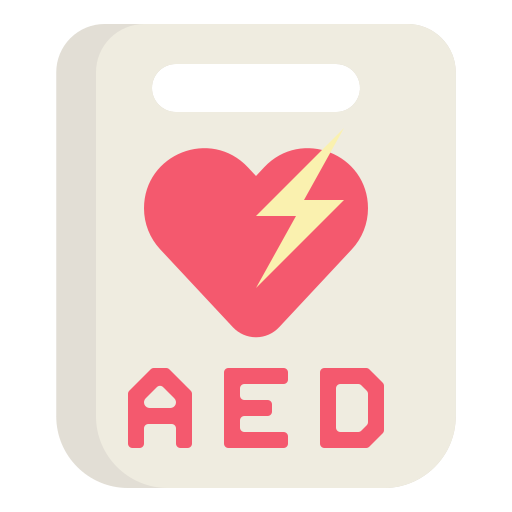
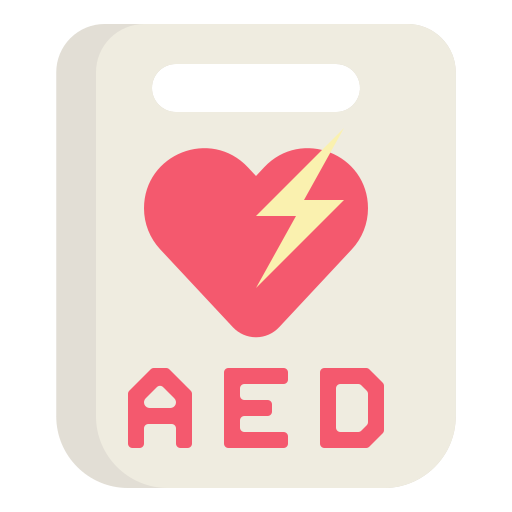
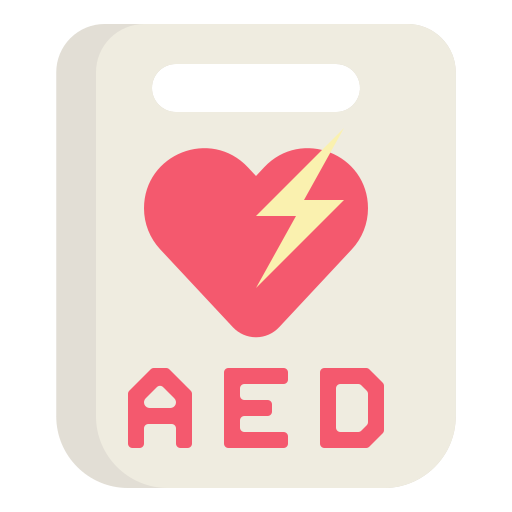
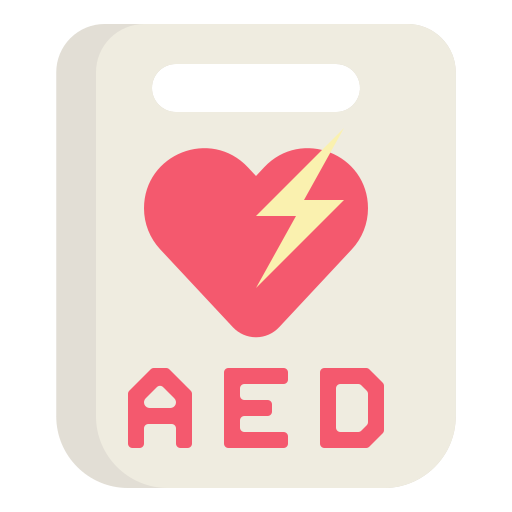
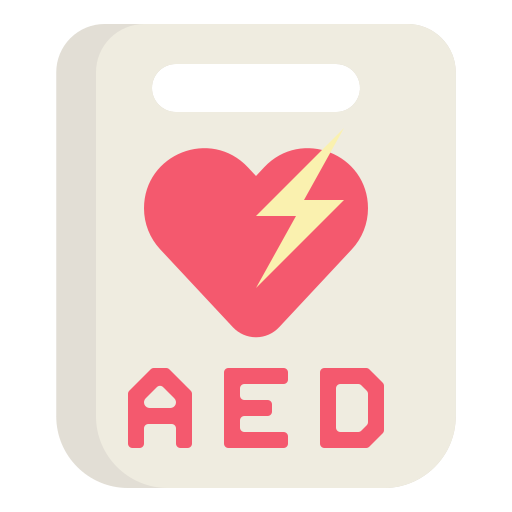
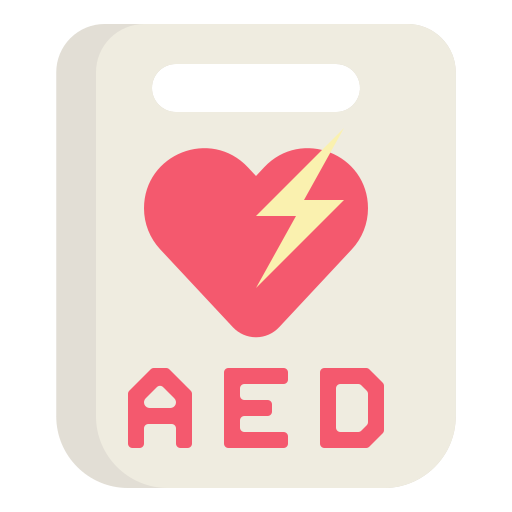
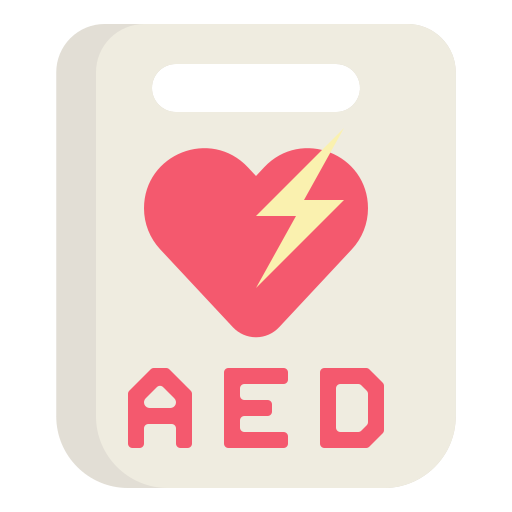
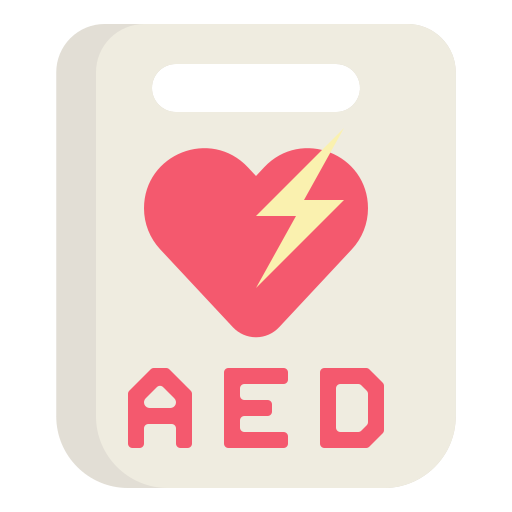
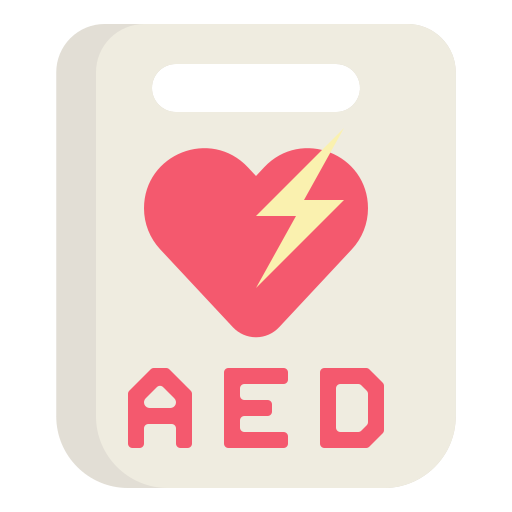
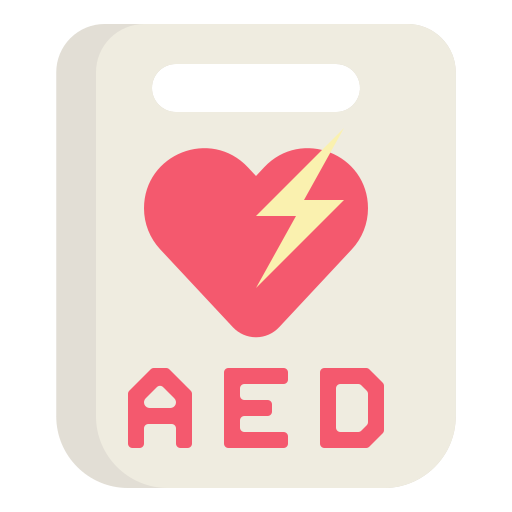
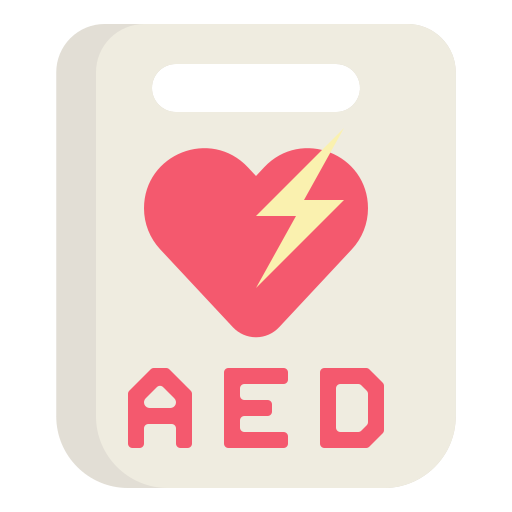
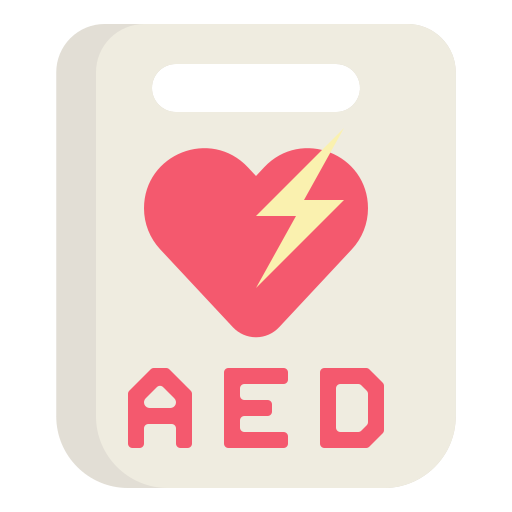
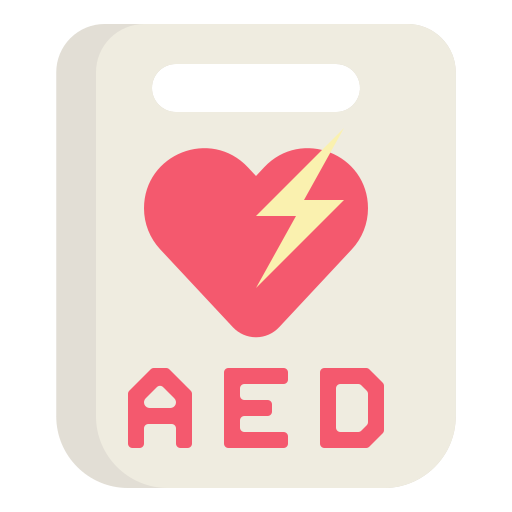
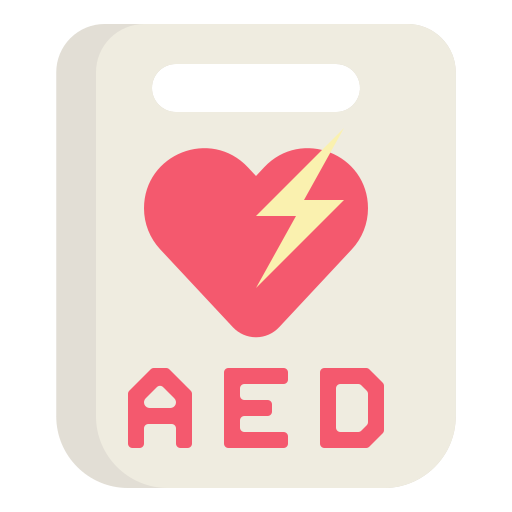
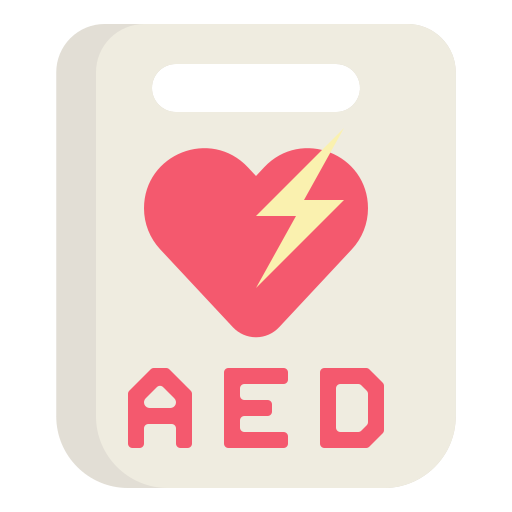
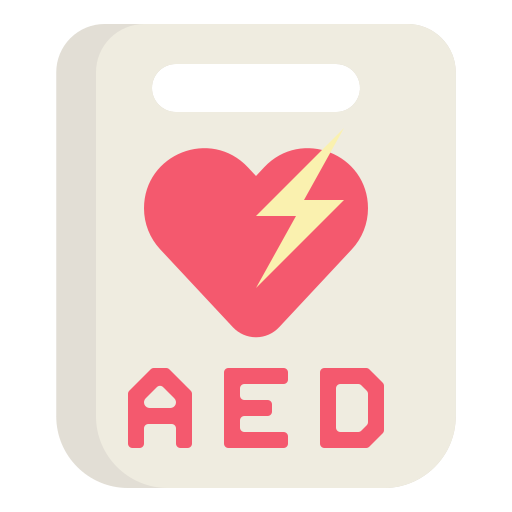
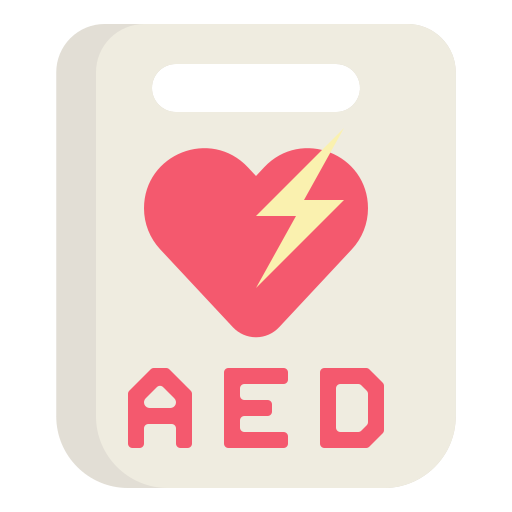
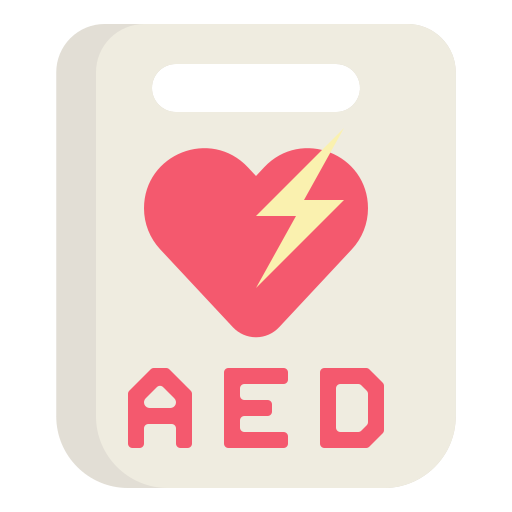
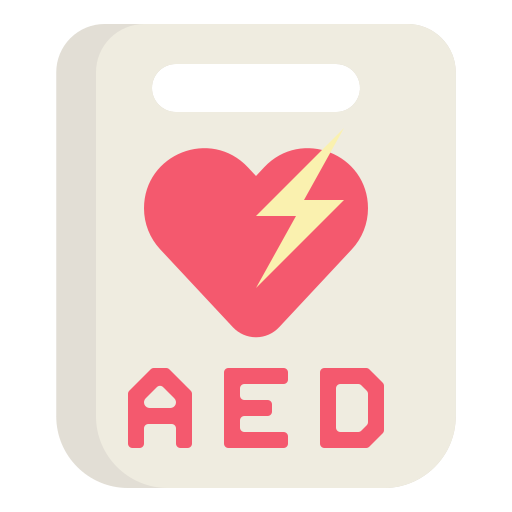
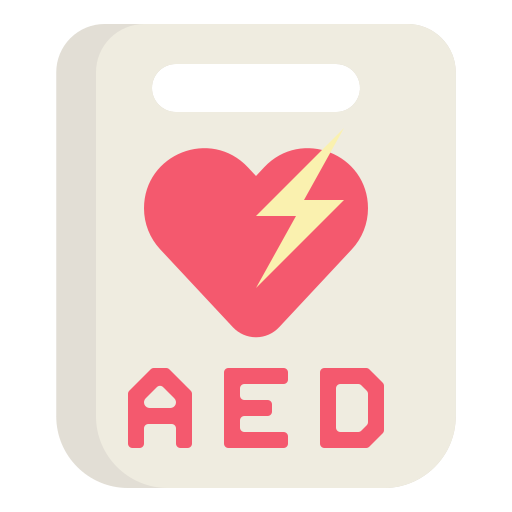
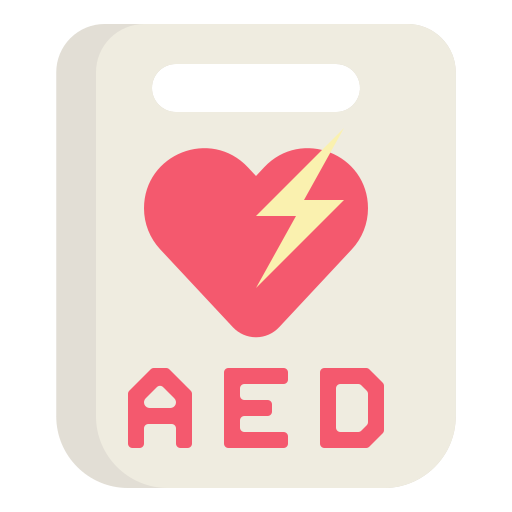
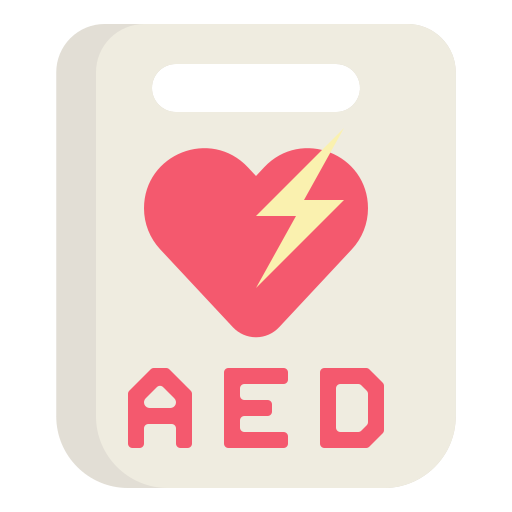
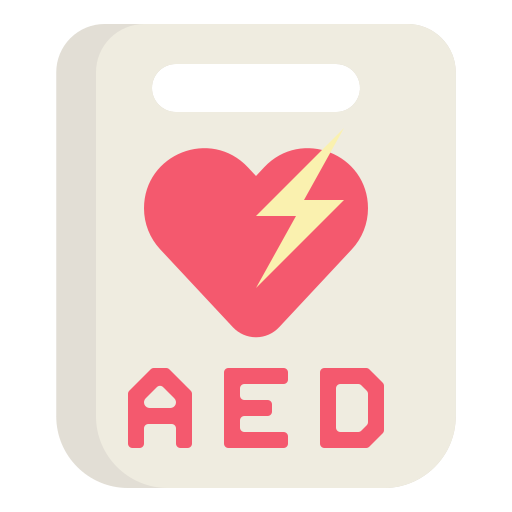
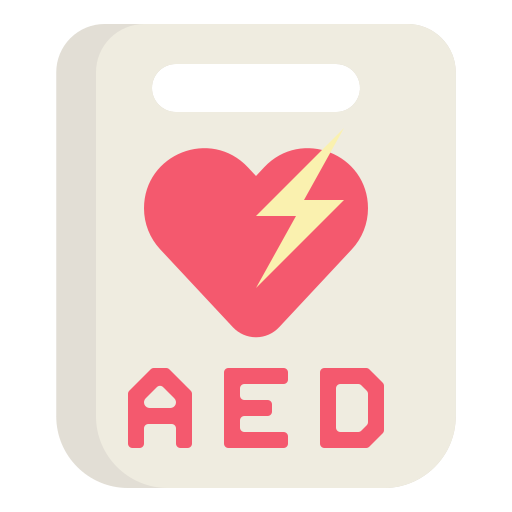
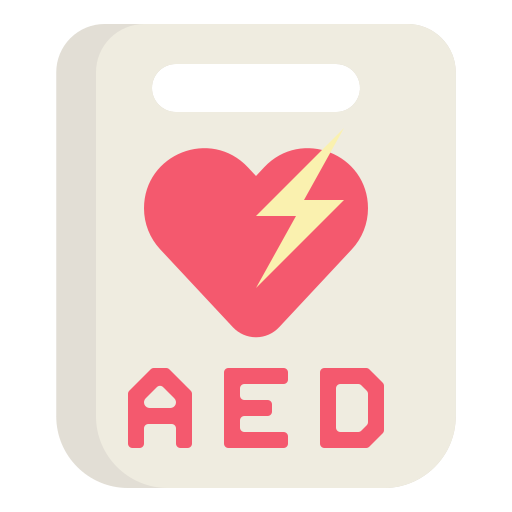
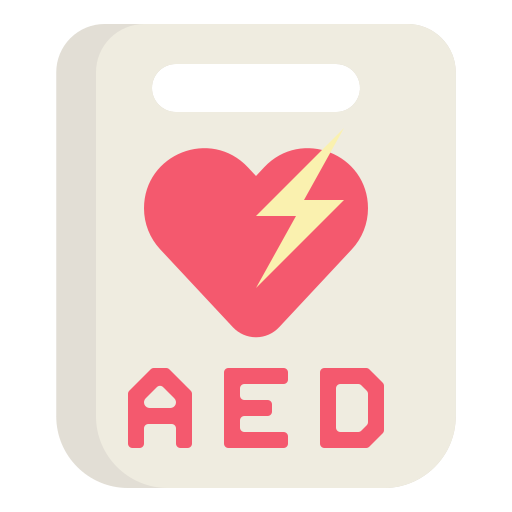
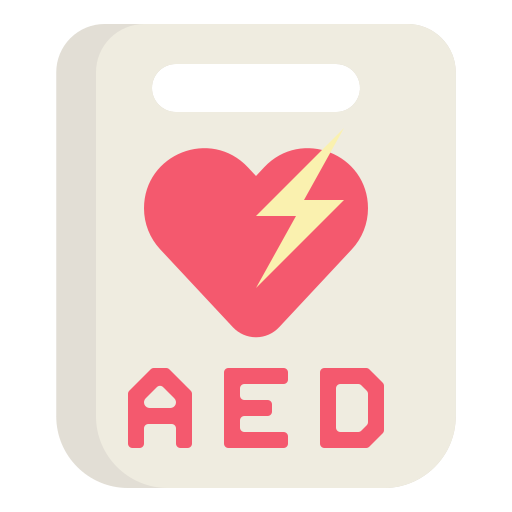
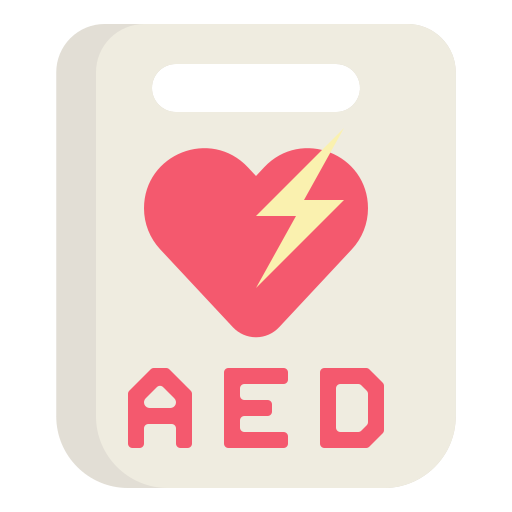
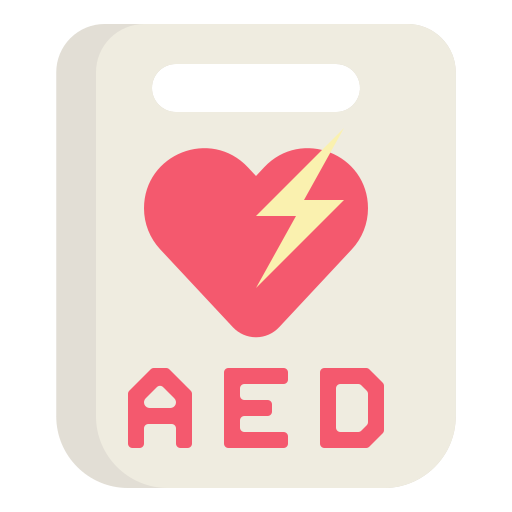
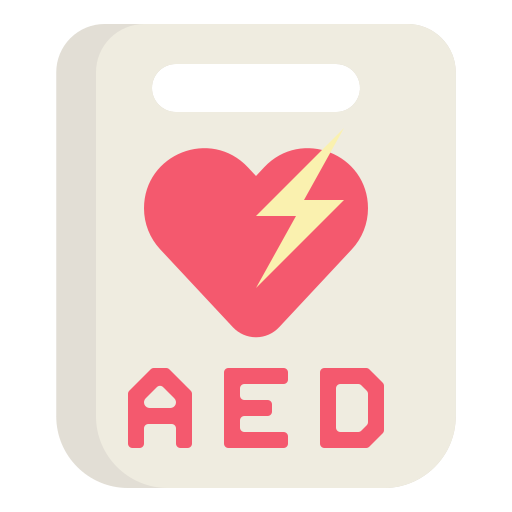
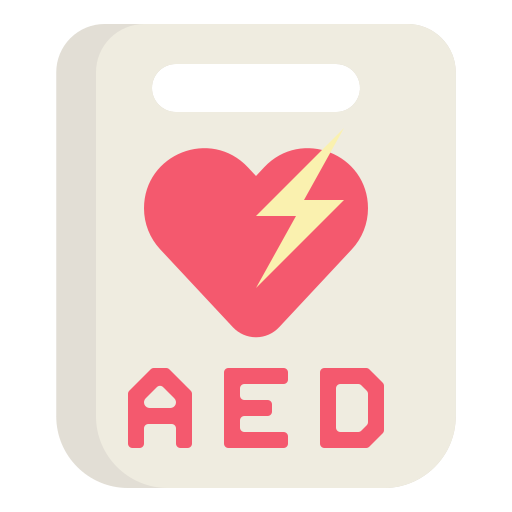
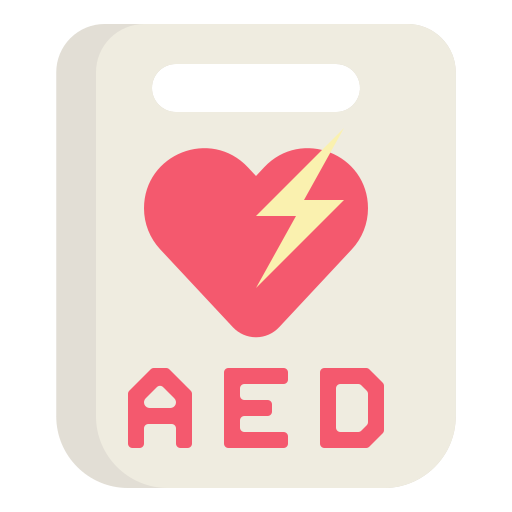
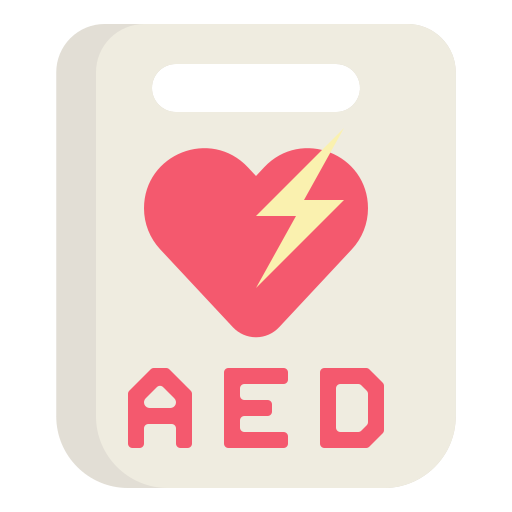
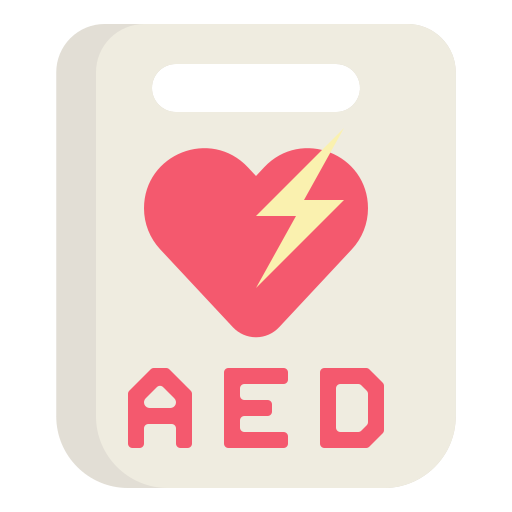
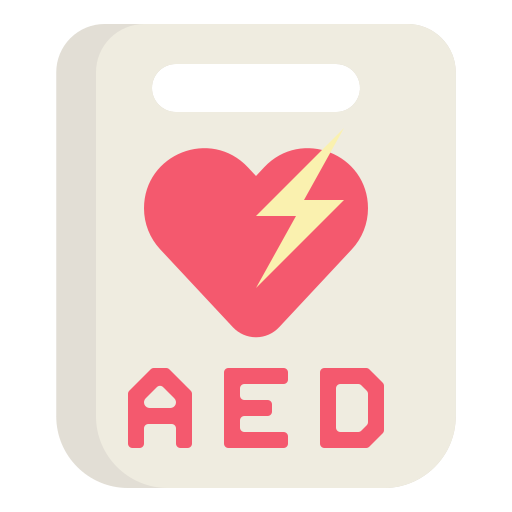
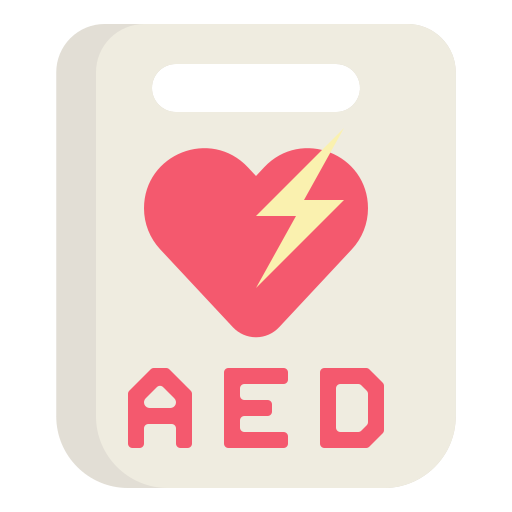
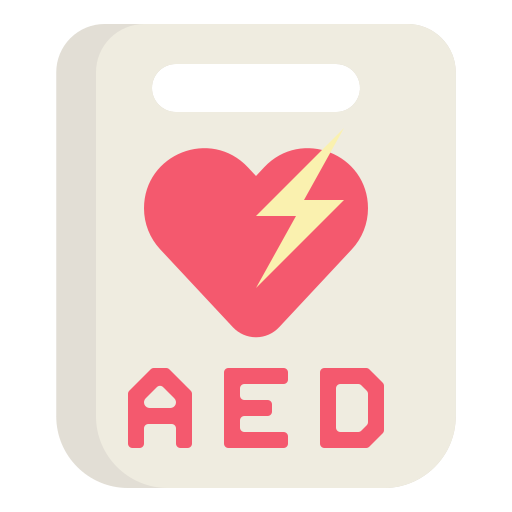
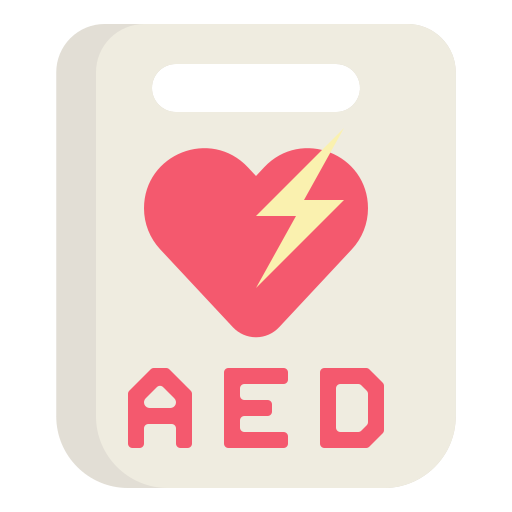
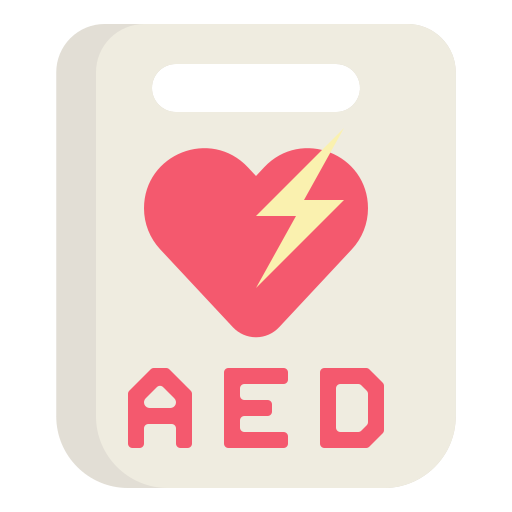
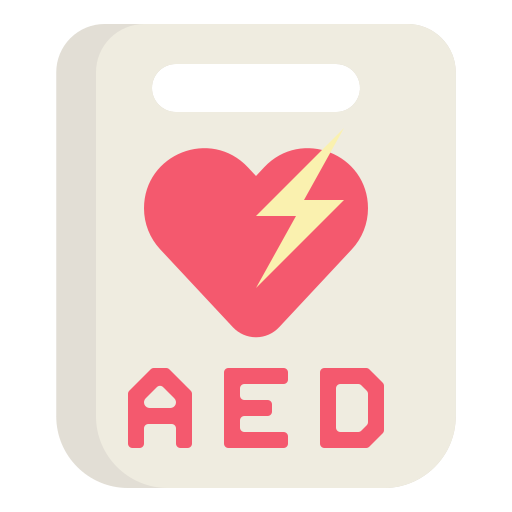
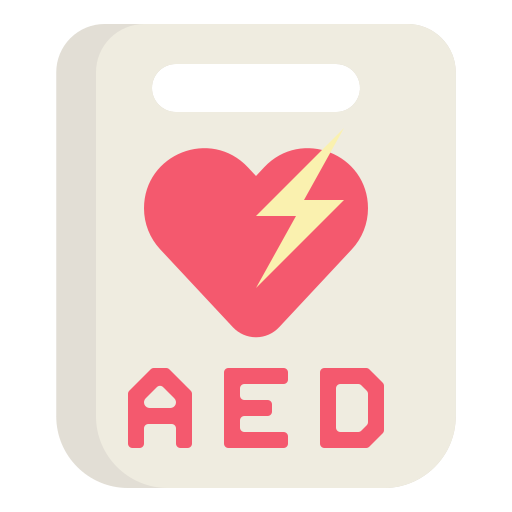
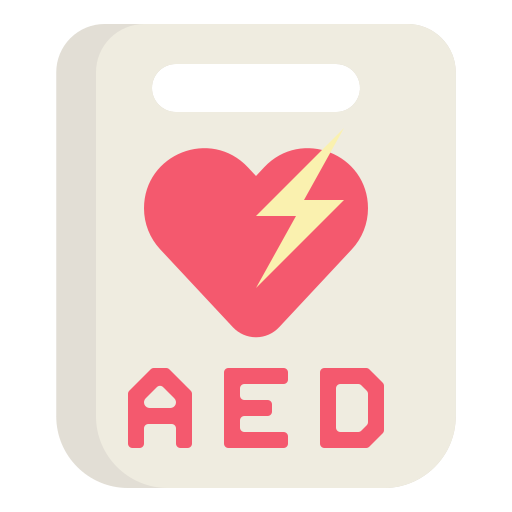
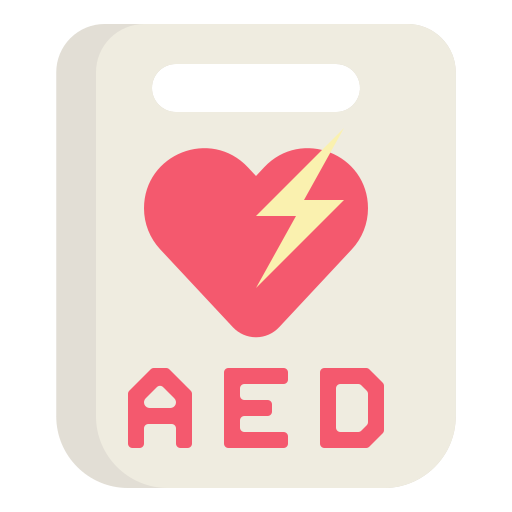
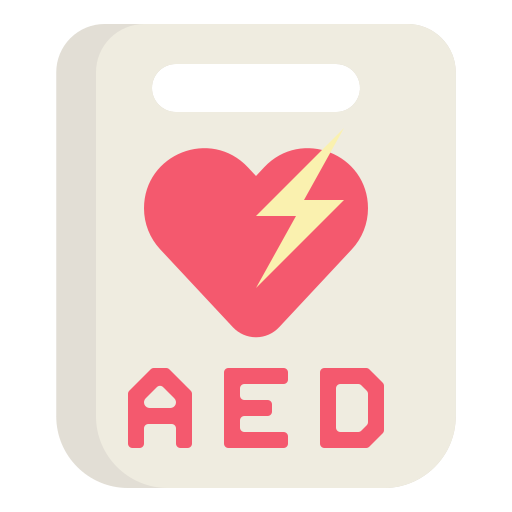
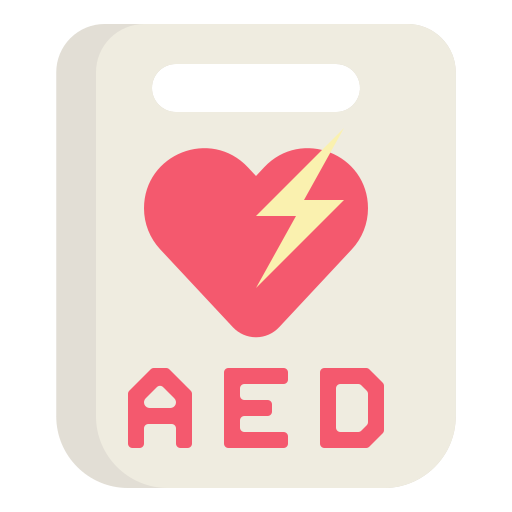
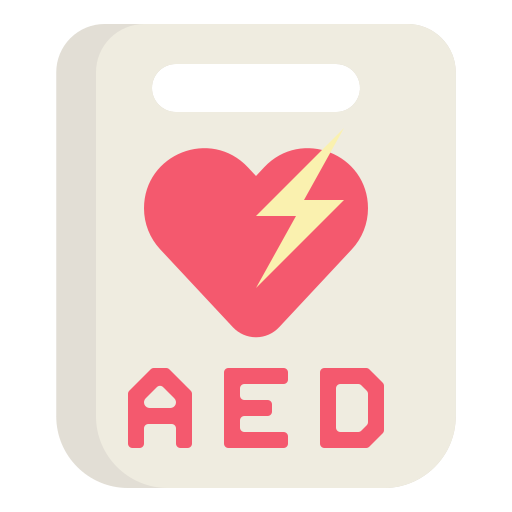
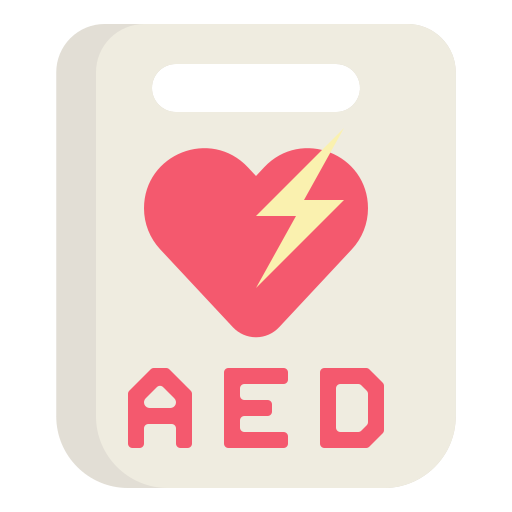
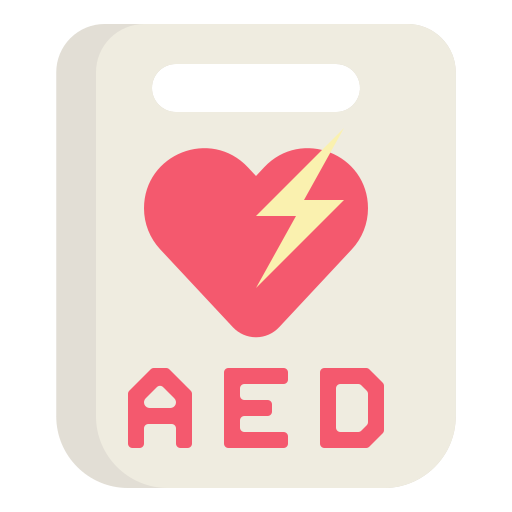
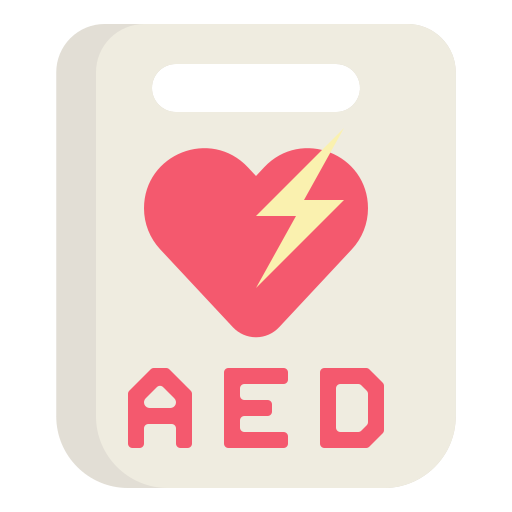
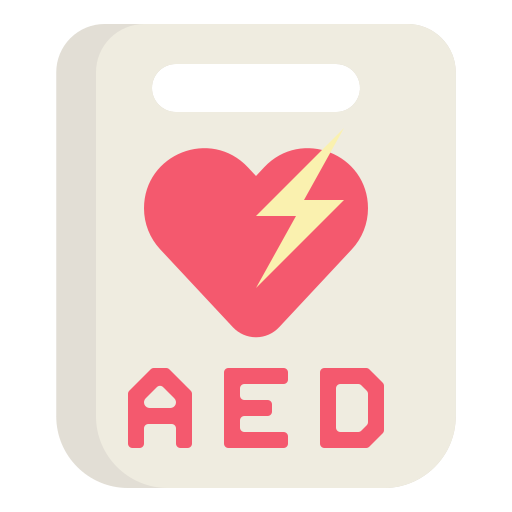
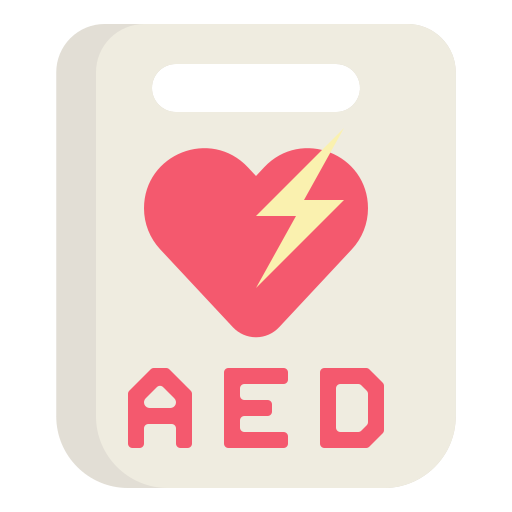
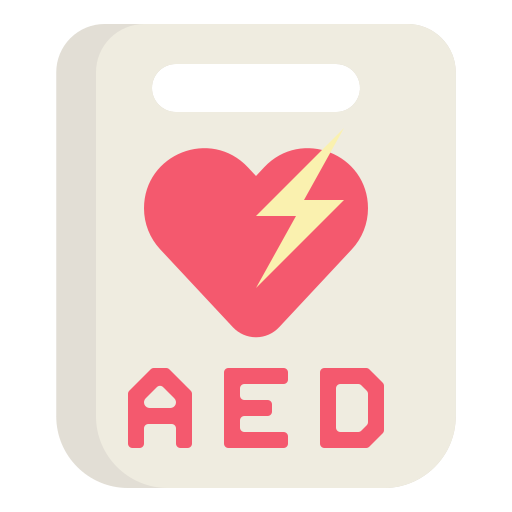
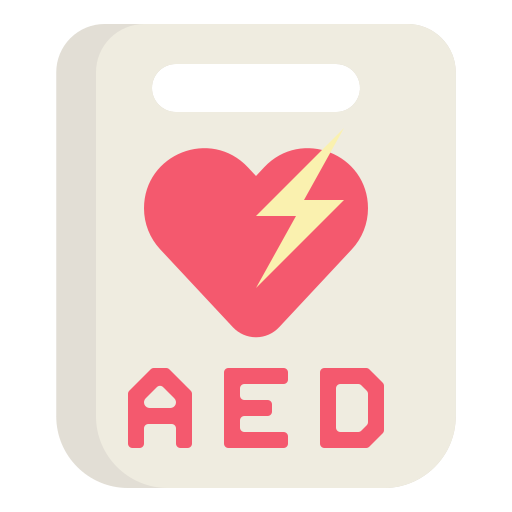
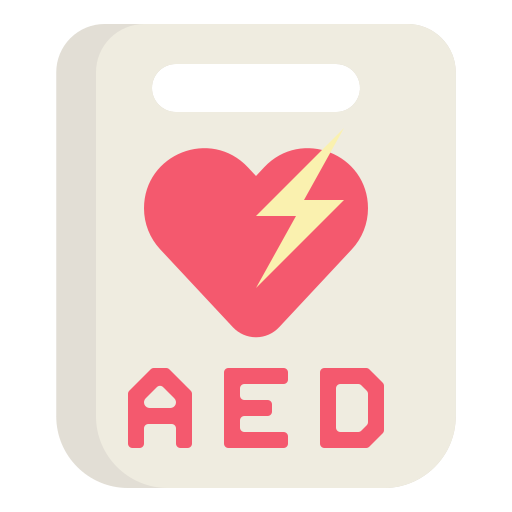
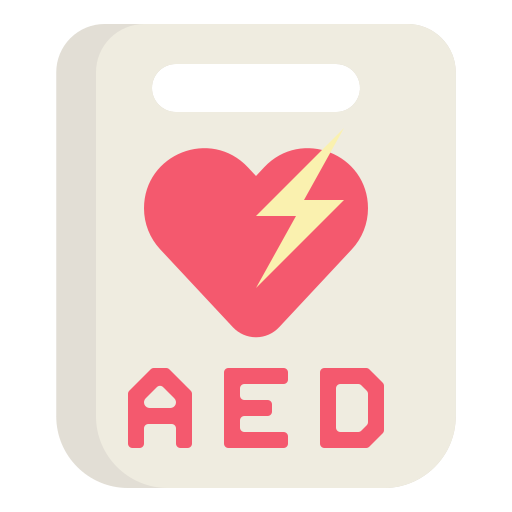
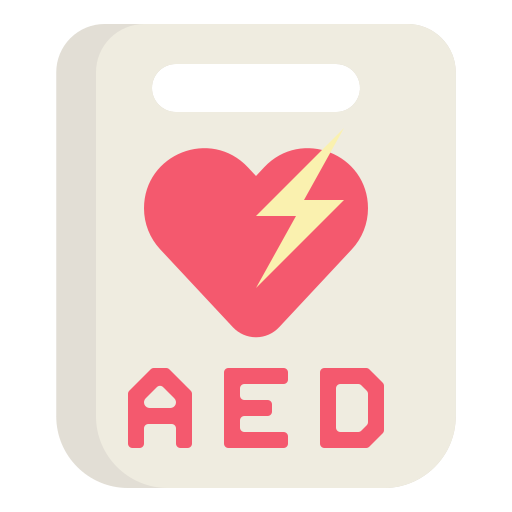
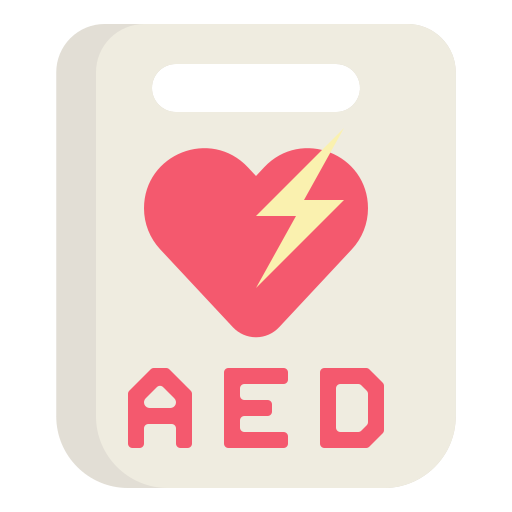
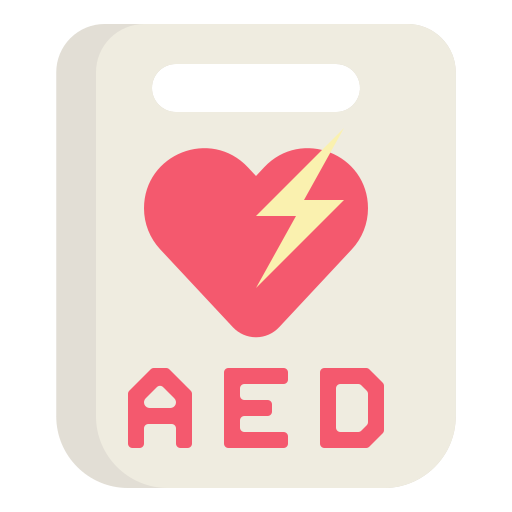
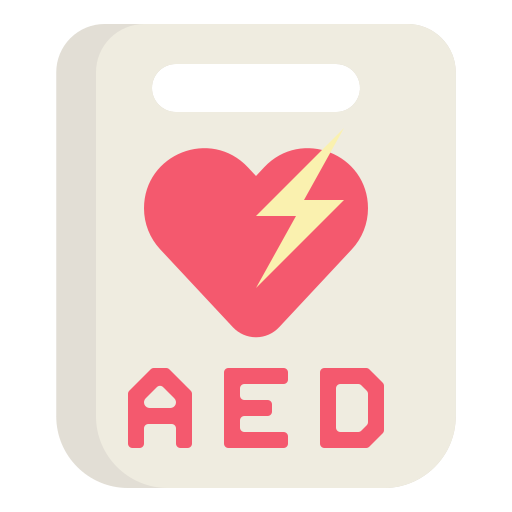
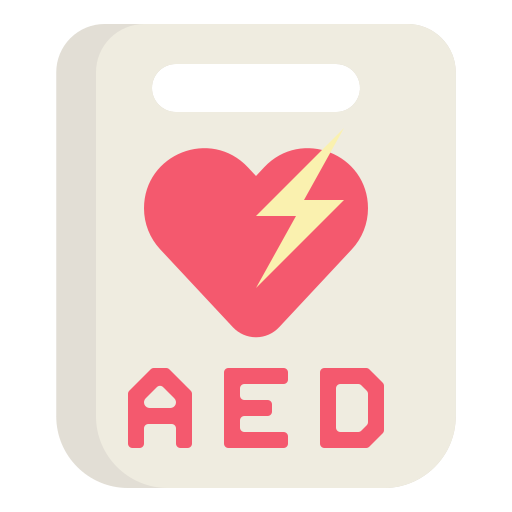
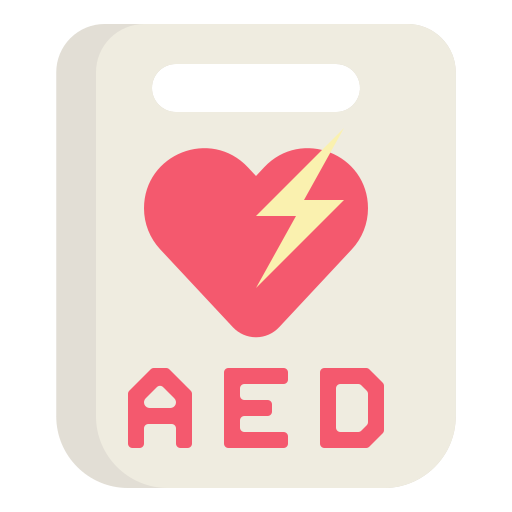
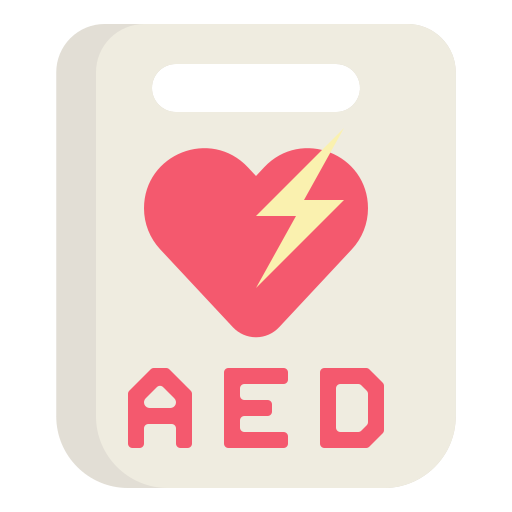
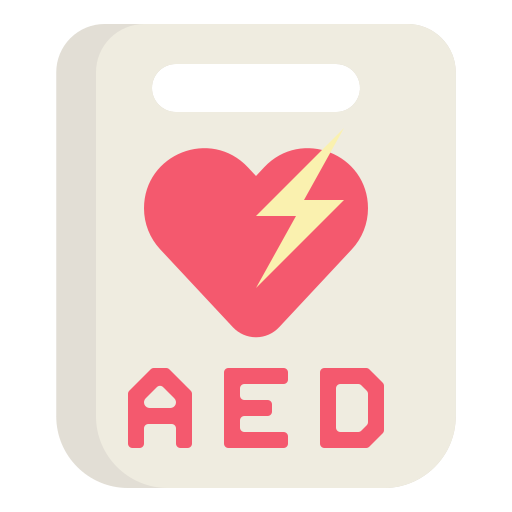
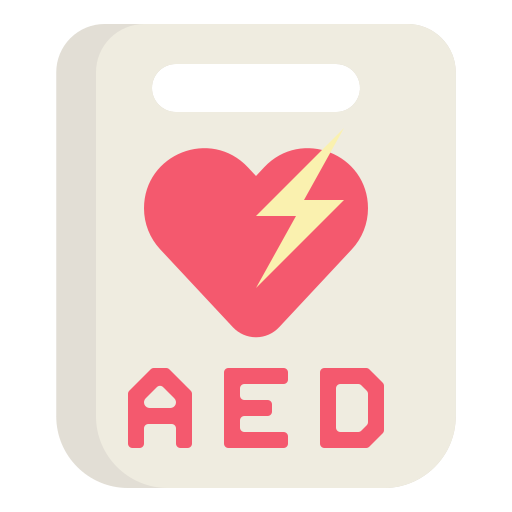
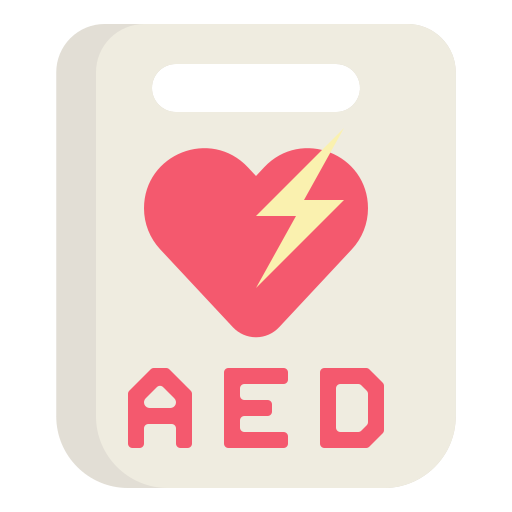
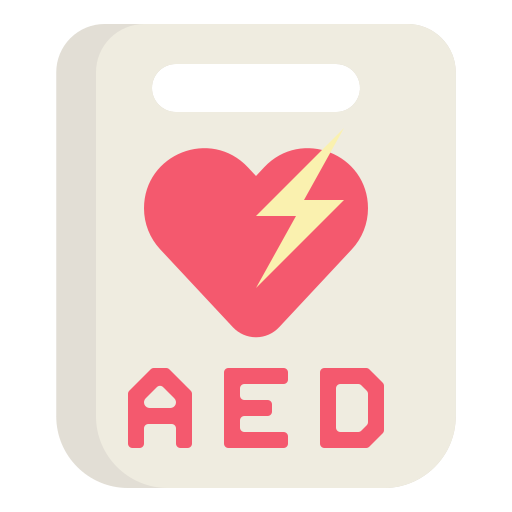
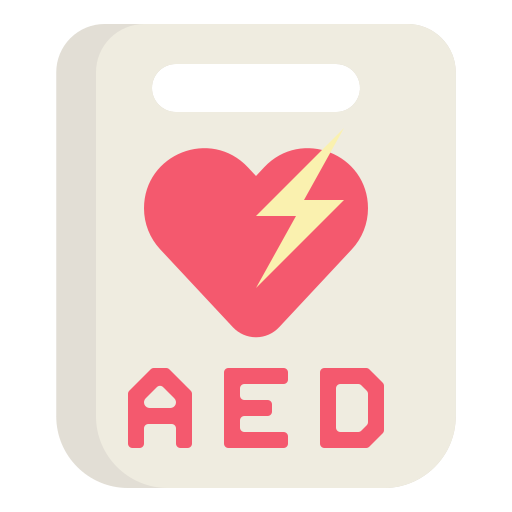
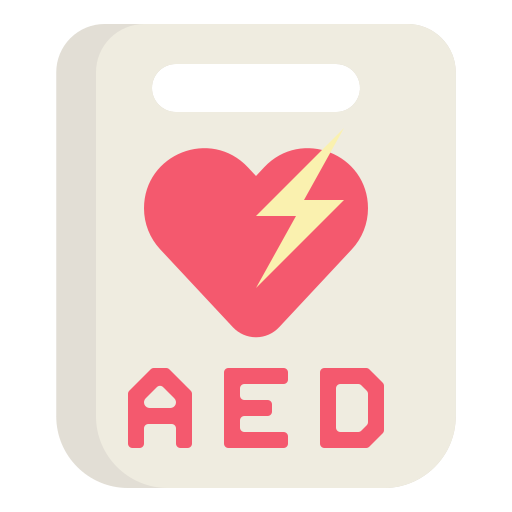
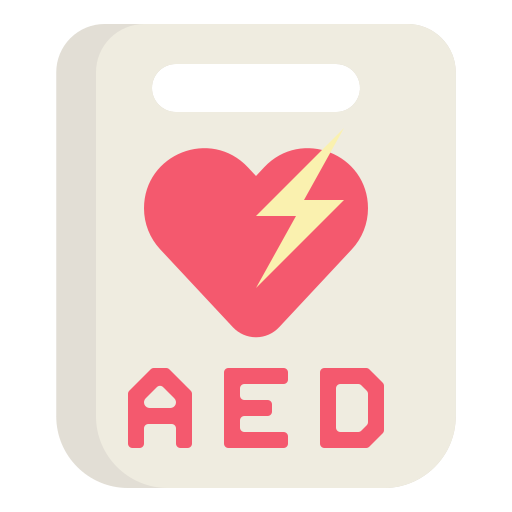
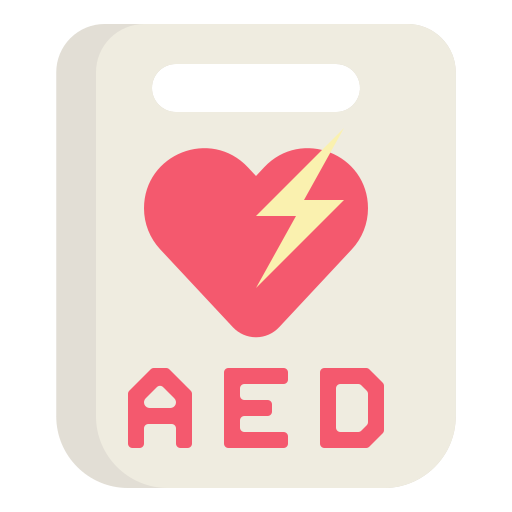
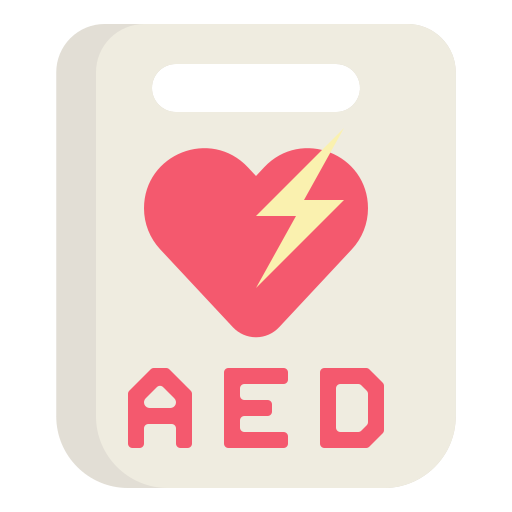
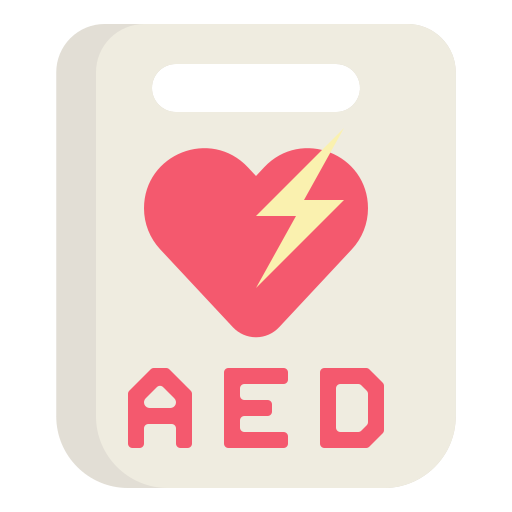
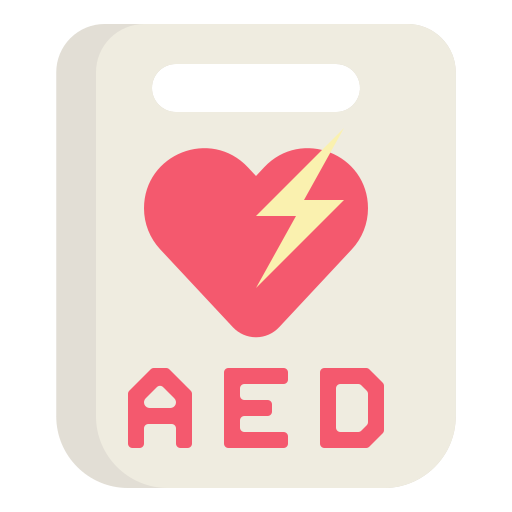
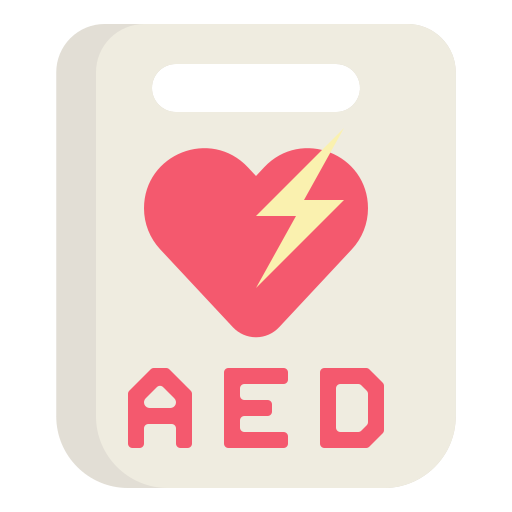
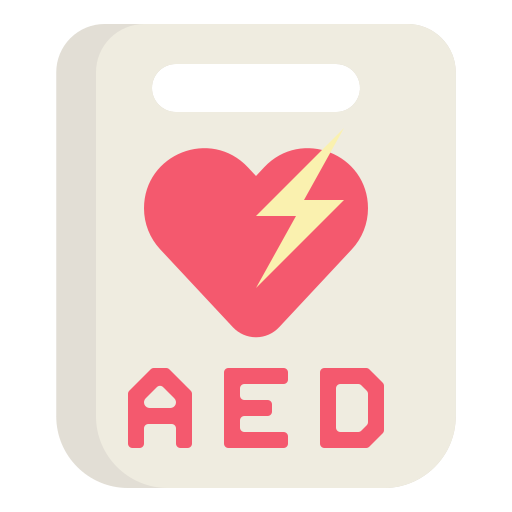
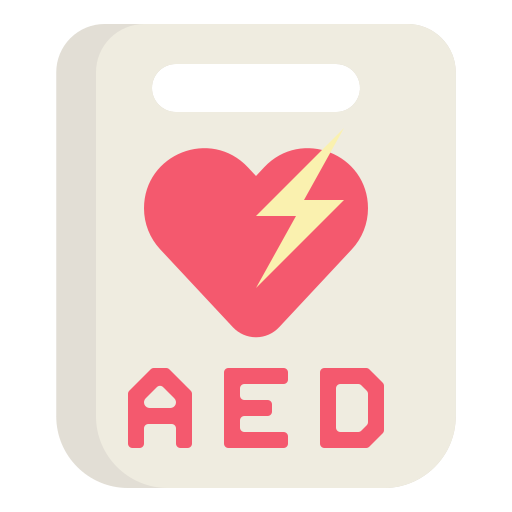
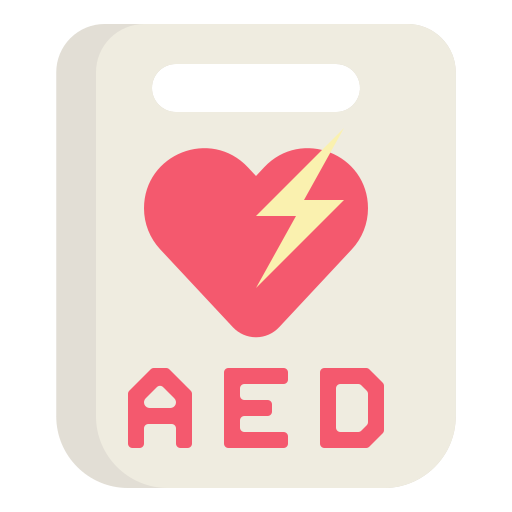
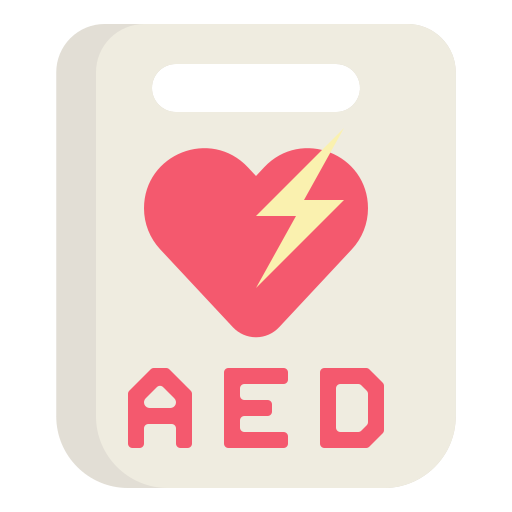
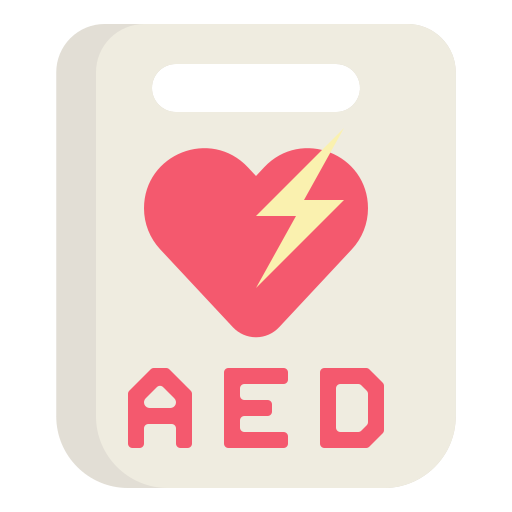
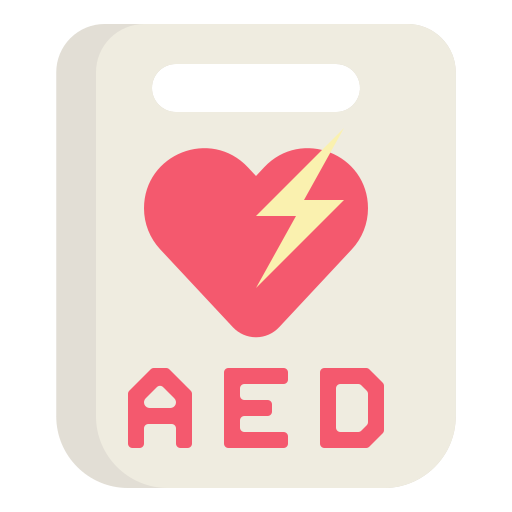
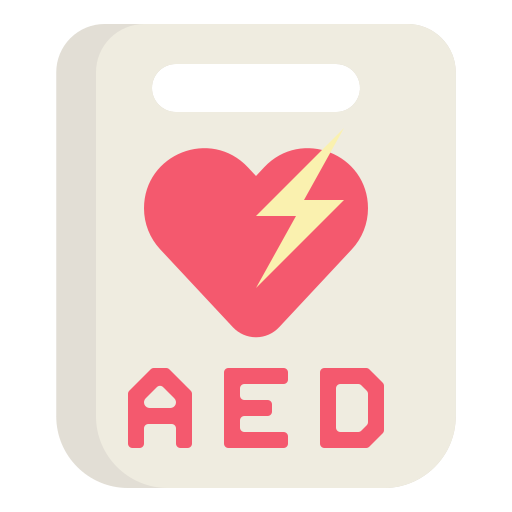
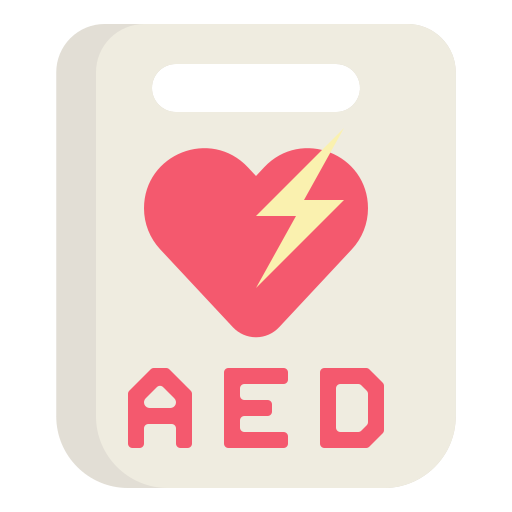
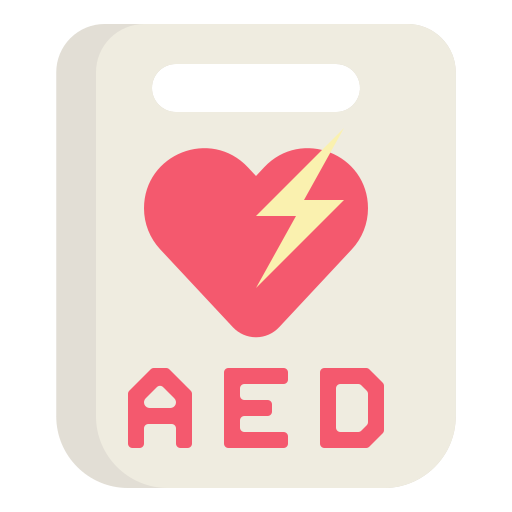
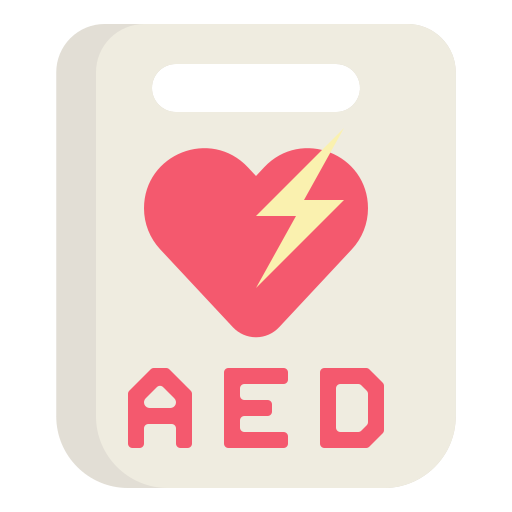
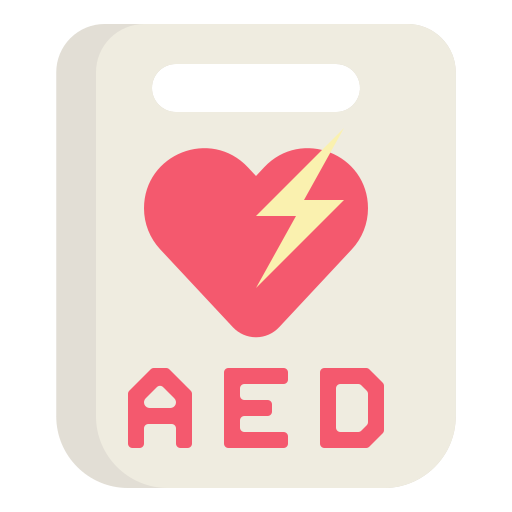
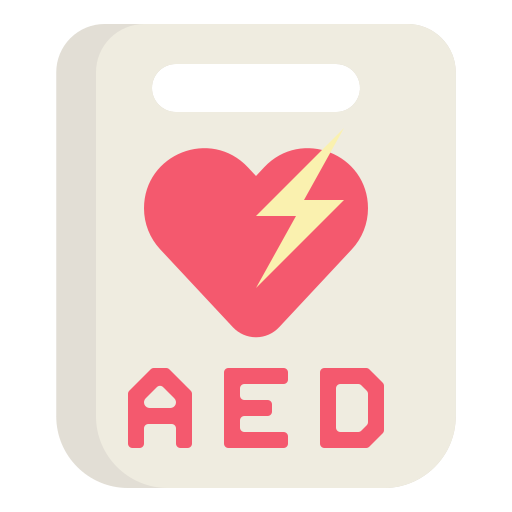
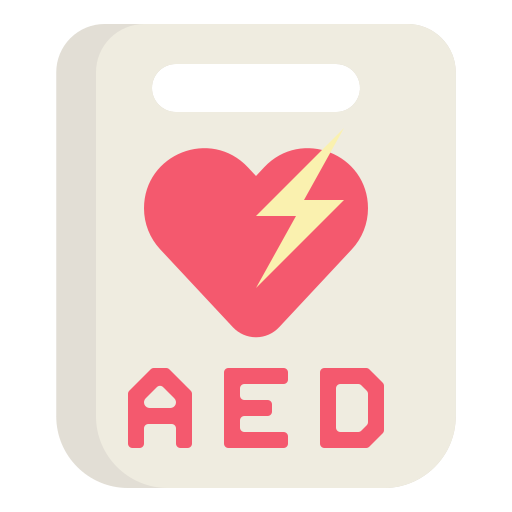
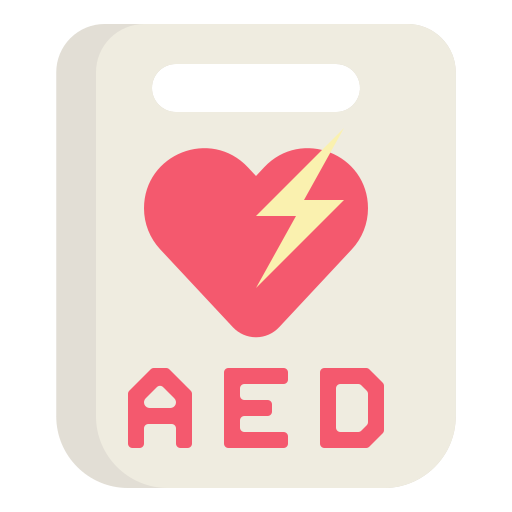
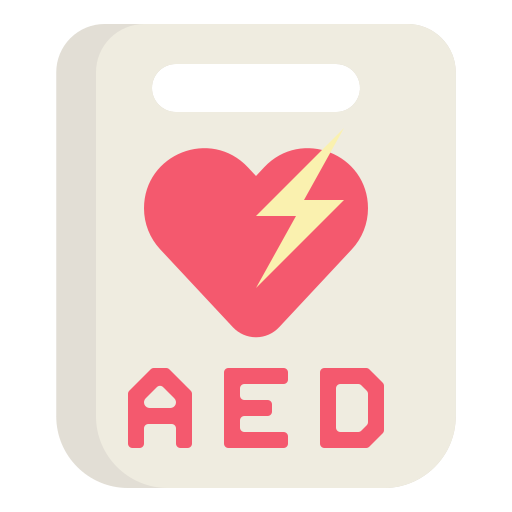
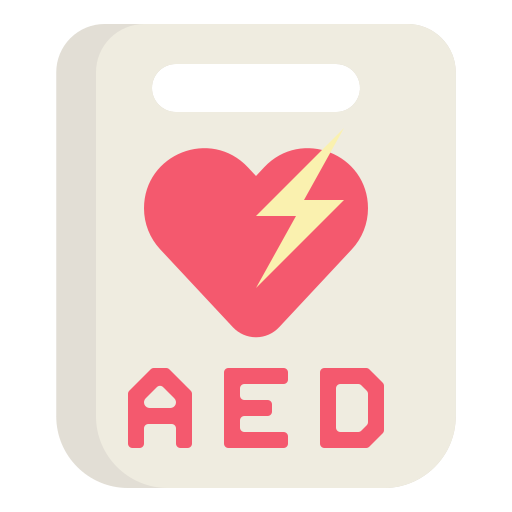
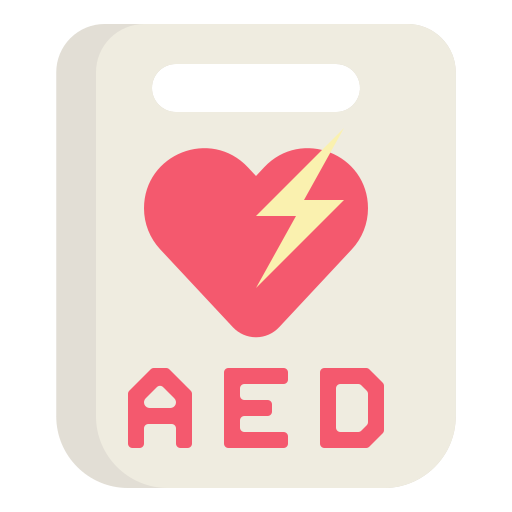
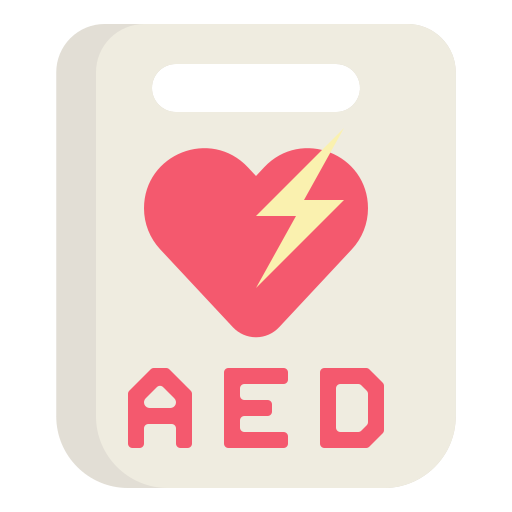
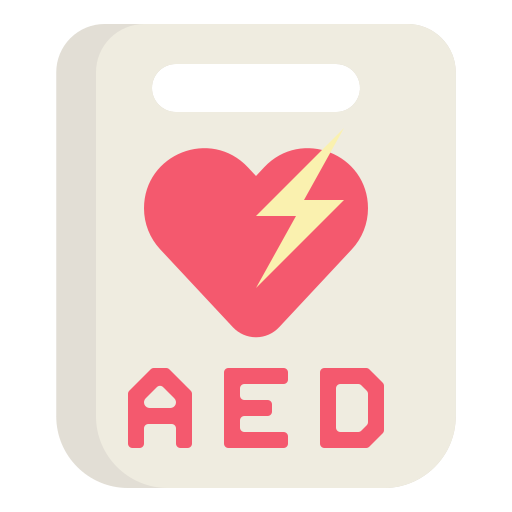
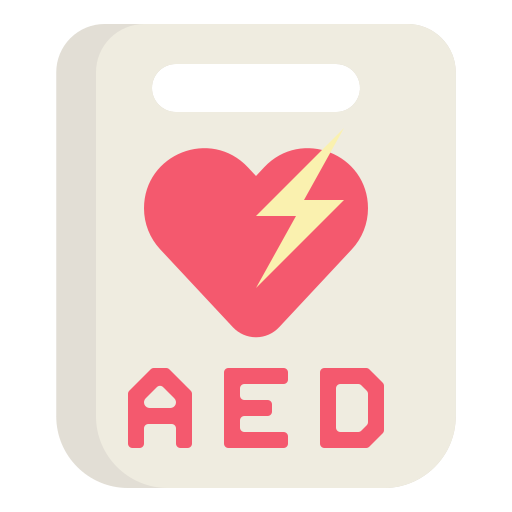
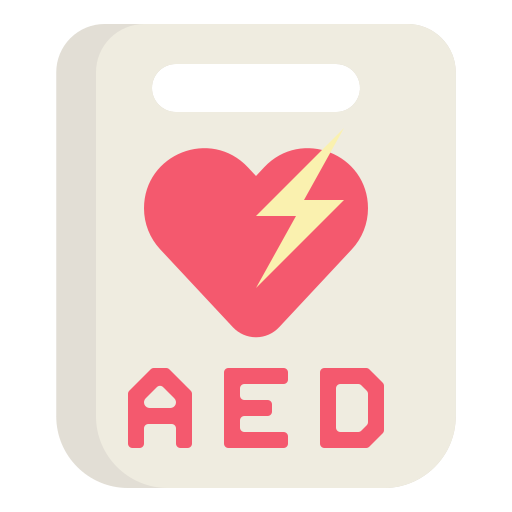
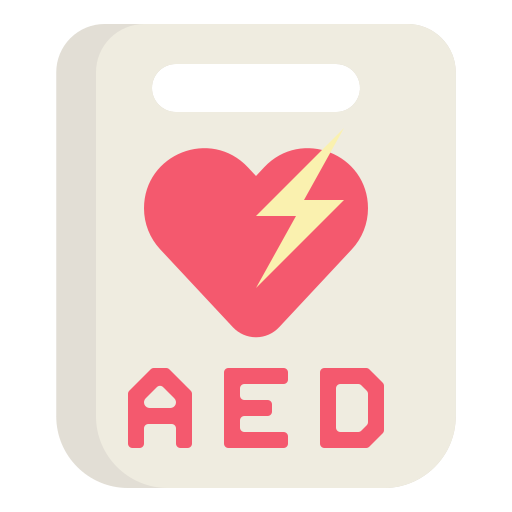
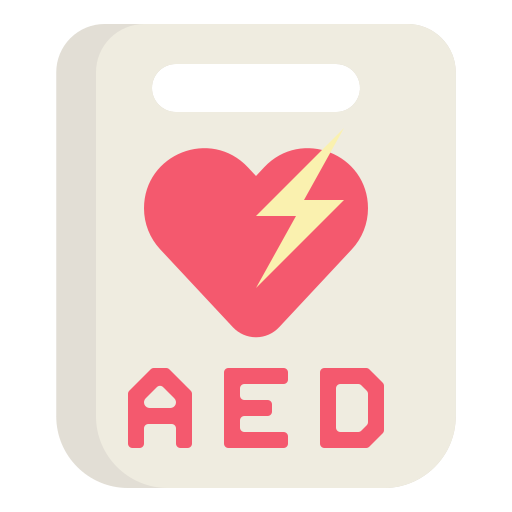
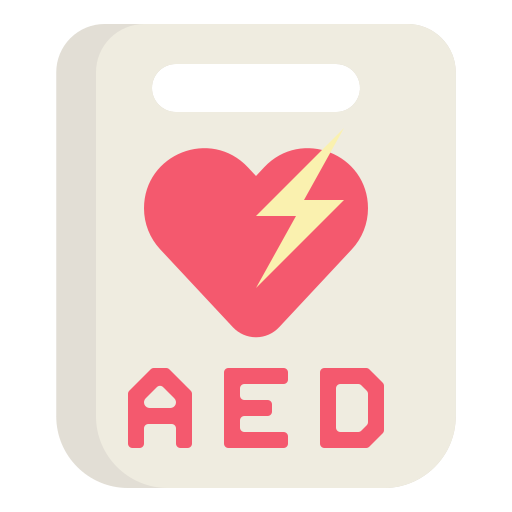
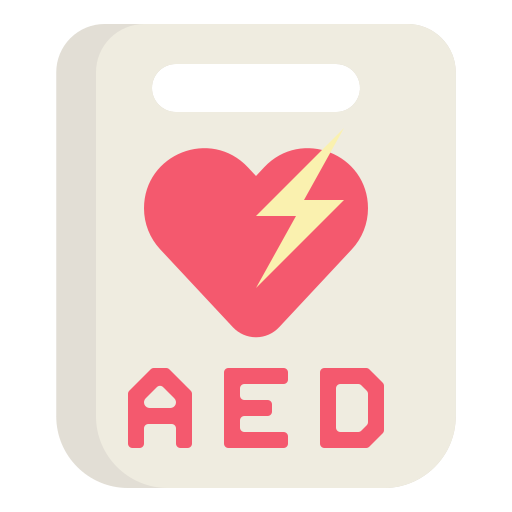
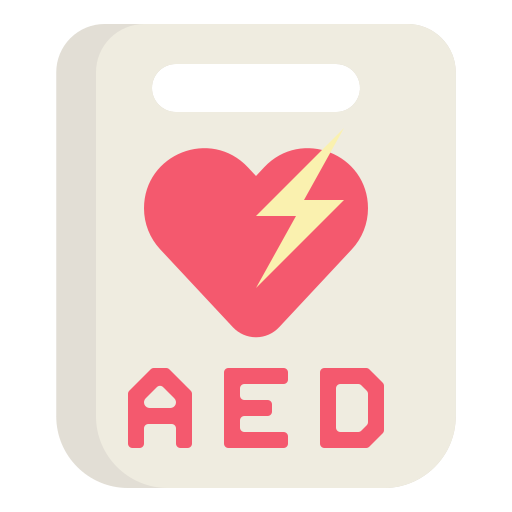
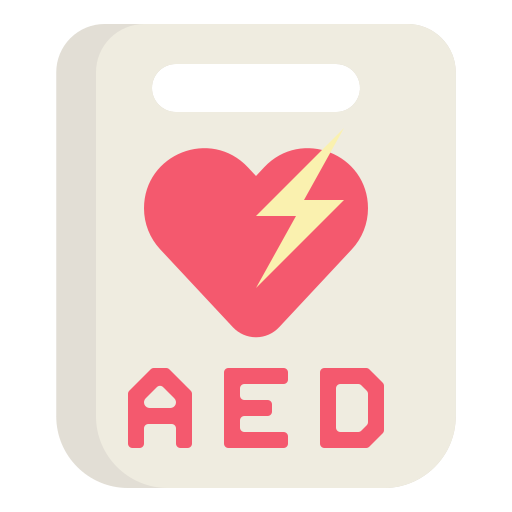
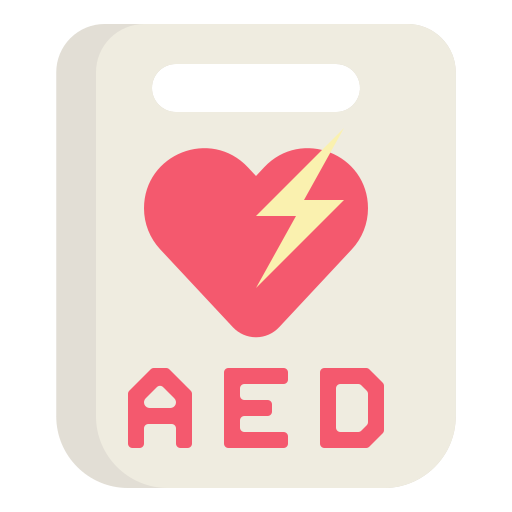
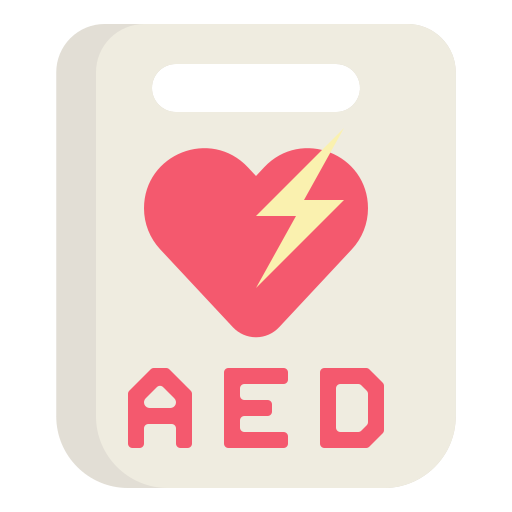
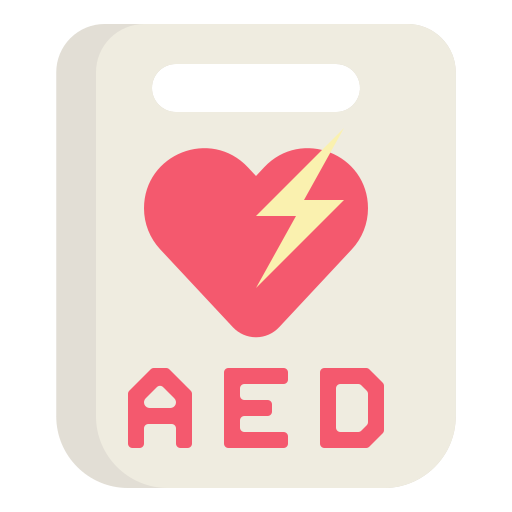
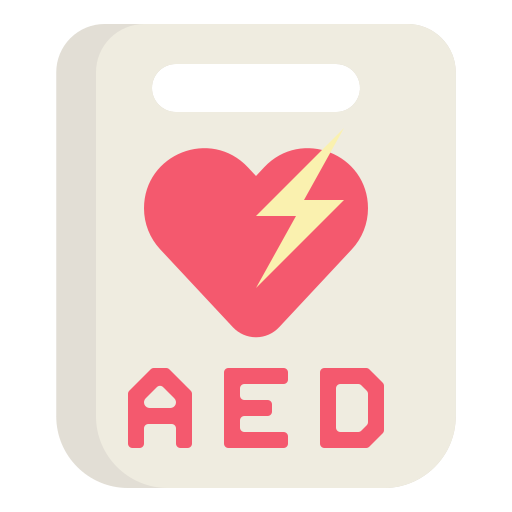
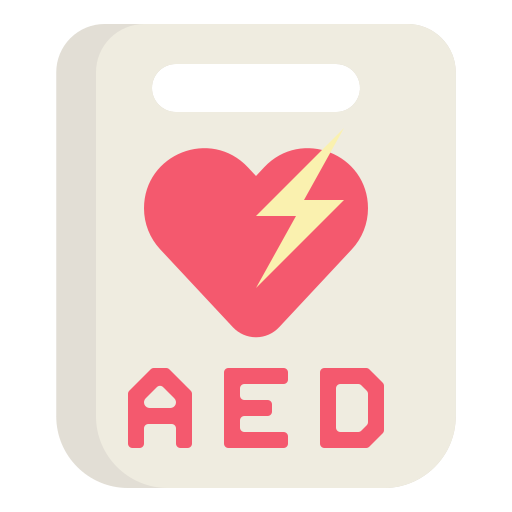
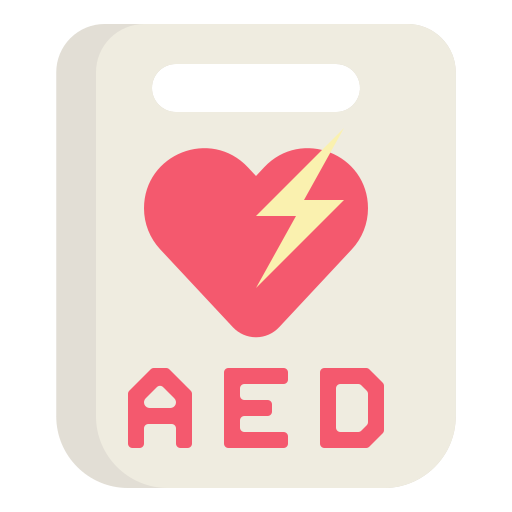
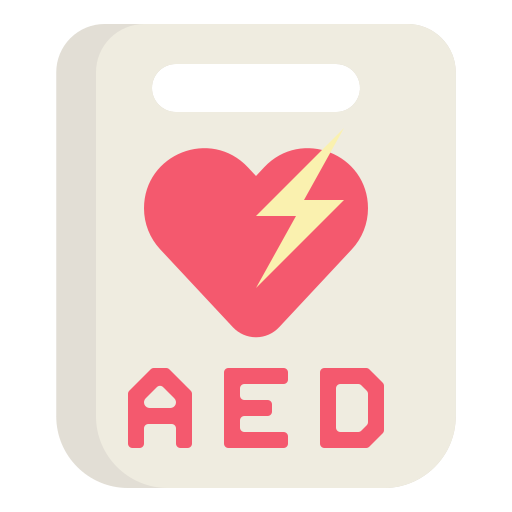
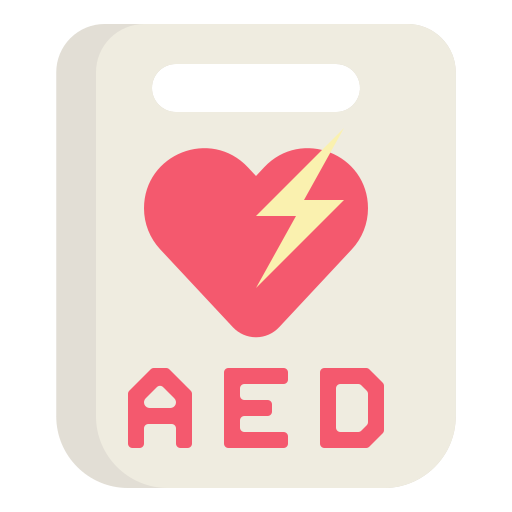
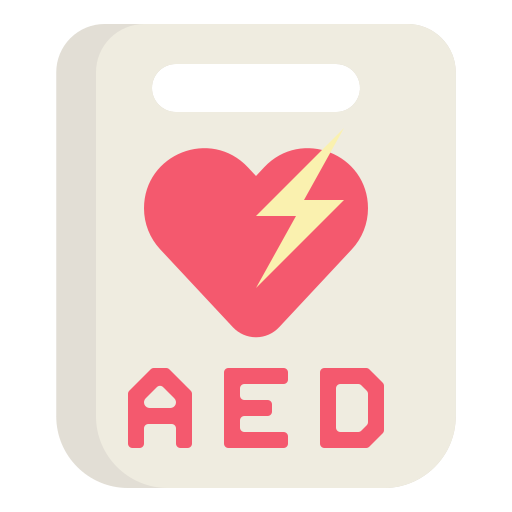
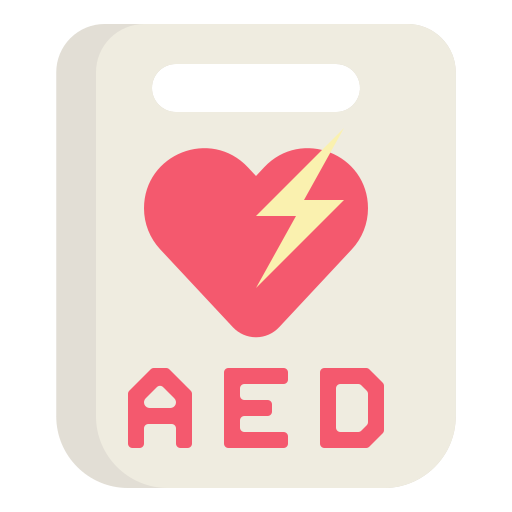
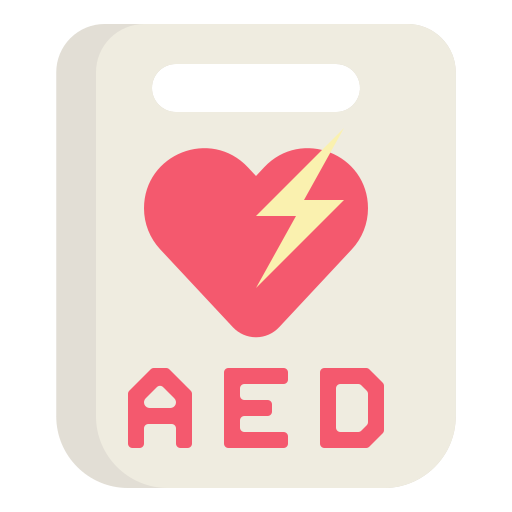
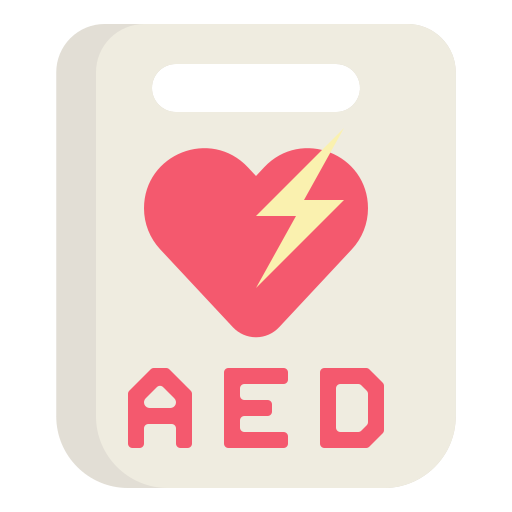
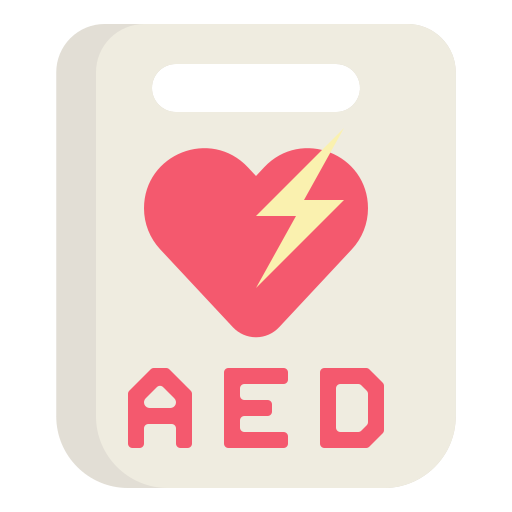
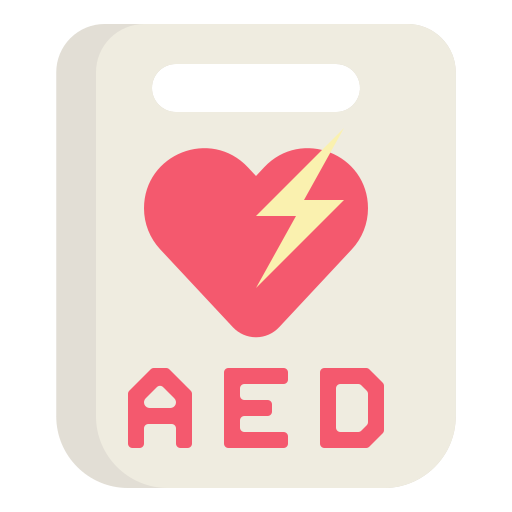
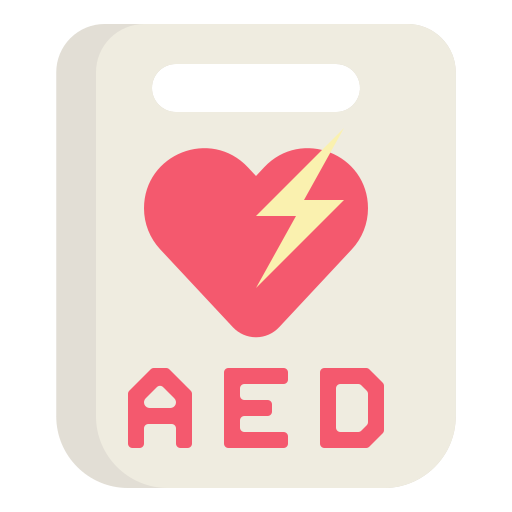
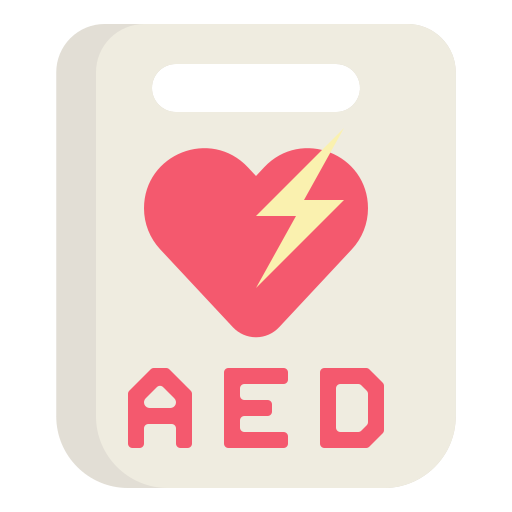
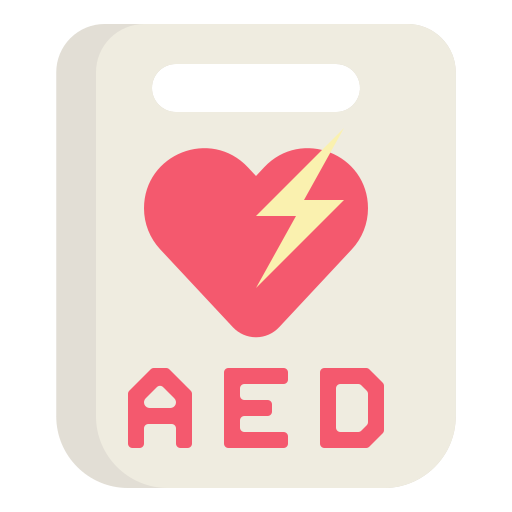
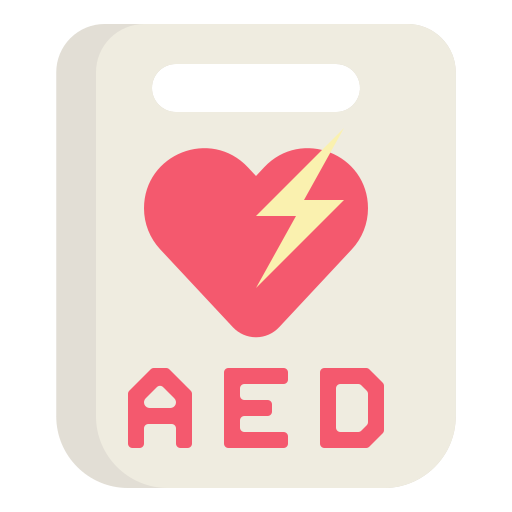
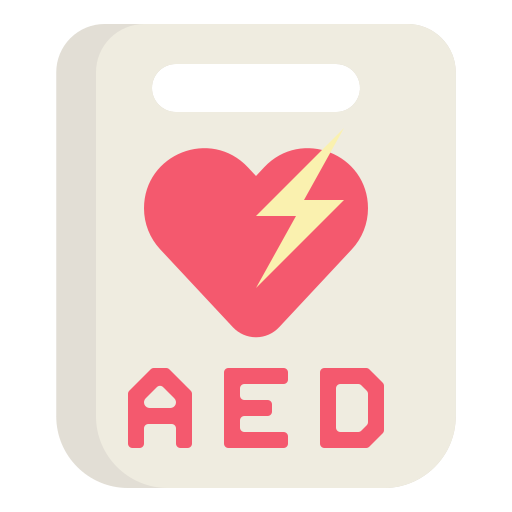
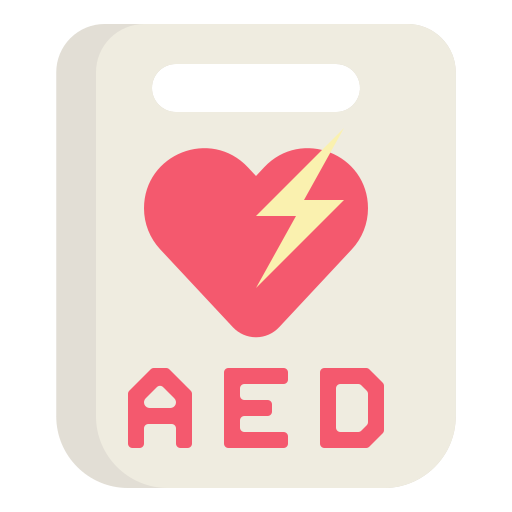
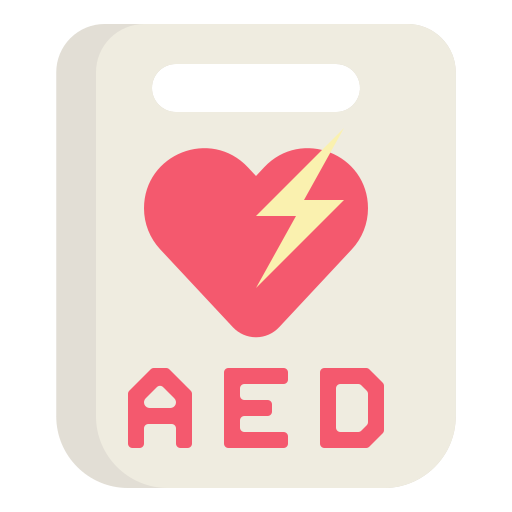
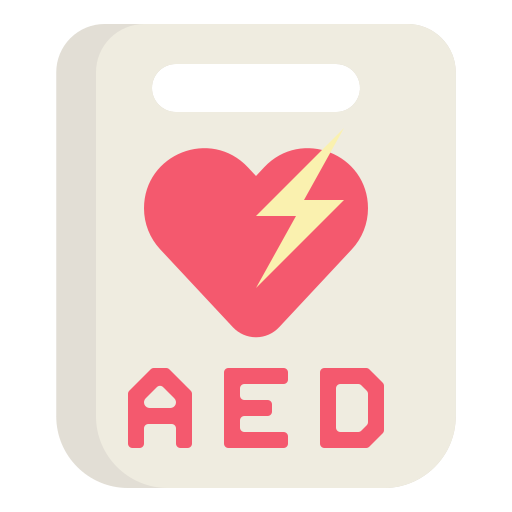
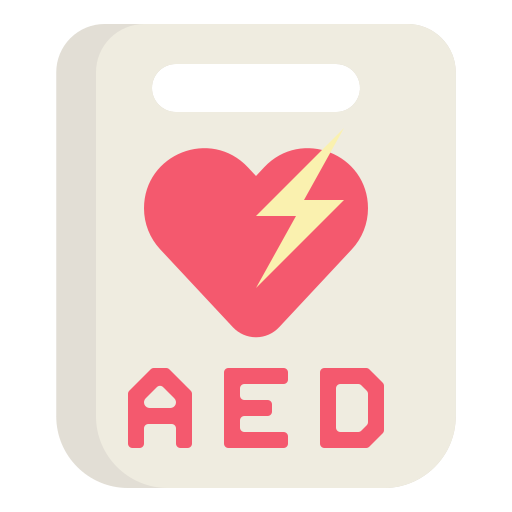
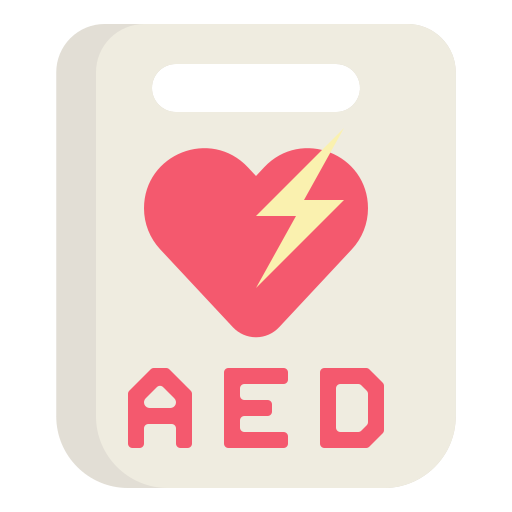
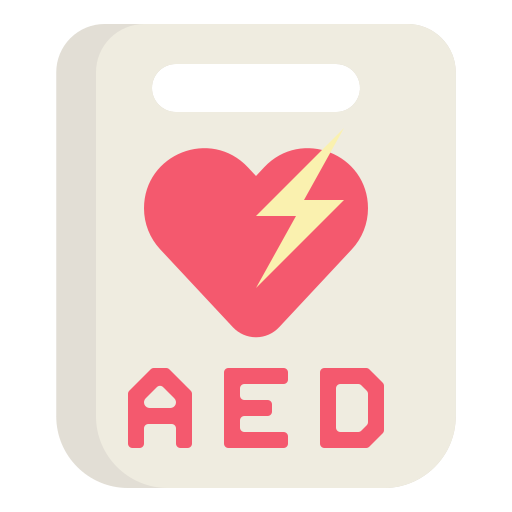
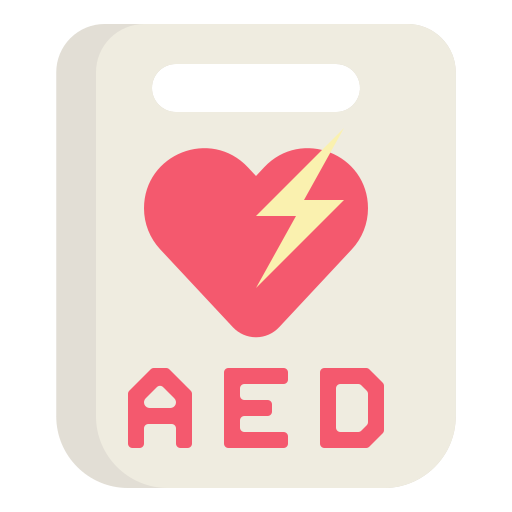
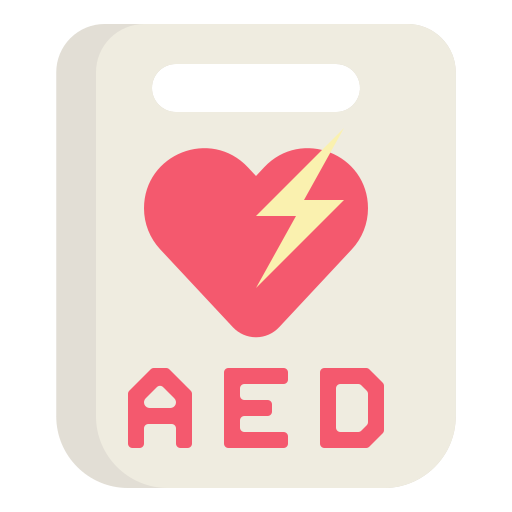
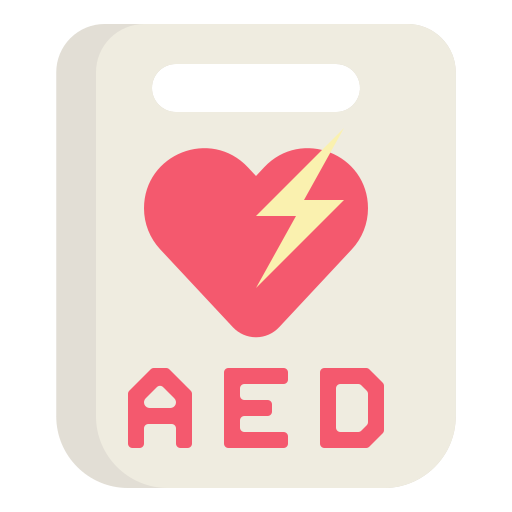
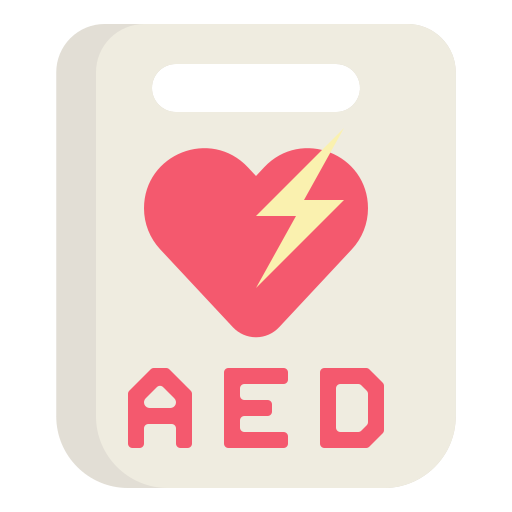
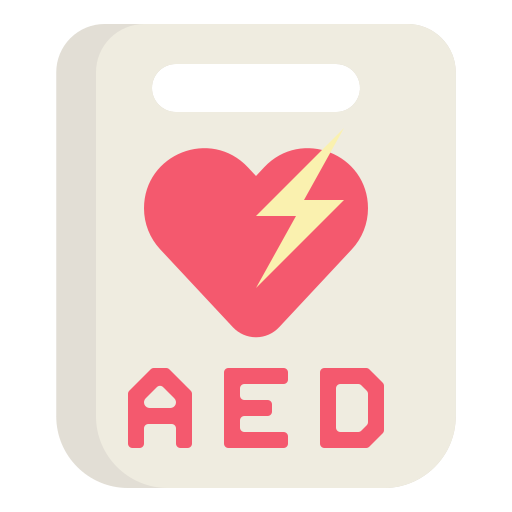
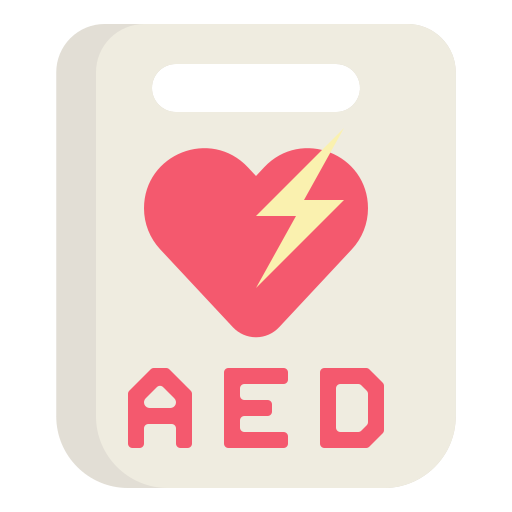
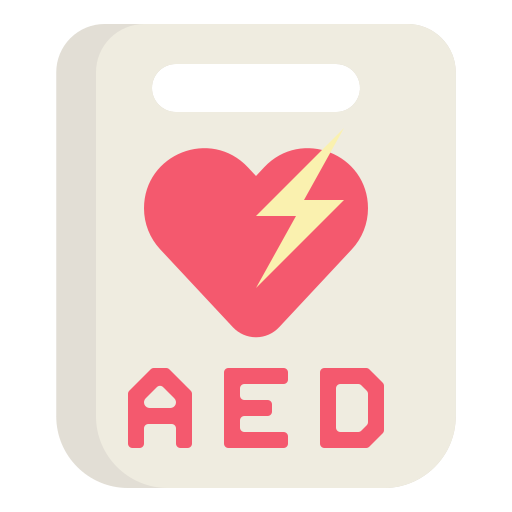
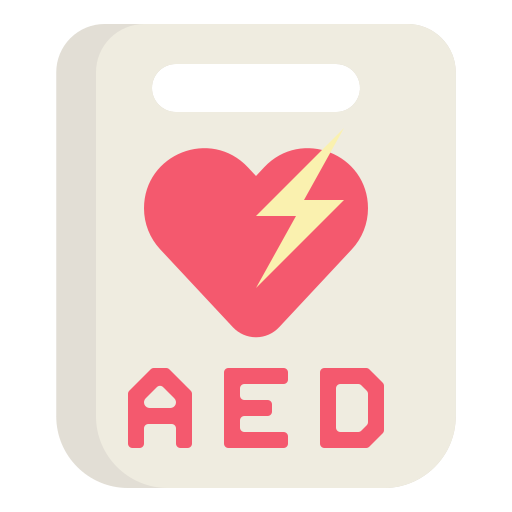
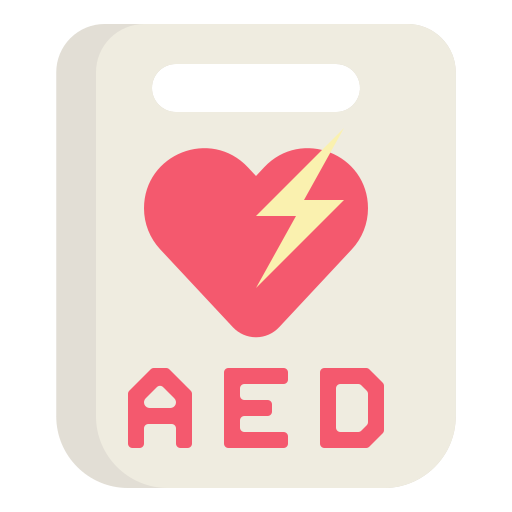
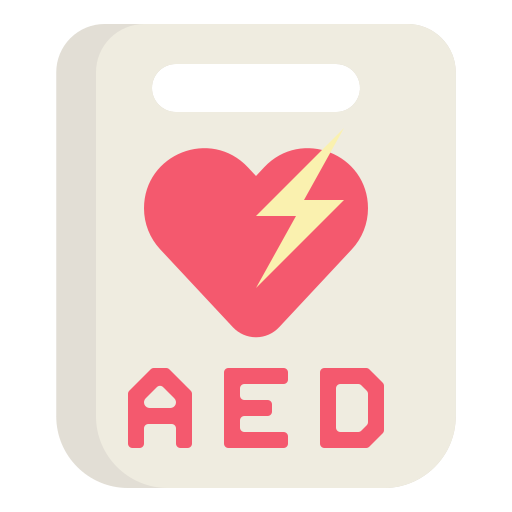
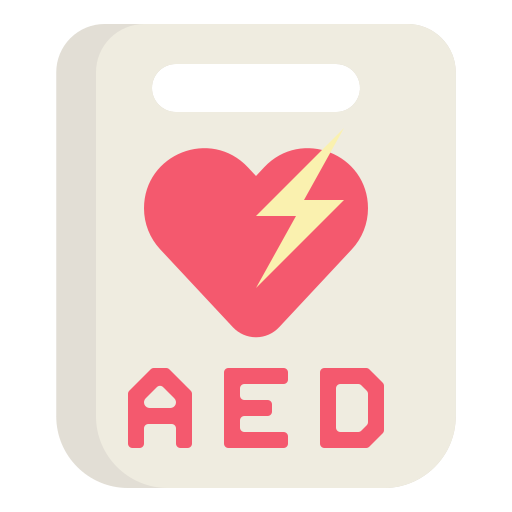
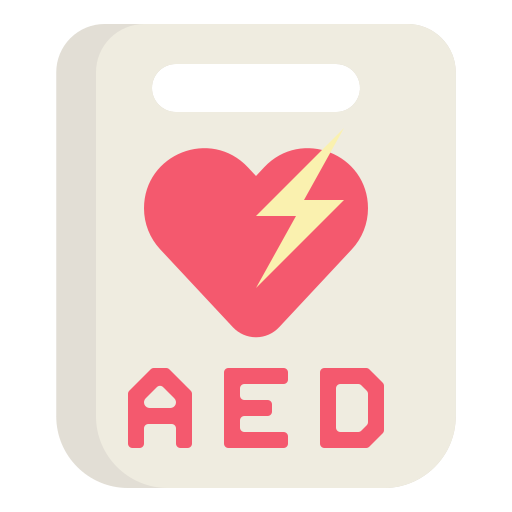
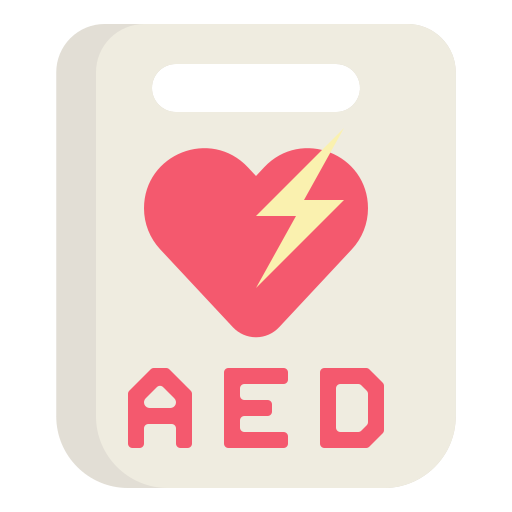
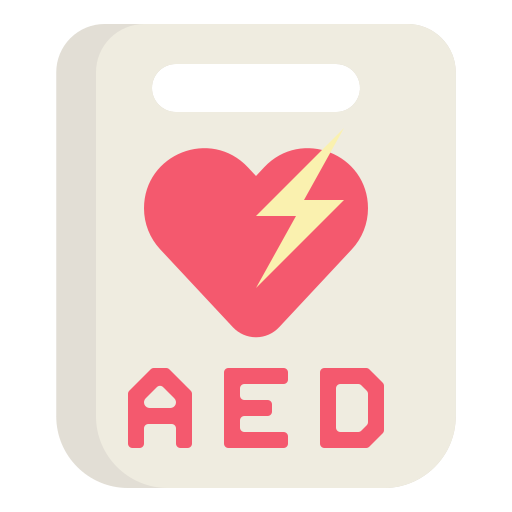
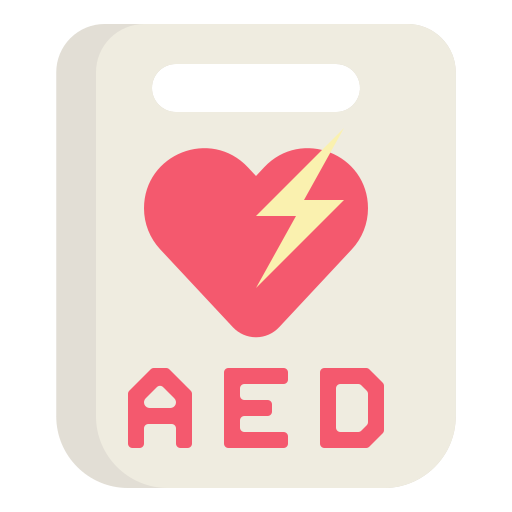
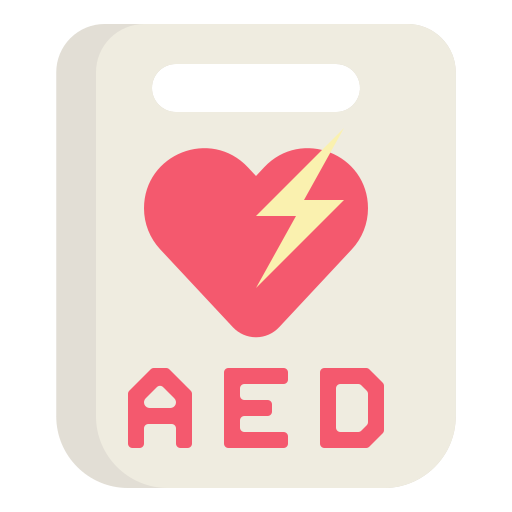
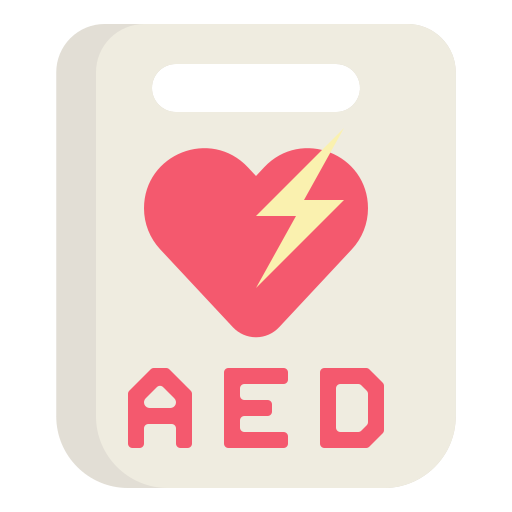
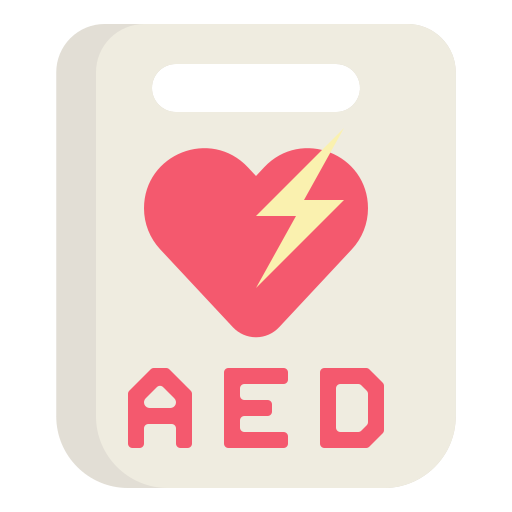
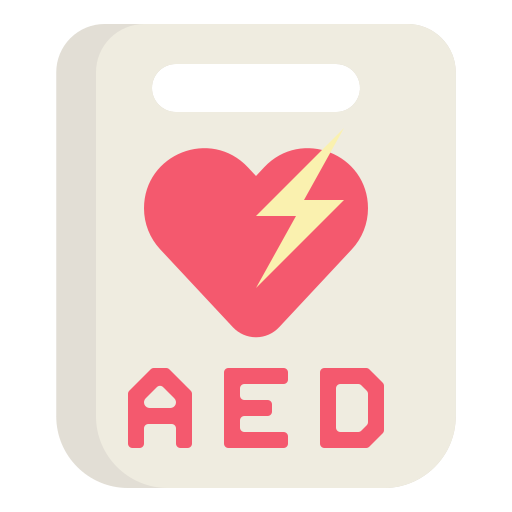
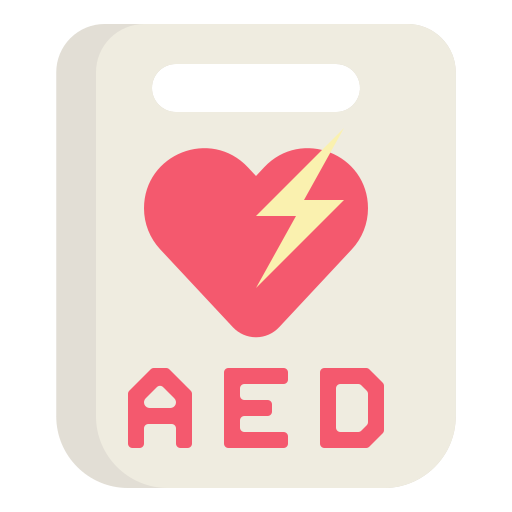
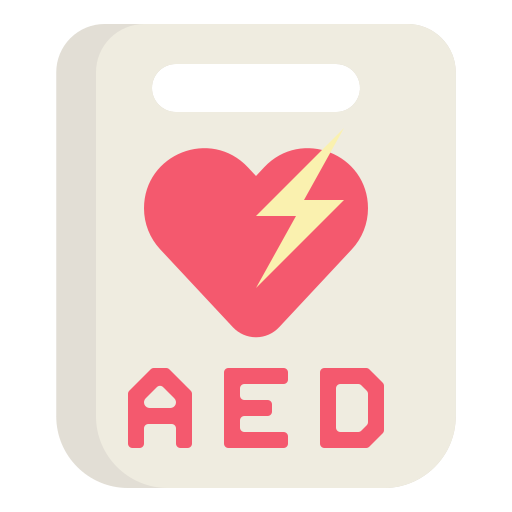
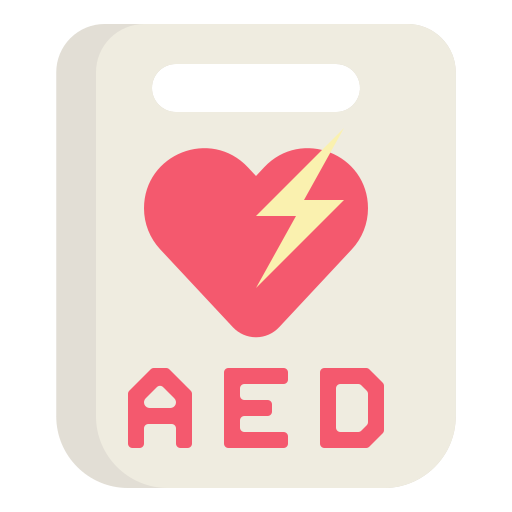
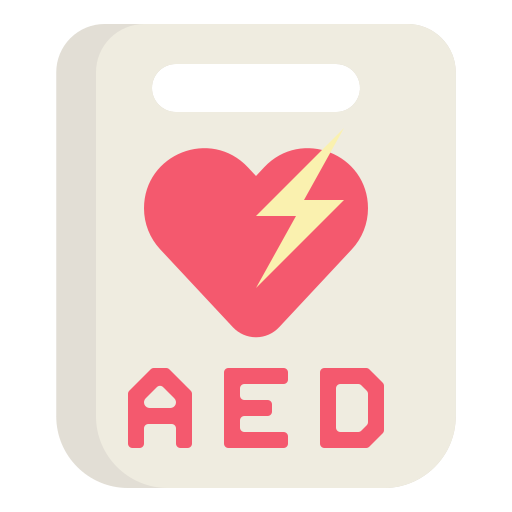
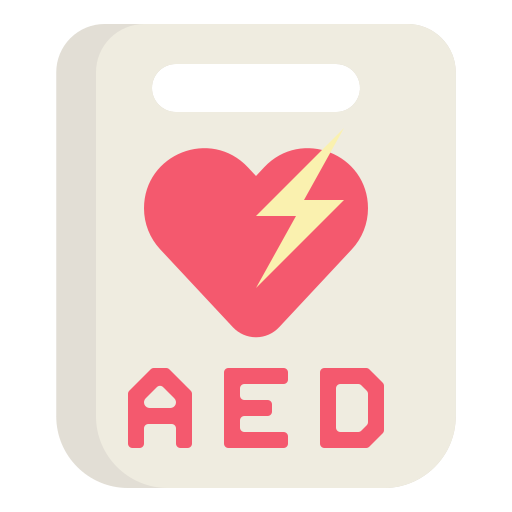
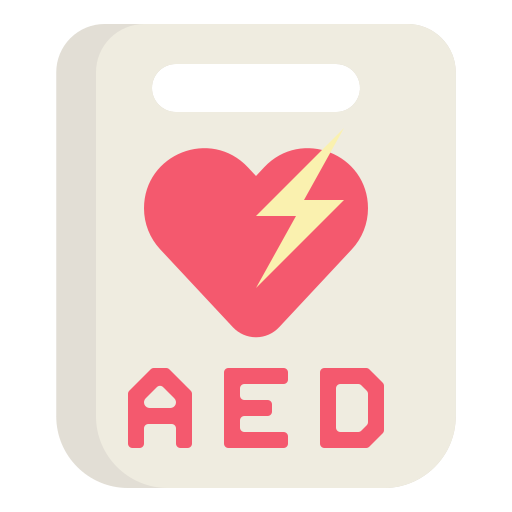
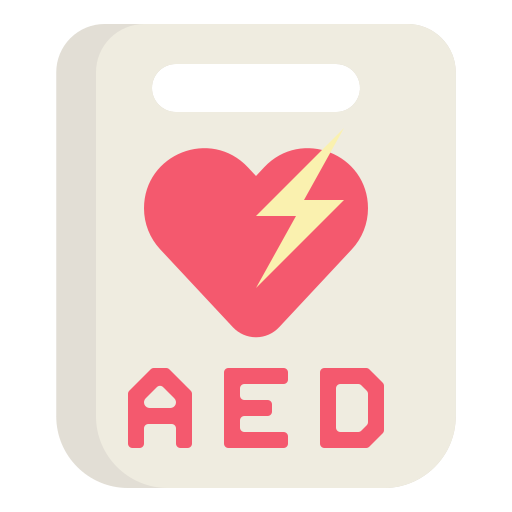
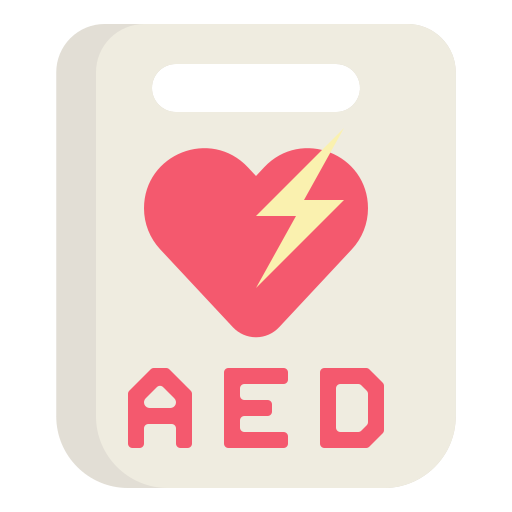
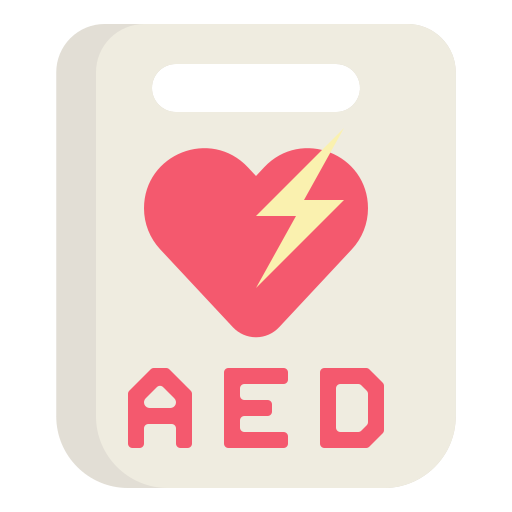
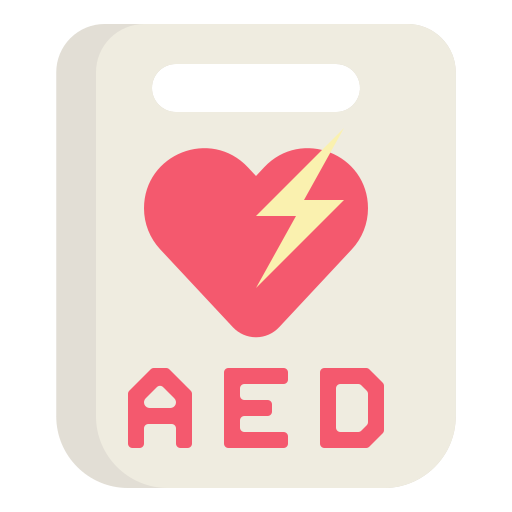
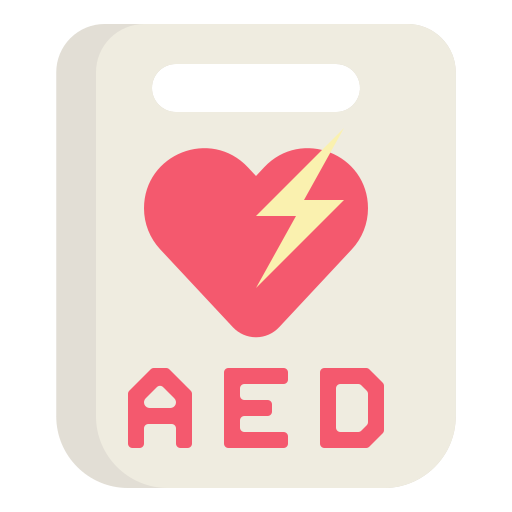
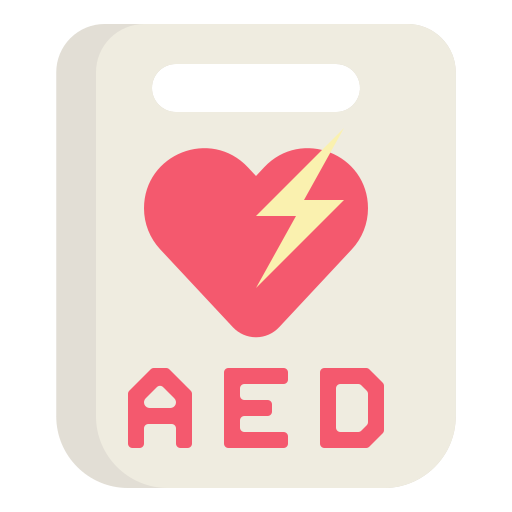
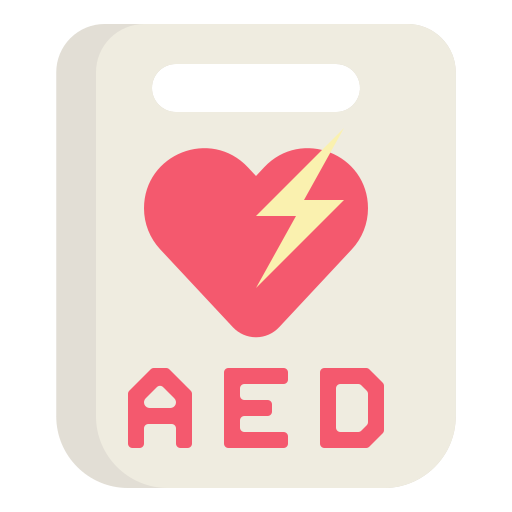
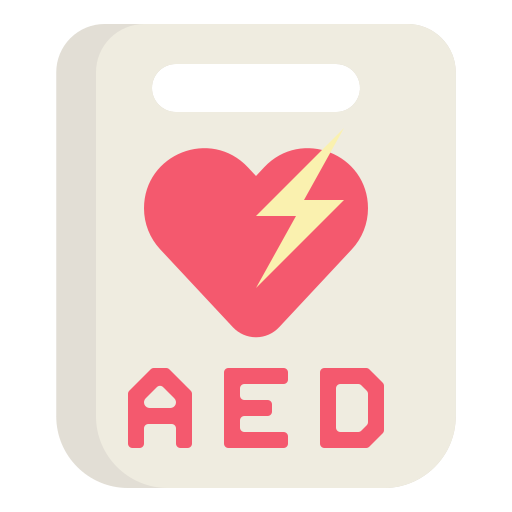
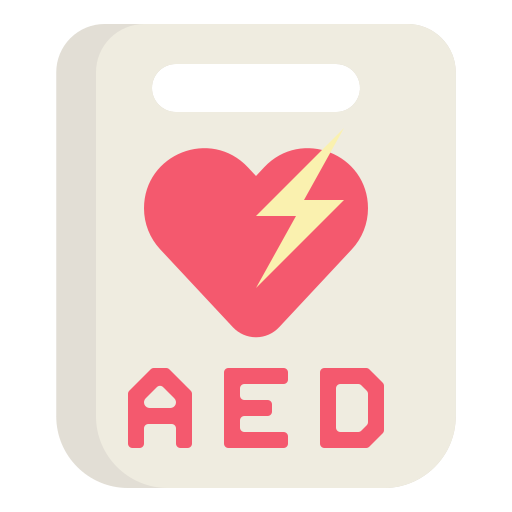
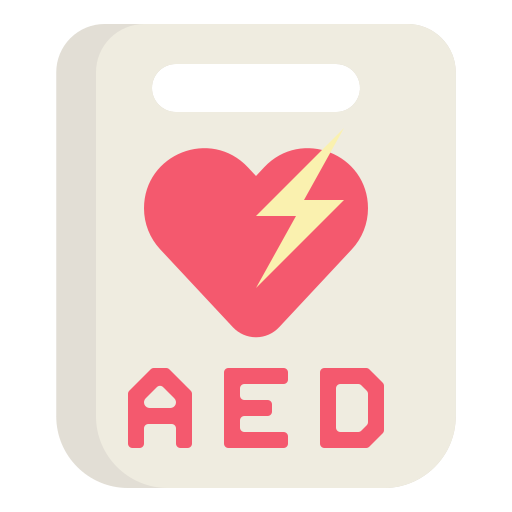
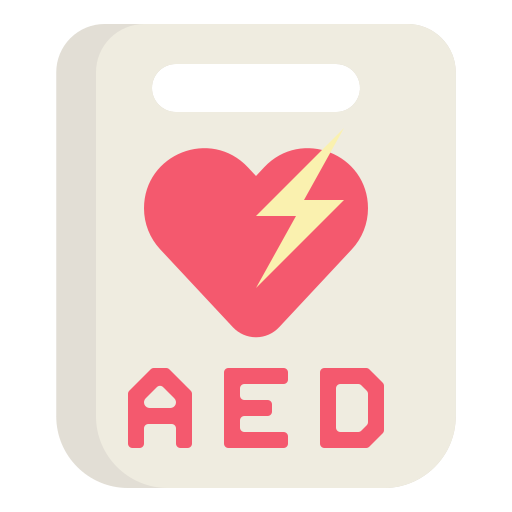
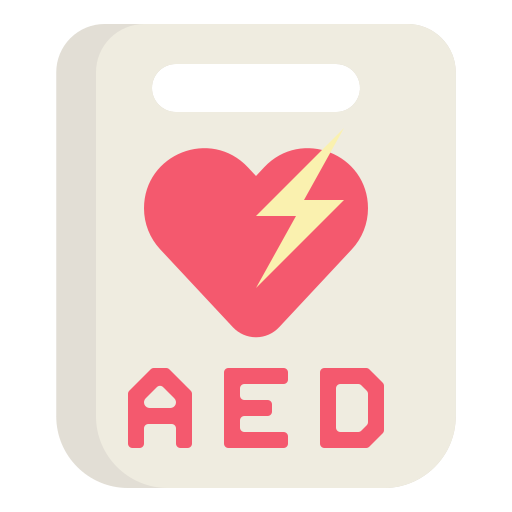
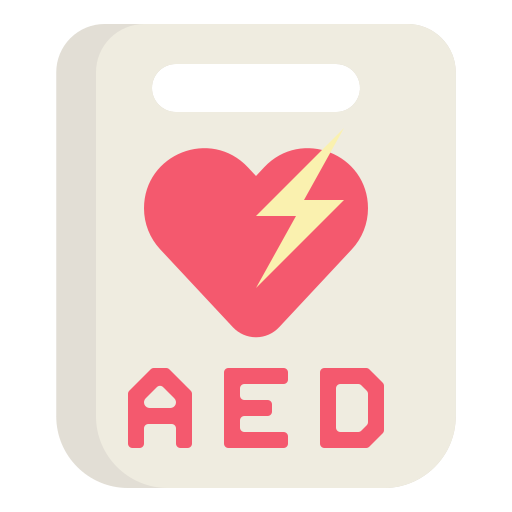
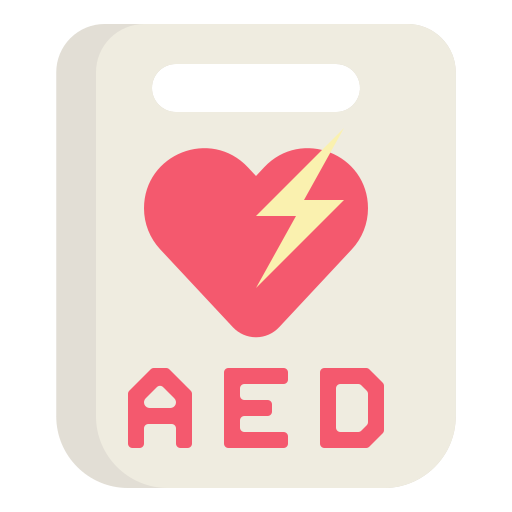
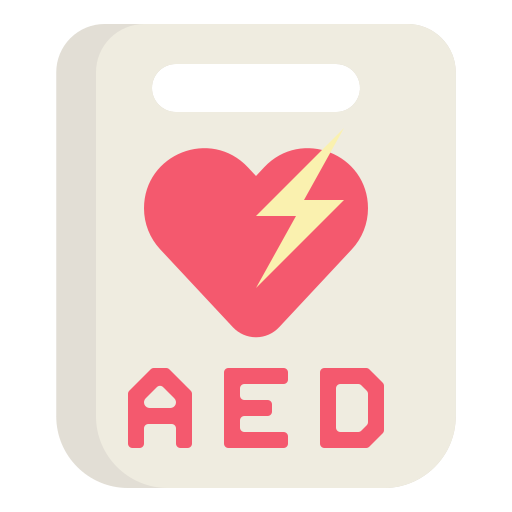
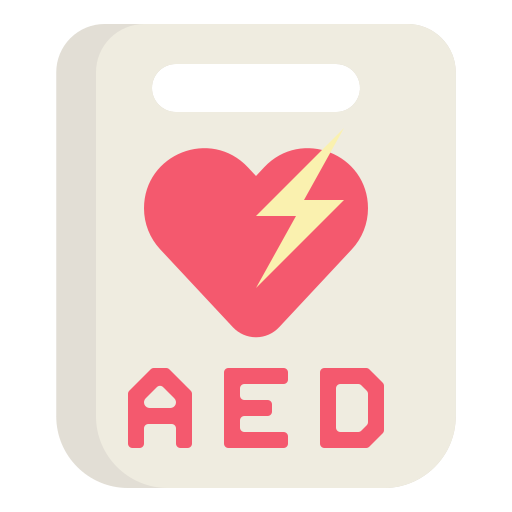
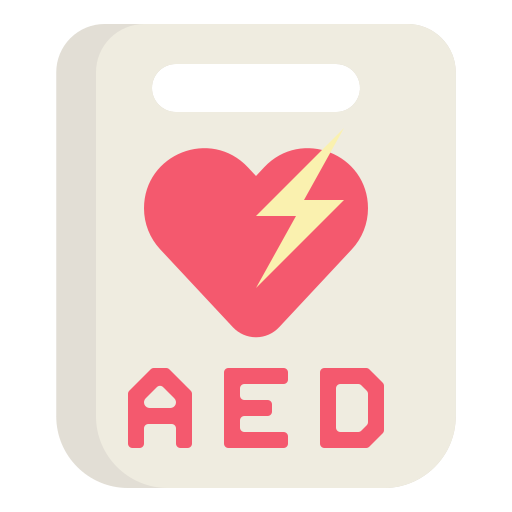
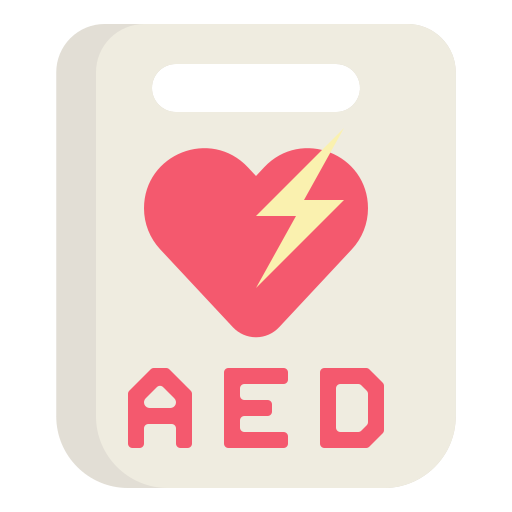
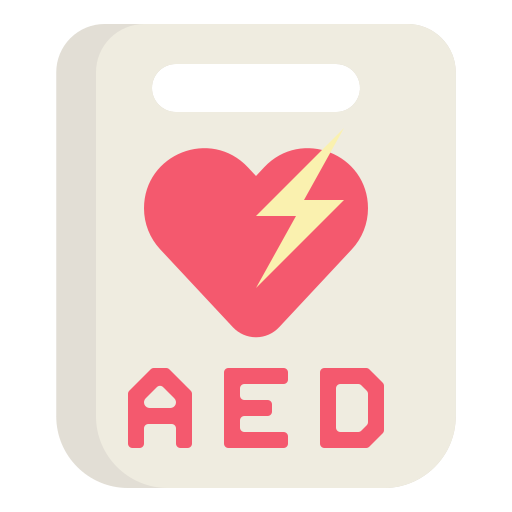
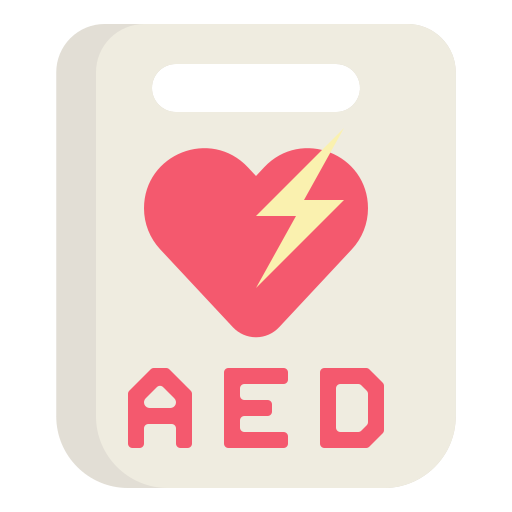
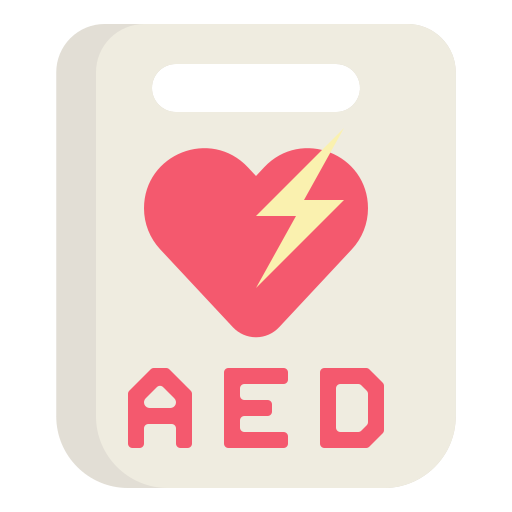
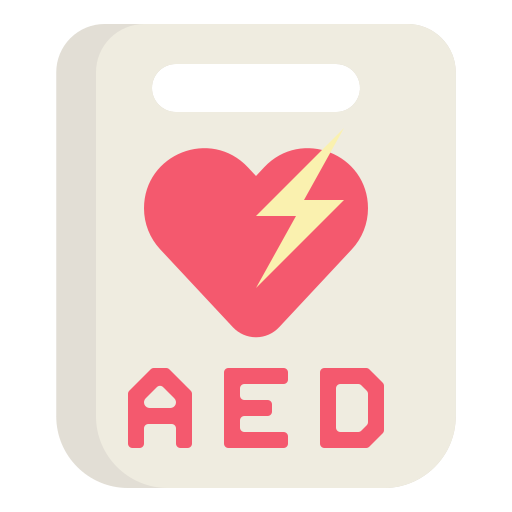
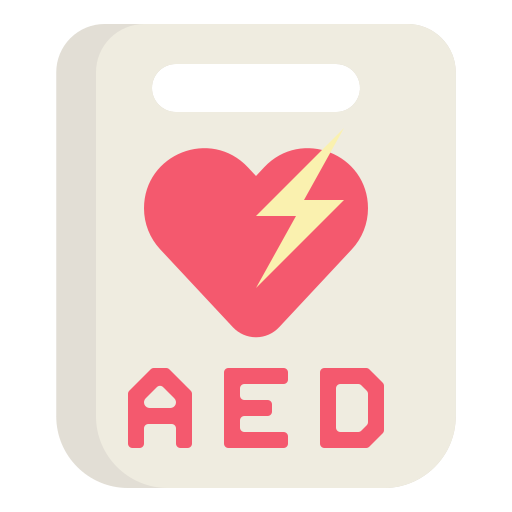
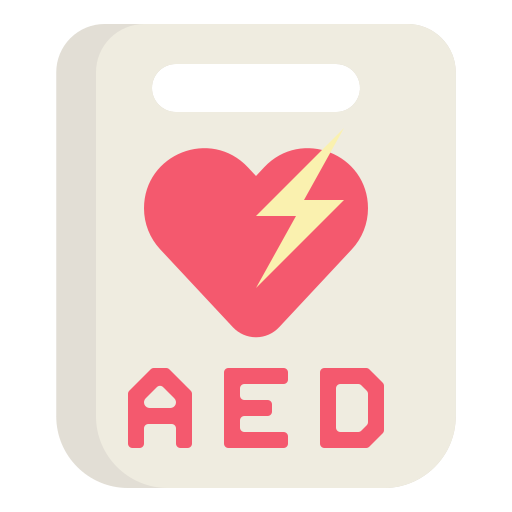
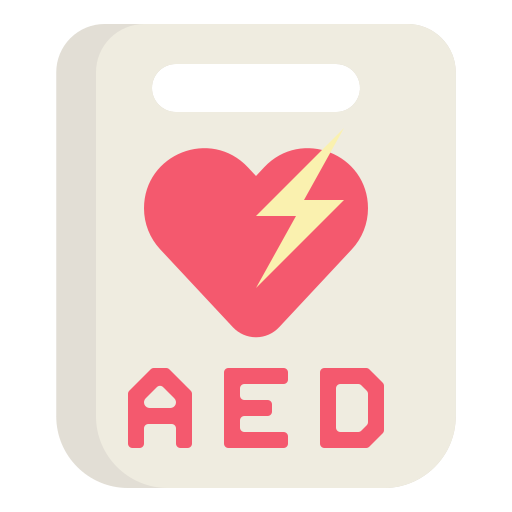
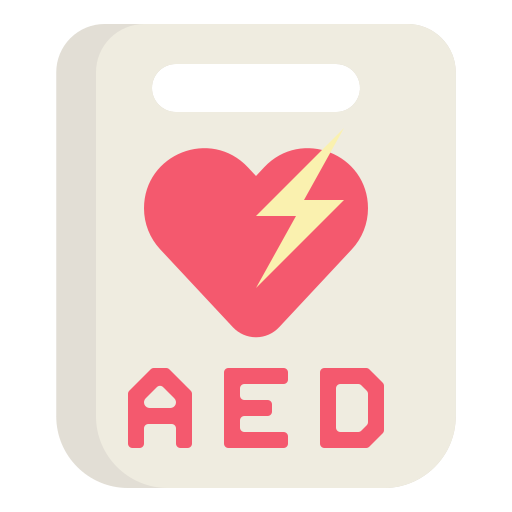
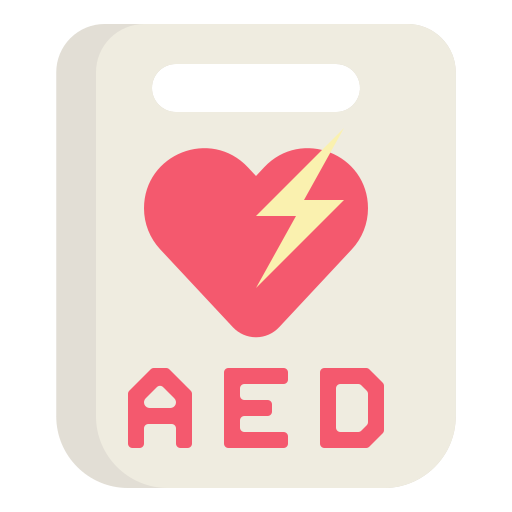
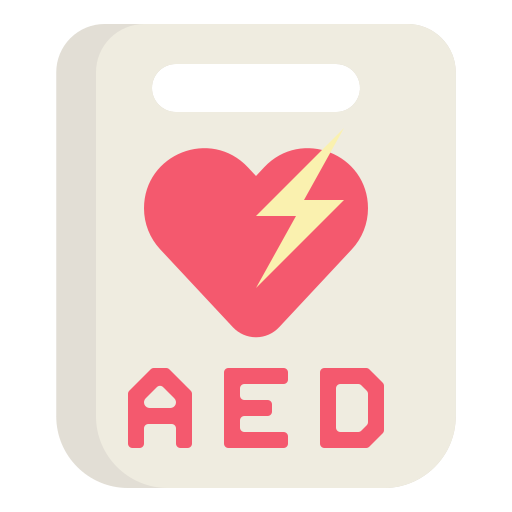
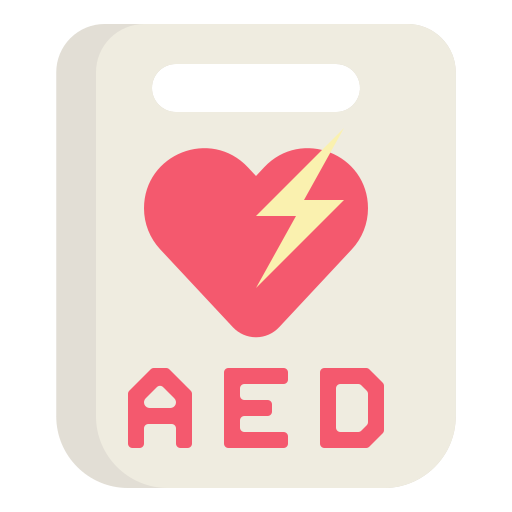
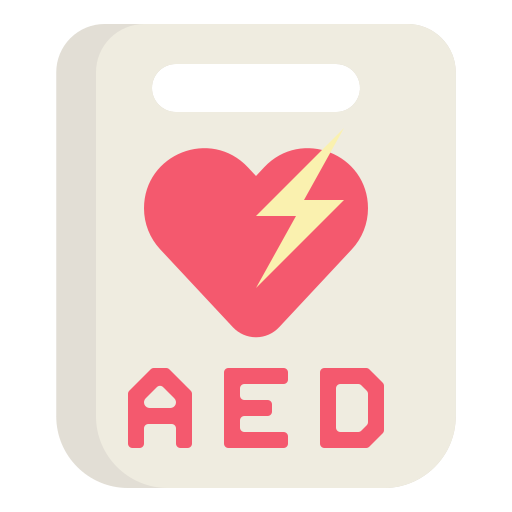
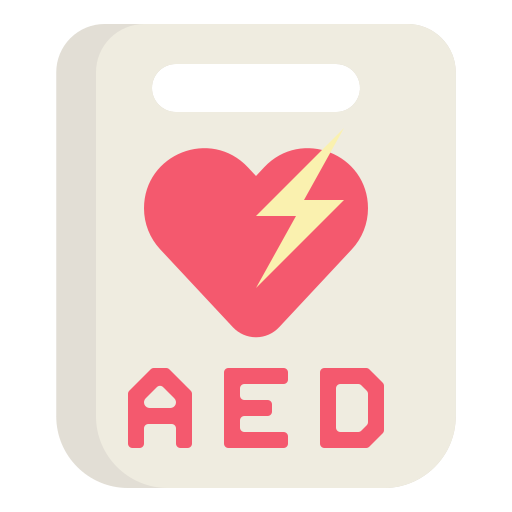
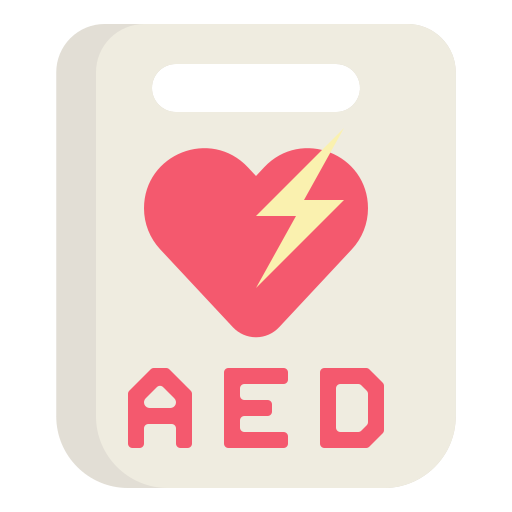
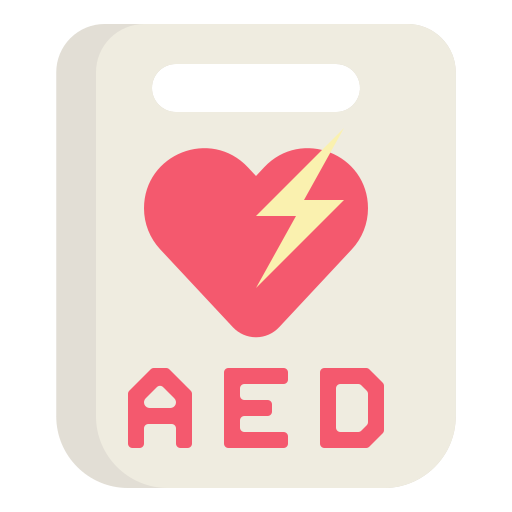
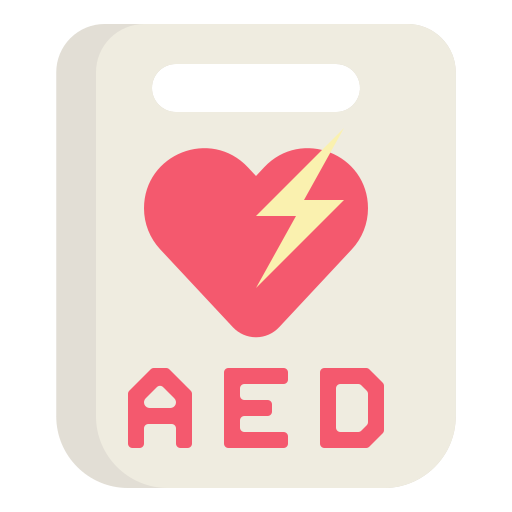
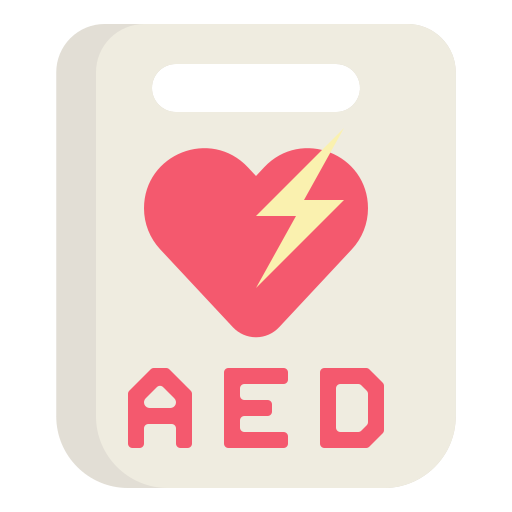
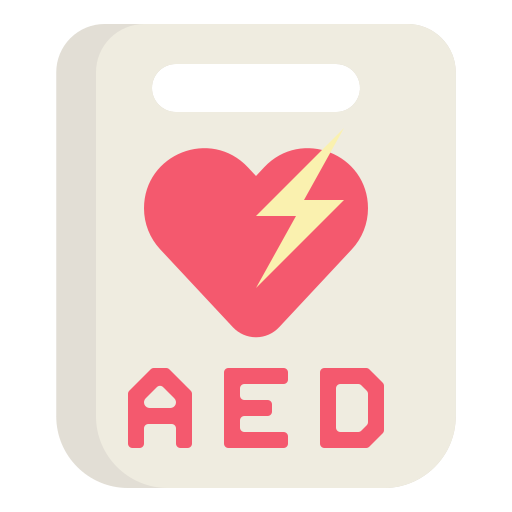
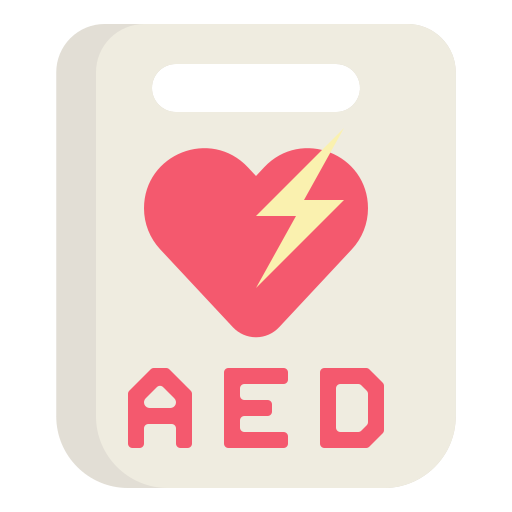
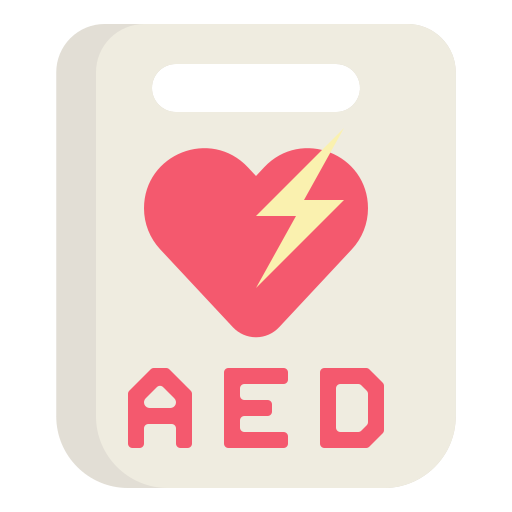
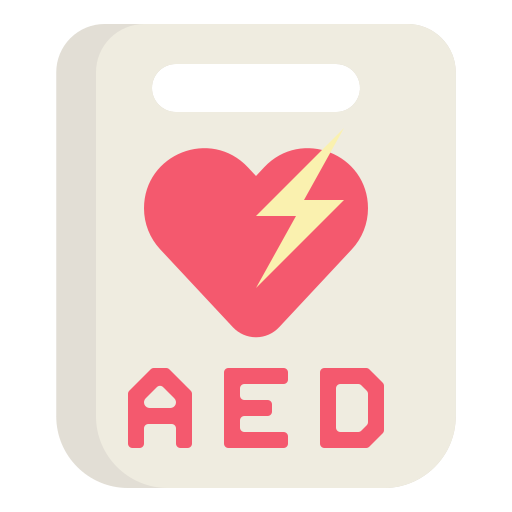
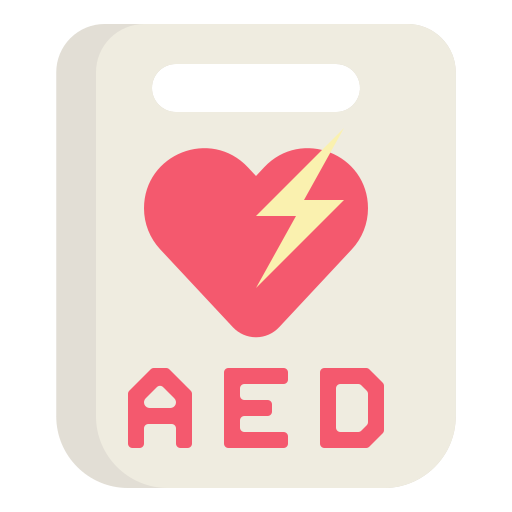
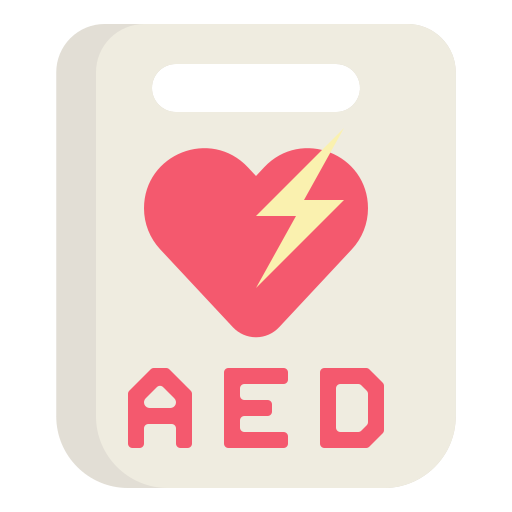
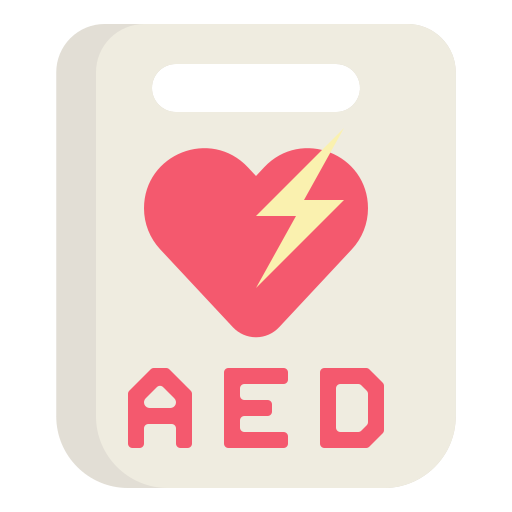
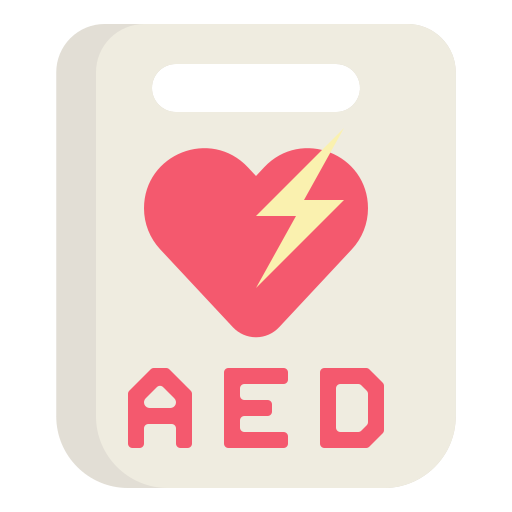
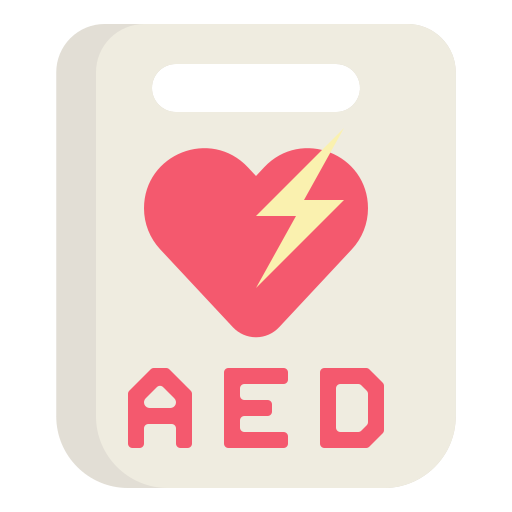
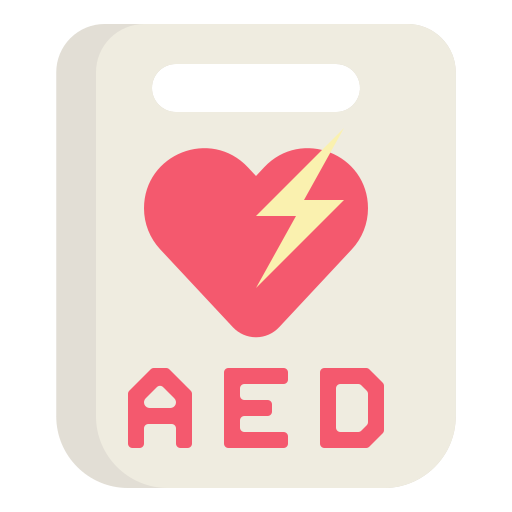
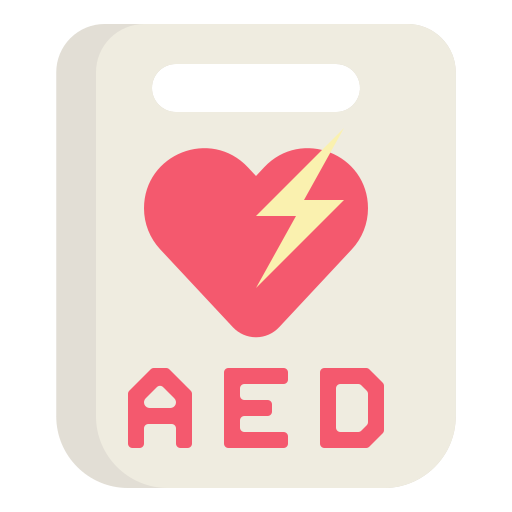
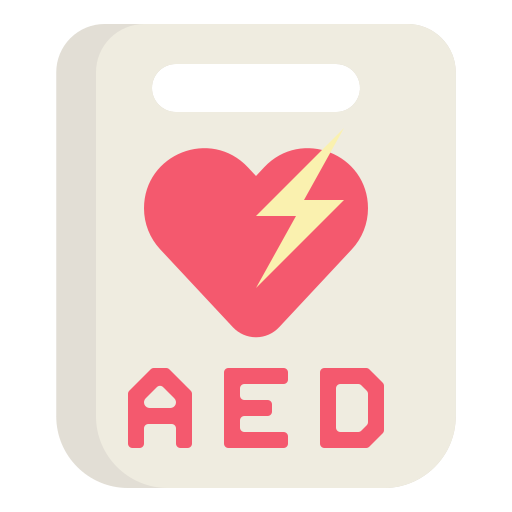
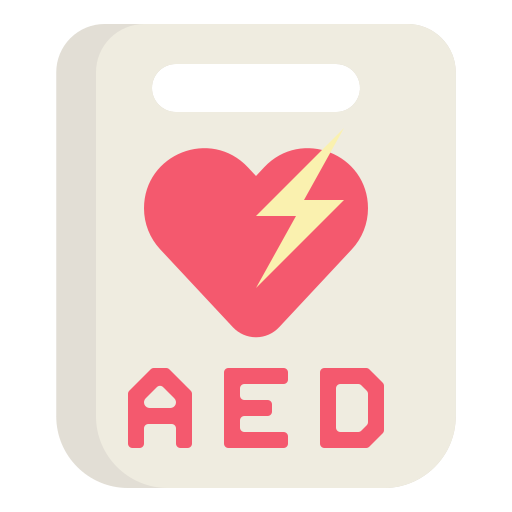
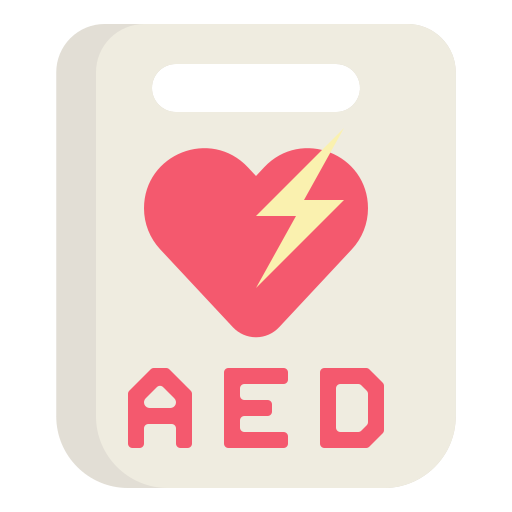
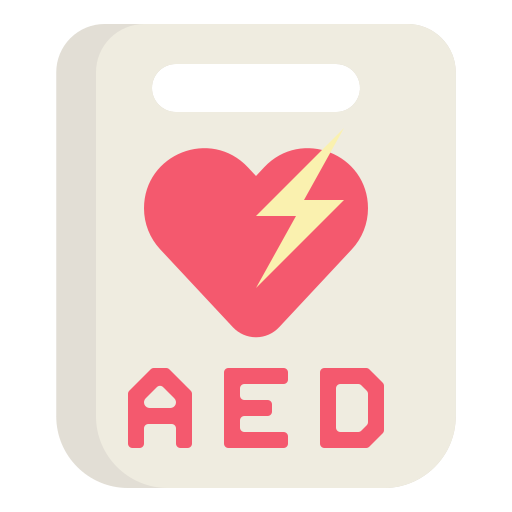
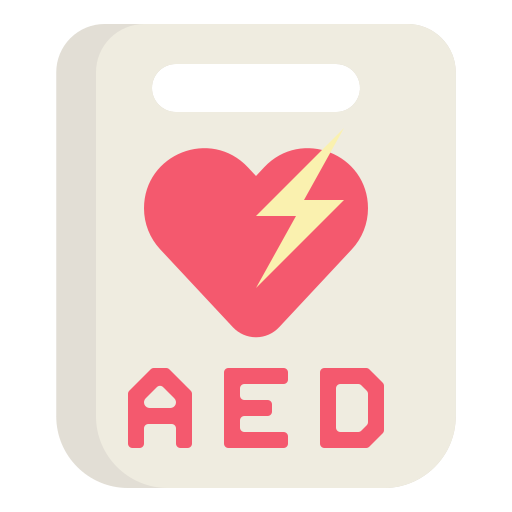
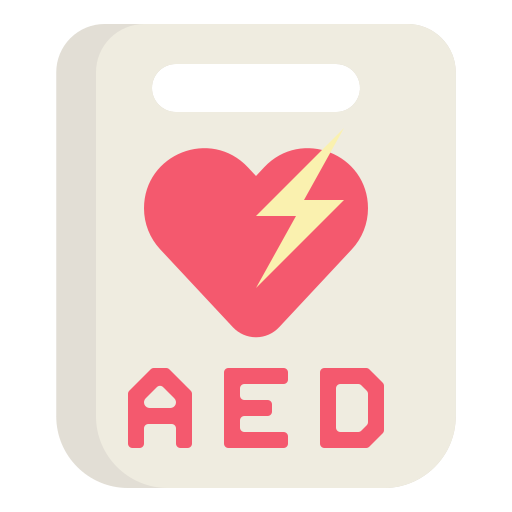
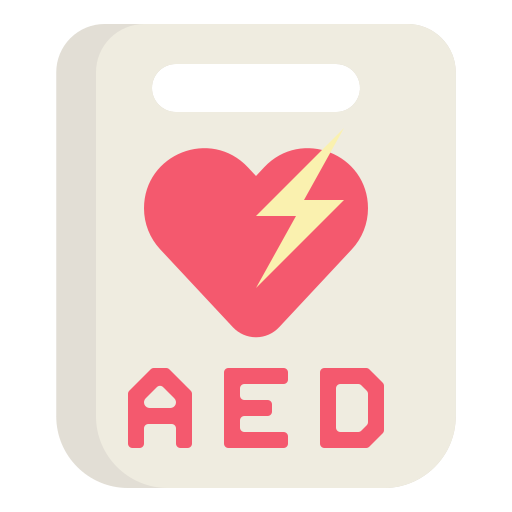
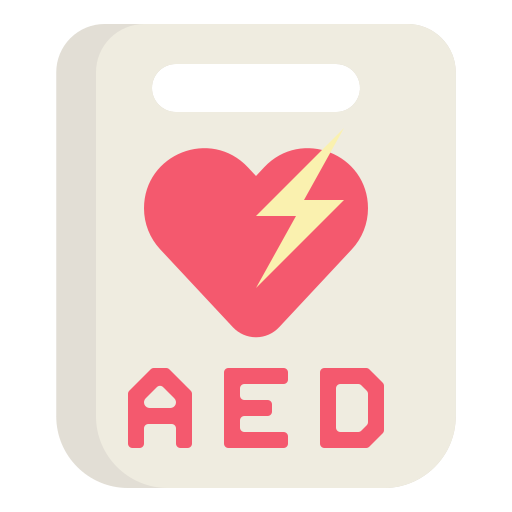
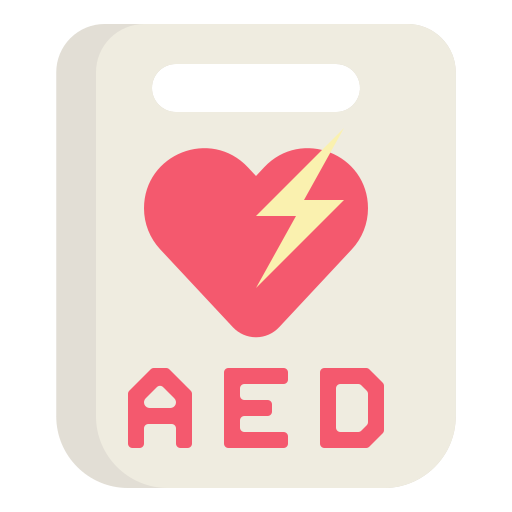
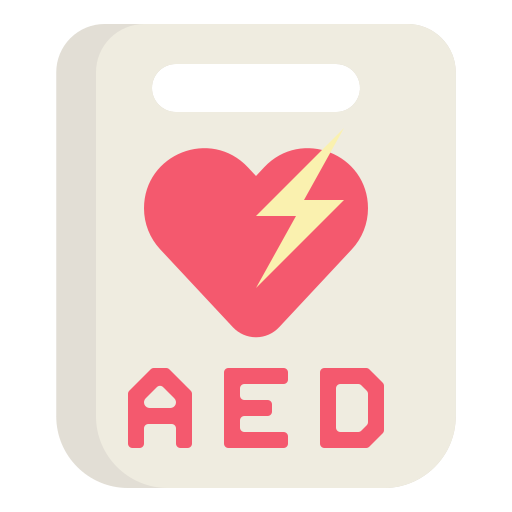
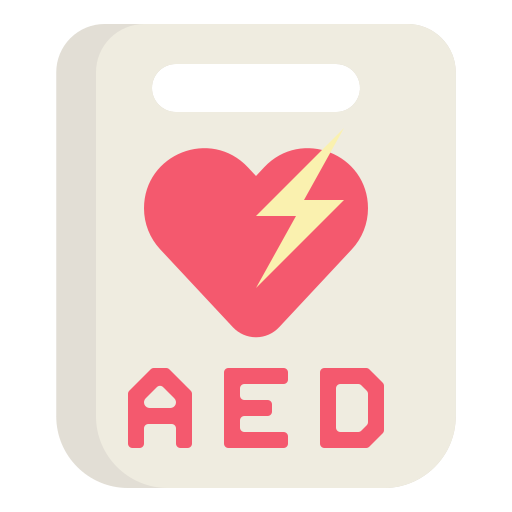
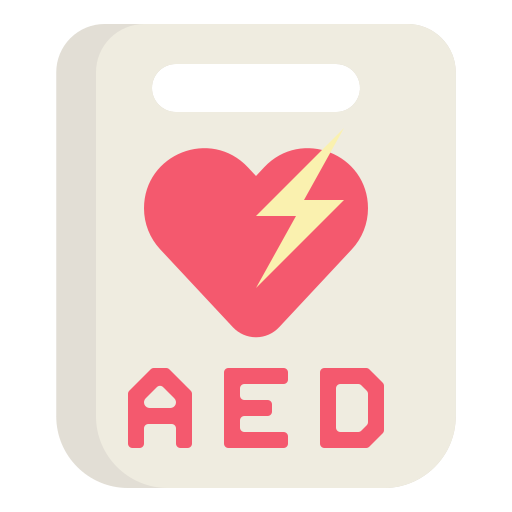
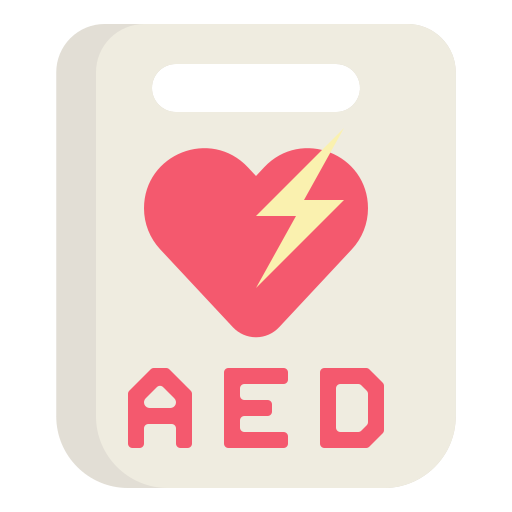
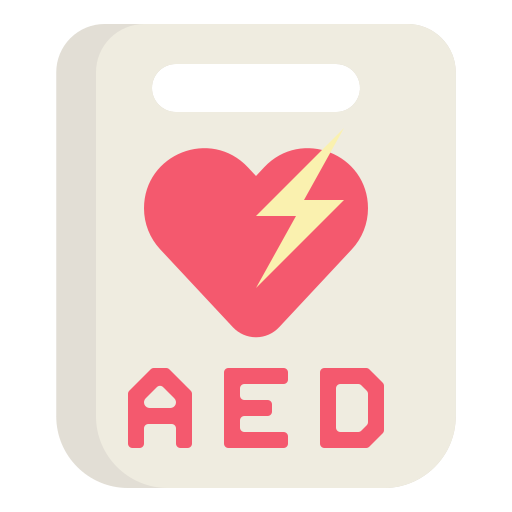
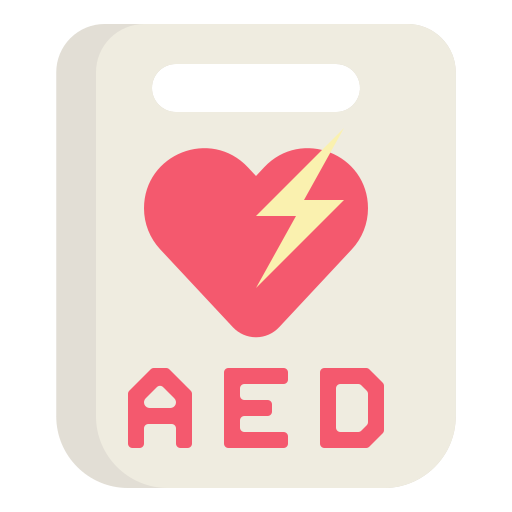
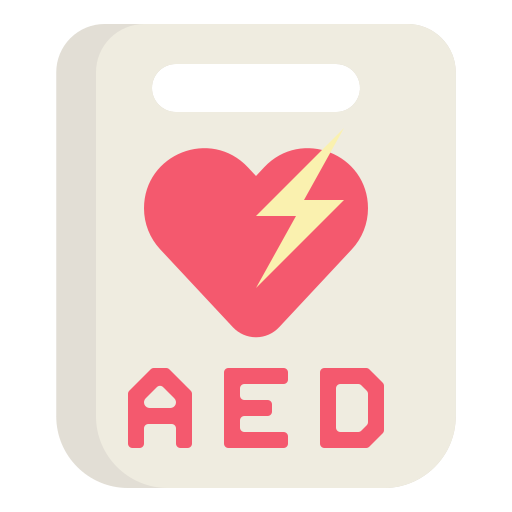
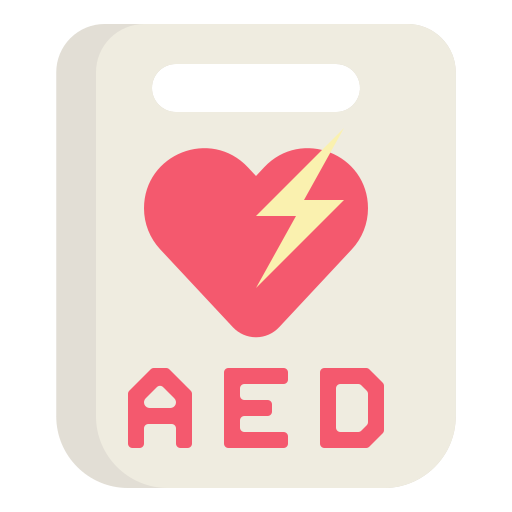
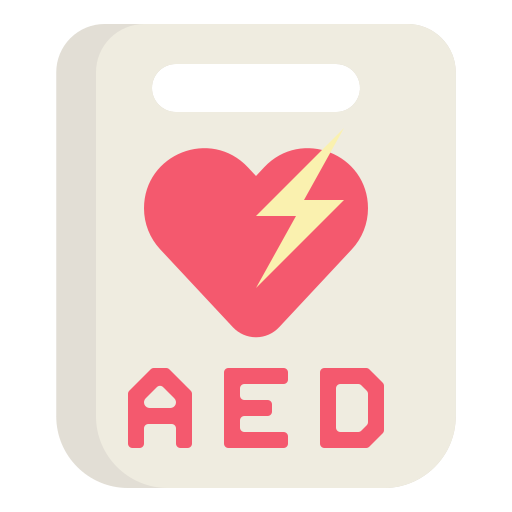
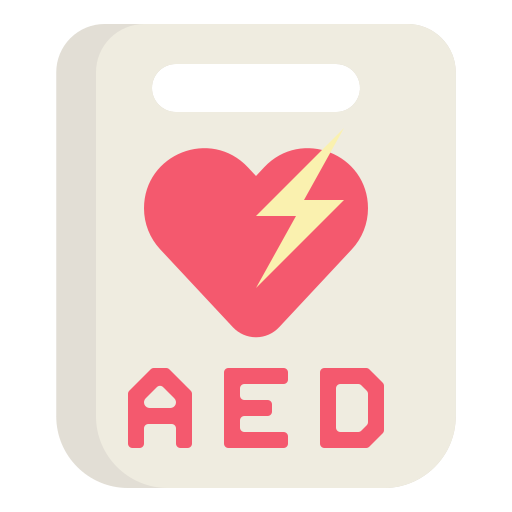
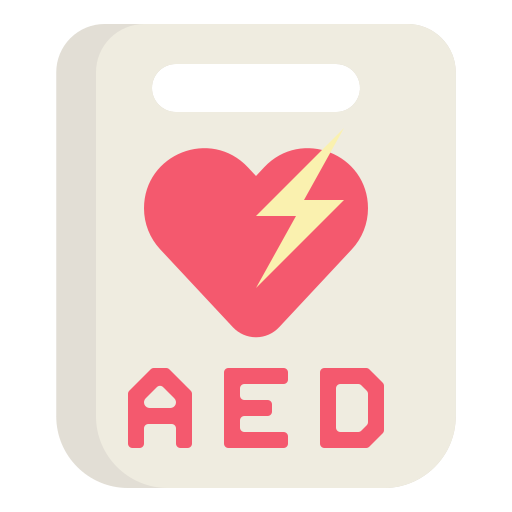
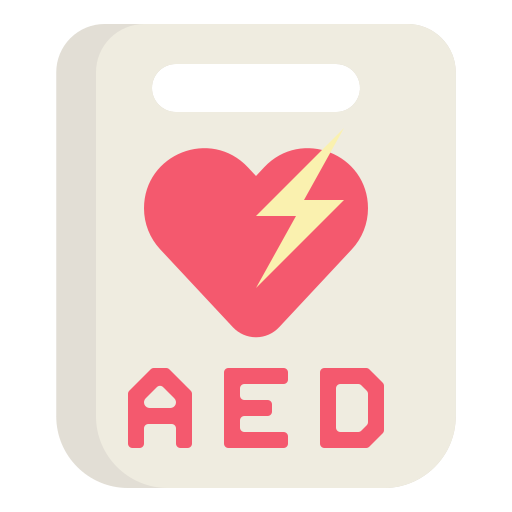
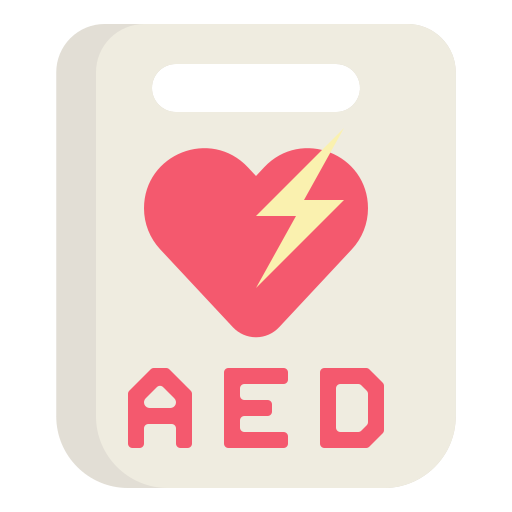
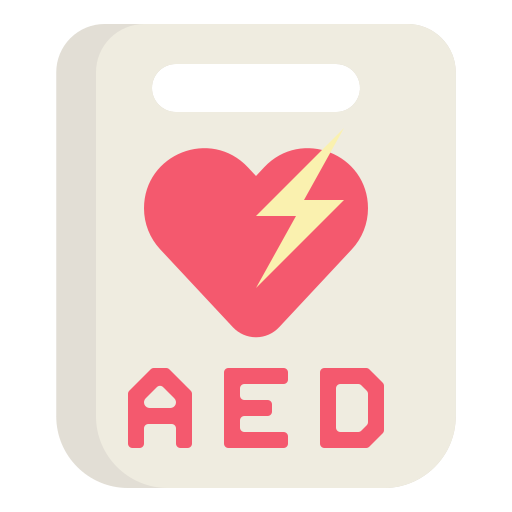
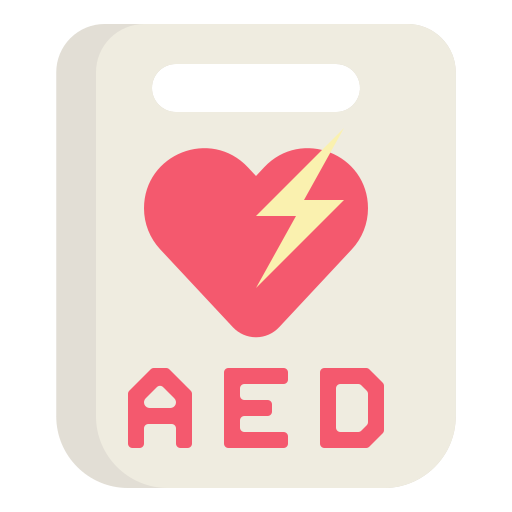
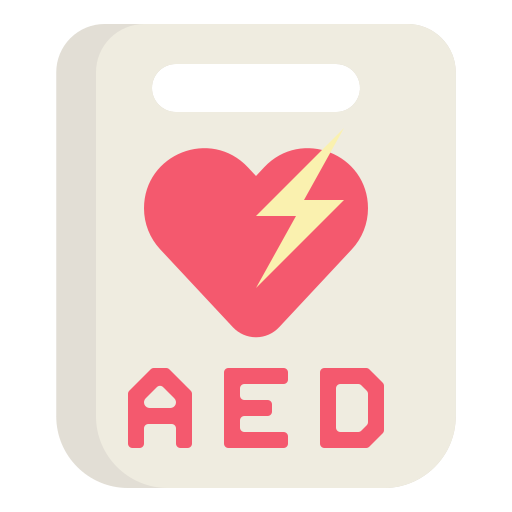
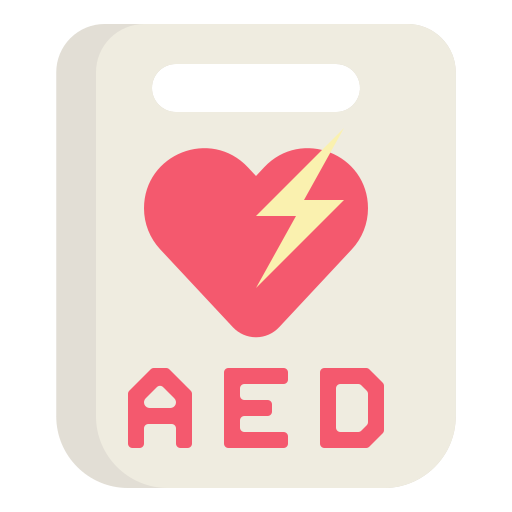
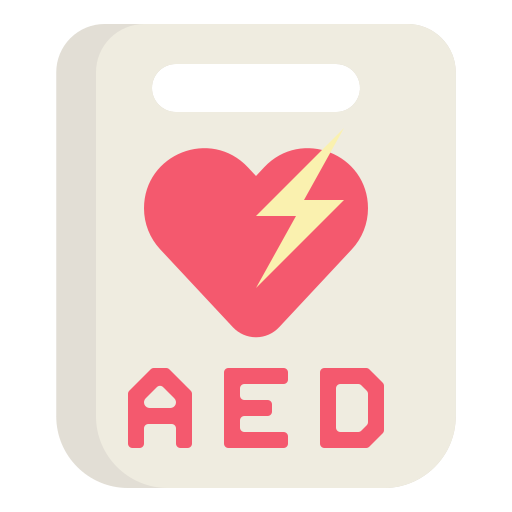
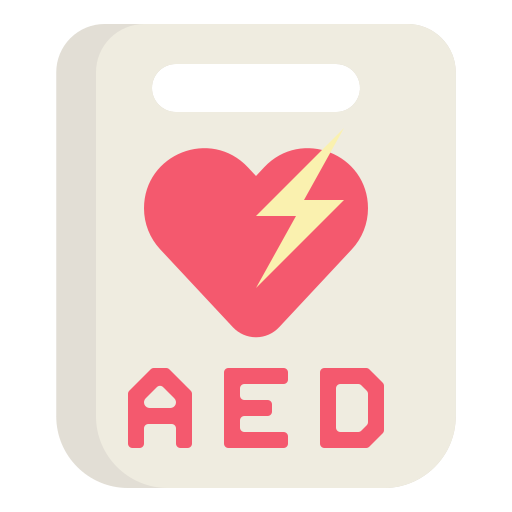
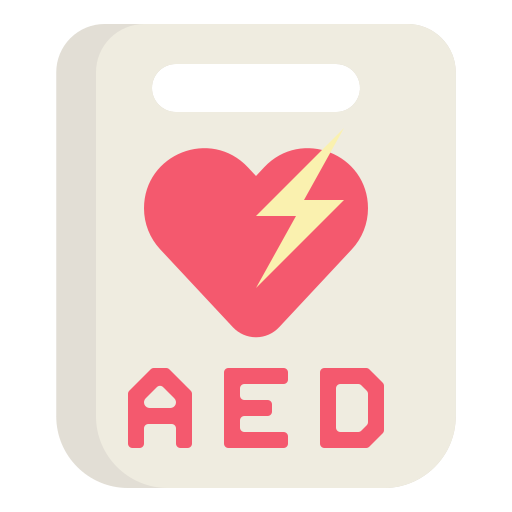
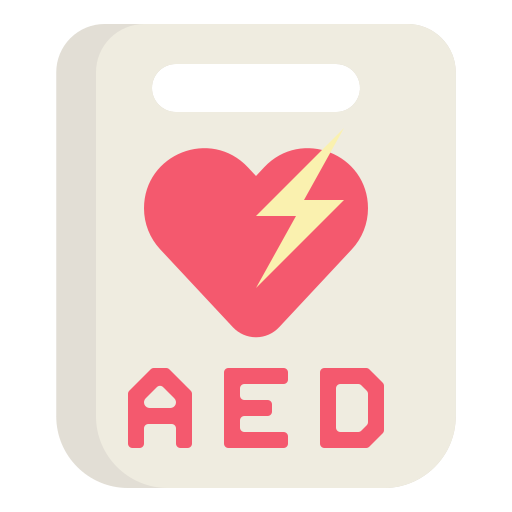
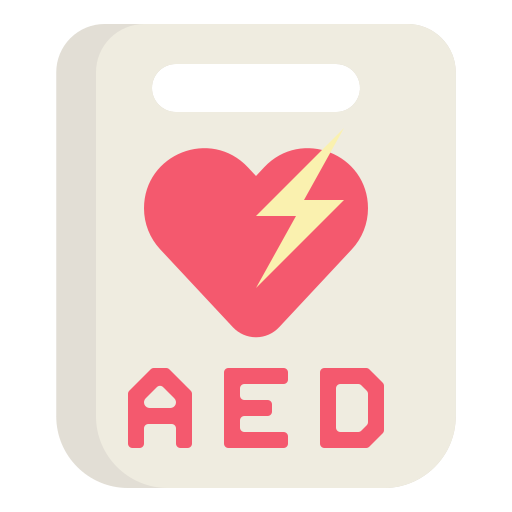
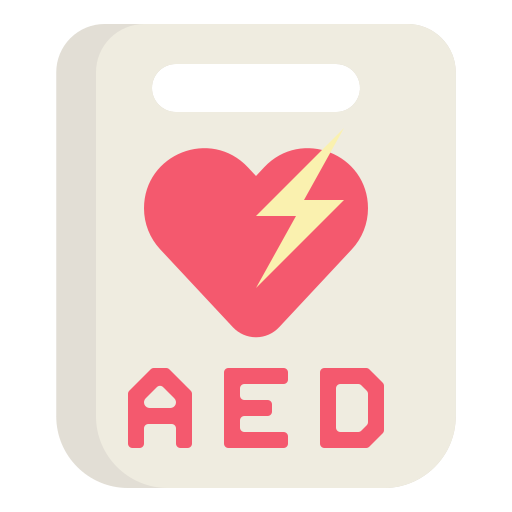
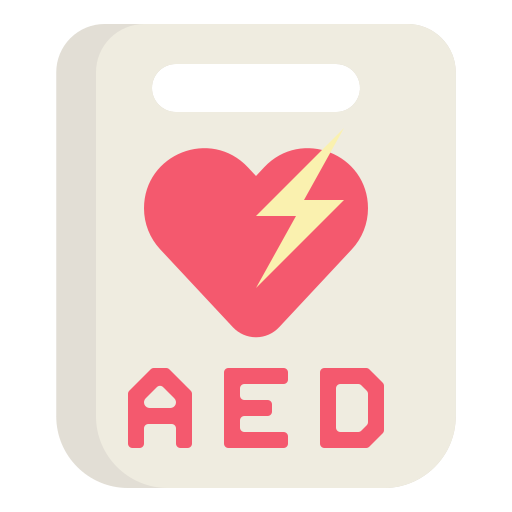
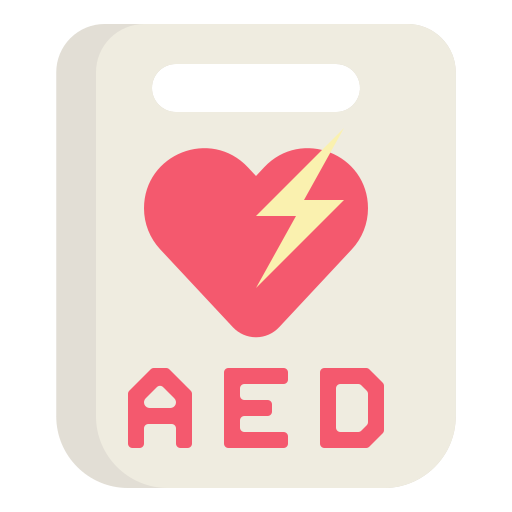
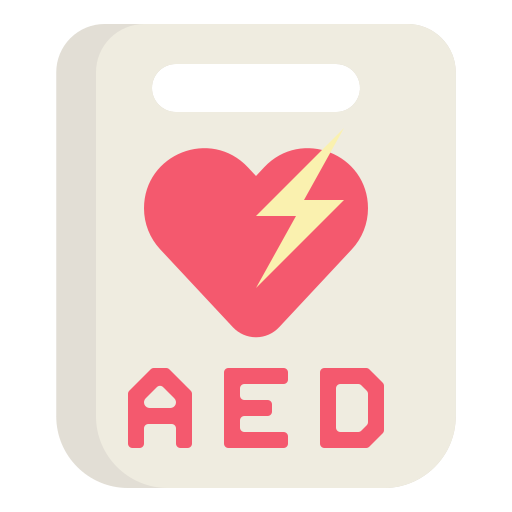
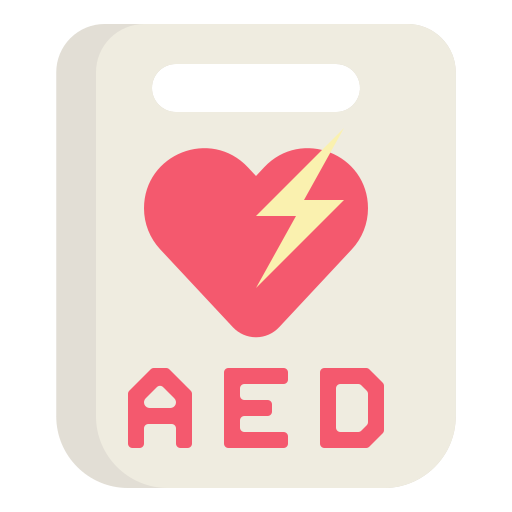
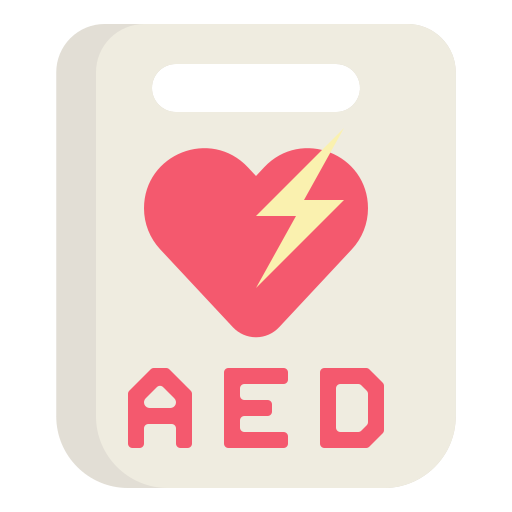
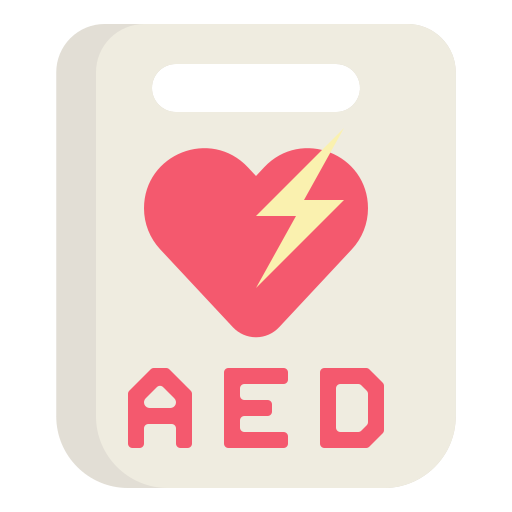
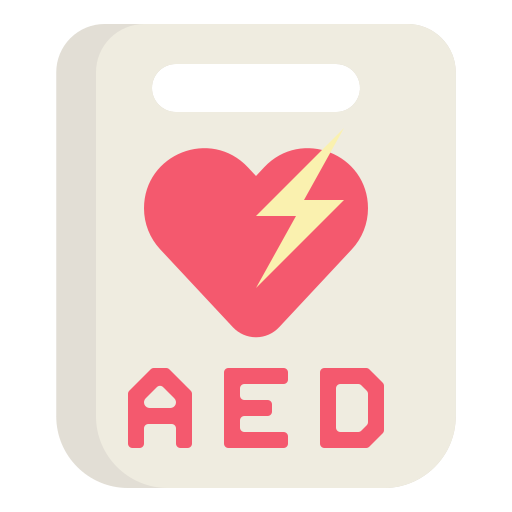
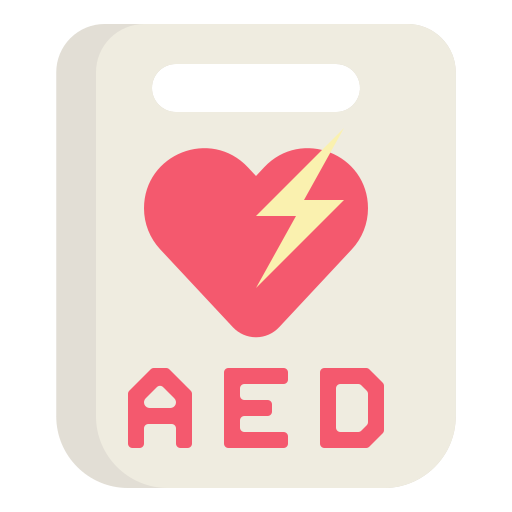
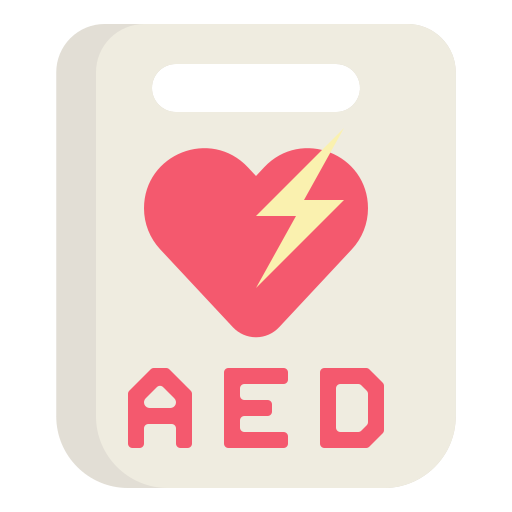
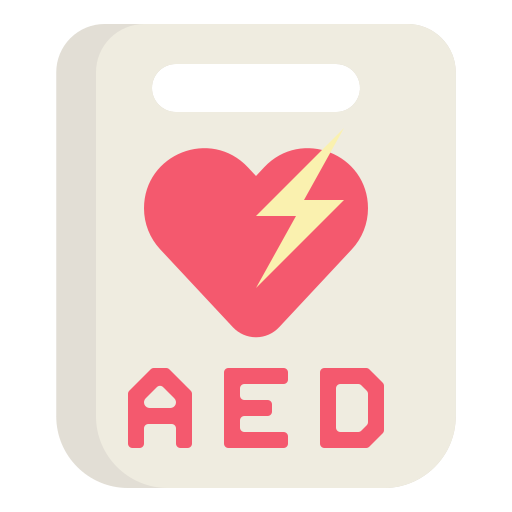
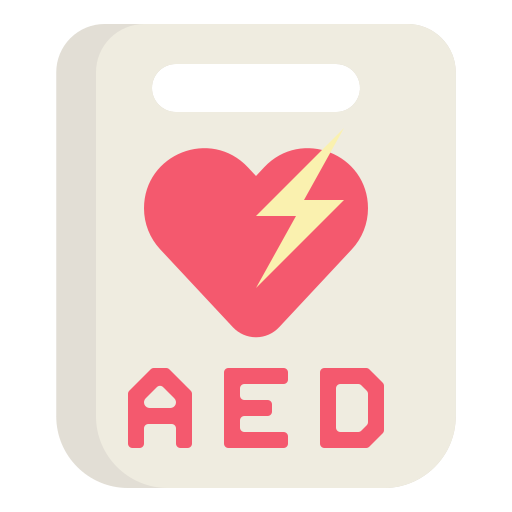
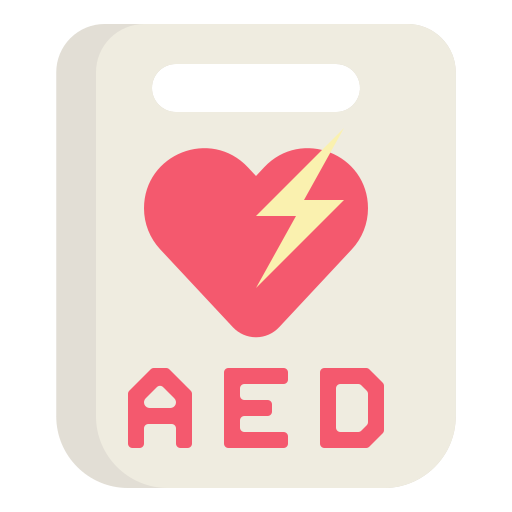
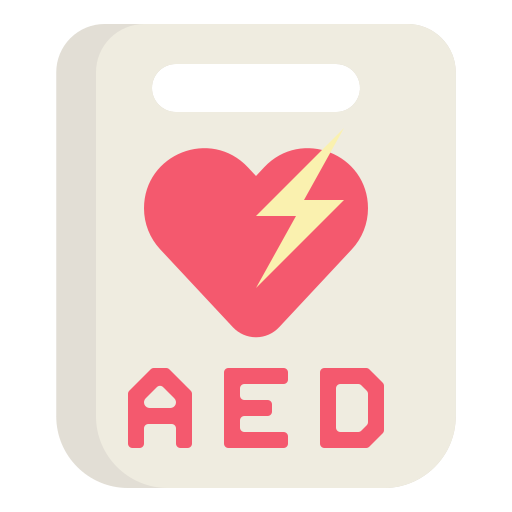
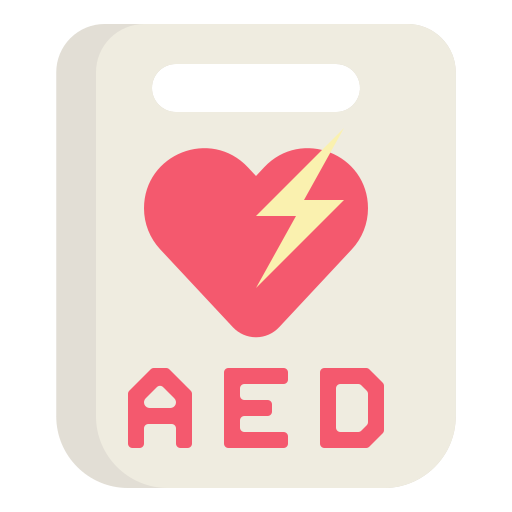
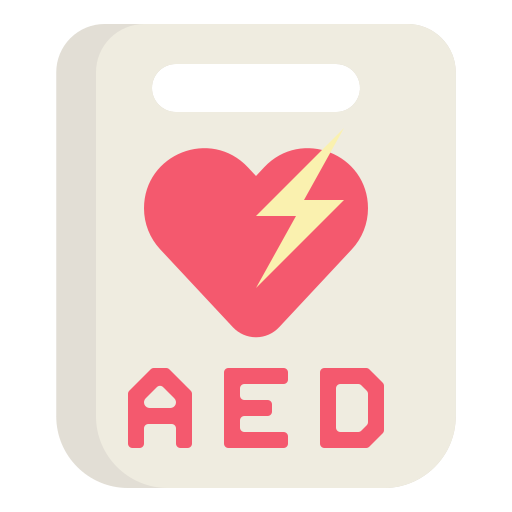
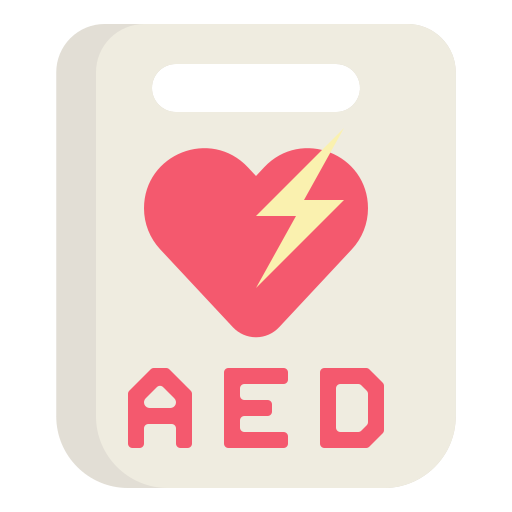
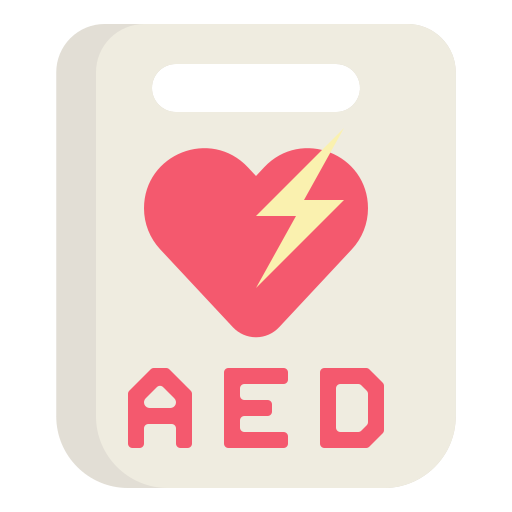
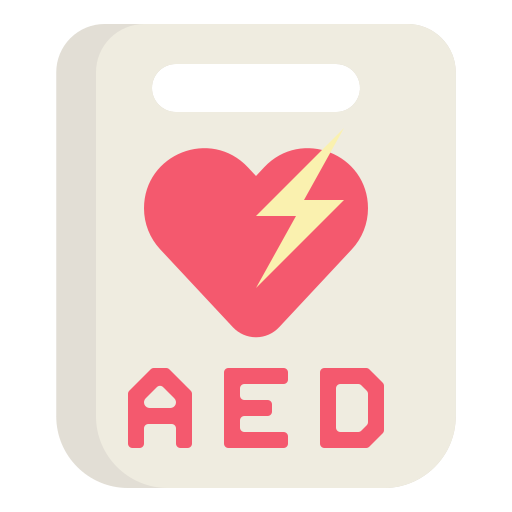
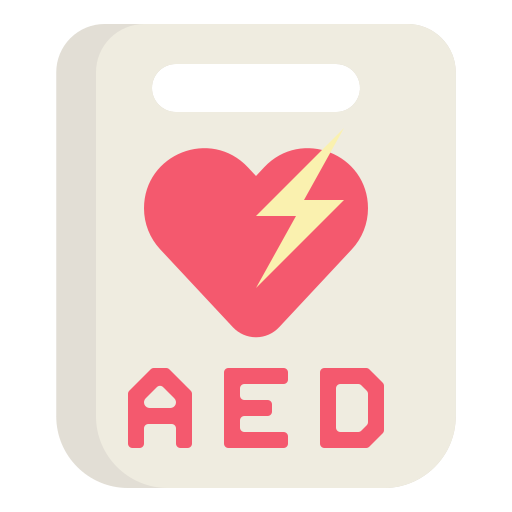
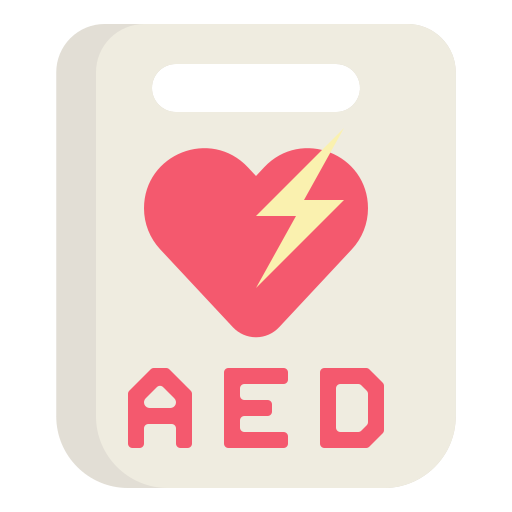
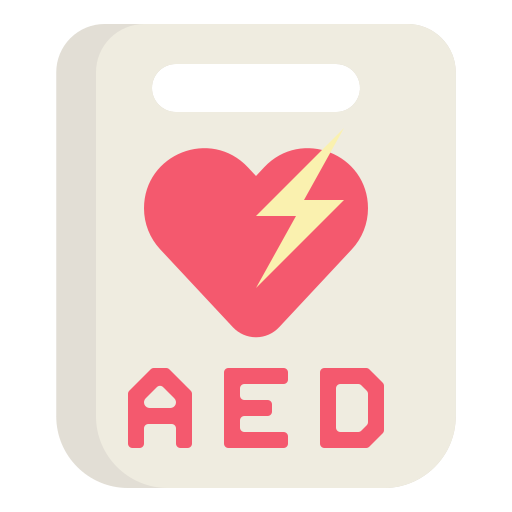
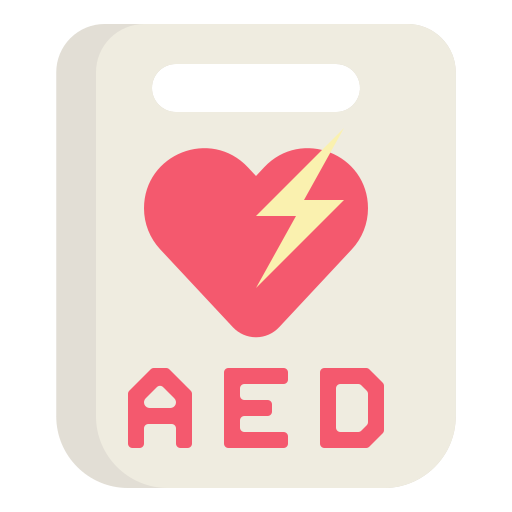
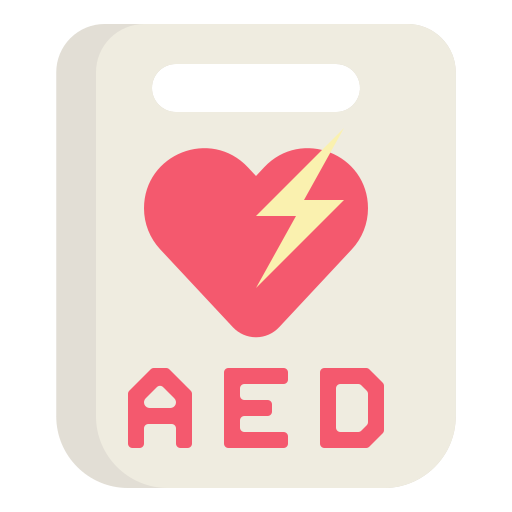
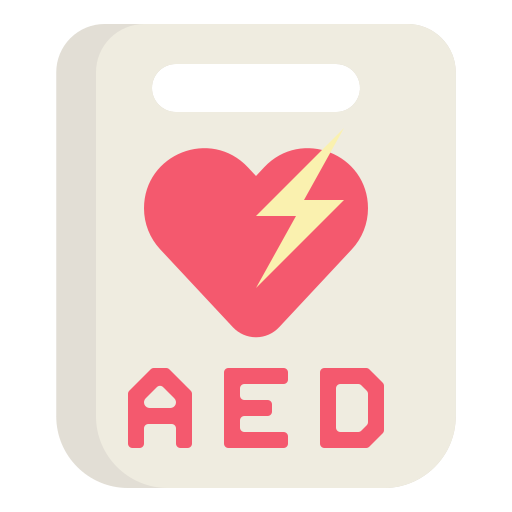

In [15]:
# 기존 24시간 AED 
layer1 = pdk.Layer(
    'PolygonLayer',
    aed_24_200,
    get_polygon='buffer_200_coordinates',
    get_fill_color= '[216, 157, 227, 89]',
    get_fill_line=[255, 255, 255, 100],
    pickable=True,
    auto_highlight=True)

layer2 = pdk.Layer(
    "IconLayer",
    aed_24_200,
    get_icon="icon_data",
    get_size=8,
    size_scale=3,
    get_position='[lon, lat]',
    pickable=True,
    auto_highlight=True
)


# 새롭게 추가된 AED 
layer3 = pdk.Layer(
    'PolygonLayer',
    sol,
    get_polygon='buffer_200_coordinates',
    get_fill_color = '[225, 225, 0, 130]',
    get_fill_line = [255, 255, 255, 100],
    pickable=True,
    auto_highlight=True)

layer4 = pdk.Layer(
    'IconLayer',
    sol,
    get_icon="icon_data",
    get_size=8,
    size_scale=3,
    get_position='[lon, lat]',
    pickable=True,
    auto_highlight=True
)

center = [127.0400, 37.5744]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=13)

r = pdk.Deck(layers=[layer1, layer2, layer3, layer4], initial_view_state=view_state)
r.to_html('')